# Hypertension DDIs pipeline

Steps to build the pipeline:
1. Useful functions for the pipeline (mapping, retrieving data from web apis...)
2. Find positive and negative controls for the AE of interest
3. Retrieve adverse event report data for these and a set of control drugs
4. Build the training and testing frequency tables
5. Features reduction to avoid overfitting
6. Drugpair predictions
7. Corroboration using OHDSI data

In [1]:
import csv
import gzip
import tqdm
import json
import heapq
import random
import urllib2

import requests
import itertools

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
from collections import defaultdict
from biothings_client import get_client

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from urllib2 import Request, urlopen, URLError, build_opener

#import OHDSI_API_data_ as ohdsi

%matplotlib inline

In [2]:
from import_notebook import *
sys.meta_path.append(NotebookFinder())
import OHDSI_API_data_ as ohdsi

importing Jupyter notebook from OHDSI_API_data_.ipynb
{u'VOCABULARY_ID': u'LOINC', u'CONCEPT_CLASS_ID': u'Clinical Observation', u'STANDARD_CONCEPT_CAPTION': u'Standard', u'CONCEPT_NAME': u'Descending thoracic aorta Diastolic blood pressure', u'INVALID_REASON': u'V', u'STANDARD_CONCEPT': u'S', u'INVALID_REASON_CAPTION': u'Valid', u'CONCEPT_CODE': u'8369-1', u'DOMAIN_ID': u'Measurement', u'CONCEPT_ID': 3037744}
[{u'conceptId': 1177480, u'includeMapped': 0, u'isExcluded': 0, u'includeDescendants': 0, u'id': 158061, u'conceptSetId': 158060}]


## Needed functions

In [3]:
ADVERSE_EVENT_OF_INTEREST = 'hypertension'

# adverse events related to hypertension (from SIDER)
AE_LIST = ['hypertension', 'hypertention worsened', 'hypertension paroxysmal']

In [4]:
# Authentication module
# Instructions at https://documentation.uts.nlm.nih.gov/rest/home.html

#get the tgt corresponding to the apikey
def get_tgt(apikey):
    tgt = requests.post("https://utslogin.nlm.nih.gov/cas/v1/api-key", data = {'apikey':apikey})
    TGT = tgt.content.split()[20]
    TGT = TGT[52:+len(TGT)-1]
    return TGT

#get a ticket corresponding to the tgt
def get_ticket(tgt):
    uri_login = "https://utslogin.nlm.nih.gov/cas/v1/tickets/" + tgt
    ticket = requests.post(uri_login, data = {'service':'http://umlsks.nlm.nih.gov'})
    return ticket.content


In [5]:
def AEtoCUI(aeName, apikey):
    "Converts AE name to UMLS CUIs"
    cuis = []
    
    tgt = get_tgt(apikey)
    ticket = get_ticket(tgt)
    
    query = {'ticket':ticket}
    uri = "https://uts-ws.nlm.nih.gov/rest/search/current?string=" + aeName
    r = requests.get(uri, params = query)
    r.encoding = 'utf-8'
    items  = json.loads(r.text)
    
    jsonData = items["result"]
    for s in jsonData['results']:
        cuis.append(s['ui'])
    return cuis

In [29]:
def nsides_api(service, method, args = None):
    """
    Simple python API to access the NSIDES services and data.
    
    service   string, that can be one of three values: aeolus, sider, or omop
    method    string, for a list of methods see http://nsideseb-env.us-east-1.elasticbeanstalk.com
    args      dictionary, method parameters see http://nsideseb-env.us-east-1.elasticbeanstalk.com
    """
    NSIDES_API_URL = 'http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/'
    
    base_url = NSIDES_API_URL + 'query?service=%s&meta=%s' % (service, method)
    url = base_url
    if not args is None:
        url = base_url + '&' + '&'.join(['%s=%s' % (k,v) for k,v in args.items()])
    #print url
    
    response = urllib2.urlopen(url).read()
    data = json.loads(response)
    
    return data

# Test with one value
#reference_byname = list()
#data = nsides_api('sider', 'drugForEffect', {'q': 'C0235750'})
#reference_byname.extend( [(r['drug_name'], 1) for r in data['results']] )
#print len(reference_byname)
#print reference_byname

In [7]:
# map the name of a drug to its rxnorm notation
def annotator(text, ontologies):
    REST_URL = "http://data.bioontology.org"
    API_KEY = 'b55cf758-dbd3-4959-a9c0-2e6bba5b5d8b'
    url = REST_URL + "/annotator?text=" + urllib2.quote(text) + "&ontologies=" + ','.join(ontologies)
    opener = urllib2.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    
    annotations = json.loads(opener.open(url).read())

    return annotations

def name2rxnorm(drugname):
    annotations = annotator(drugname, ['RXNORM'])
    
    rxnorms = list()
    for annotation in annotations:
        rxnorms.append(annotations[0]['annotatedClass']['@id'].split('/')[-1])
    
    return rxnorms

print name2rxnorm('apraclonidine')

[u'14845']


In [8]:
def stitch_api(id):
    """
    Function to access STITCH data
    id : stitch id (string)
    returns drug rxnorm
    """
    STITCH_API_URL = 'http://stitch.embl.de/api/json/'
    request = 'resolve?identifier=%s' %(id)
    
    url = STITCH_API_URL + request
    
    response = urllib2.urlopen(url).read()
    data = json.loads(response)
    
    return data
    
data = stitch_api('CID000041774')
print data[0]['preferredName']
print name2rxnorm('acarbose')

acarbose
[u'16681']


## Find positive and negative controls

In [54]:
# Get a list of drugs (name) known to have hypertension as a side effect using SIDER
reference_byname = list()
for cui in AEtoCUI('hypertension', apikey):
    #print cui
    if cui=='C0020538' : #this cui causes a syntax error (in the json)
        continue
    else :
        data = nsides_api('sider', 'drugForEffect', {'q': "%s" %cui})
        reference_byname.extend( [(r['drug_name'], 1) for r in data['results']] )
    
if len(reference_byname) == 0:
    raise Exception("No available reference standard for cui: %s" % cui)

reference_byname = sorted(set(reference_byname))
print len(reference_byname)
#print sorted(reference_byname)

84


In [55]:
# We add manually the drugs coreesponding to the cui C0020538
# http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffect&q=C0020538
data0 = {"results": [{"drug_name": "carnitine", "stitch_id": "CID000000085"}, {"drug_name": "prostaglandin E2", "stitch_id": "CID000000158"}, {"drug_name": "prostaglandin E1", "stitch_id": "CID000000214"}, {"drug_name": "bupropion", "stitch_id": "CID000000444"}, {"drug_name": "mannitol", "stitch_id": "CID000000453"}, {"drug_name": "epsilon-aminocaproic acid", "stitch_id": "CID000000564"}, {"drug_name": "cytosine arabinoside", "stitch_id": "CID000000596"}, {"drug_name": "mesna", "stitch_id": "CID000000598"}, {"drug_name": "dopamine", "stitch_id": "CID000000681"}, {"drug_name": "low molecular weight heparin", "stitch_id": "CID000000772"}, {"drug_name": "histamine", "stitch_id": "CID000000774"}, {"drug_name": "iodine", "stitch_id": "CID000000807"}, {"drug_name": "epinephrine", "stitch_id": "CID000000838"}, {"drug_name": "triiodothyronine", "stitch_id": "CID000000861"}, {"drug_name": "nicotine", "stitch_id": "CID000000942"}, {"drug_name": "norepinephrine", "stitch_id": "CID000000951"}, {"drug_name": "naproxen", "stitch_id": "CID000001301"}, {"drug_name": "doxorubicin", "stitch_id": "CID000001690"}, {"drug_name": "phenytoin", "stitch_id": "CID000001775"}, {"drug_name": "5-azacytidine", "stitch_id": "CID000001805"}, {"drug_name": "tacrine", "stitch_id": "CID000001935"}, {"drug_name": "amphotericin B", "stitch_id": "CID000001972"}, {"drug_name": "acetaminophen", "stitch_id": "CID000001983"}, {"drug_name": "salbutamol", "stitch_id": "CID000002083"}, {"drug_name": "allopurinol", "stitch_id": "CID000002094"}, {"drug_name": "amantadine", "stitch_id": "CID000002130"}, {"drug_name": "diatrizoate", "stitch_id": "CID000002140"}, {"drug_name": "amifostine", "stitch_id": "CID000002141"}, {"drug_name": "amitriptyline", "stitch_id": "CID000002160"}, {"drug_name": "amoxapine", "stitch_id": "CID000002170"}, {"drug_name": "anagrelide", "stitch_id": "CID000002182"}, {"drug_name": "anastrozole", "stitch_id": "CID000002187"}, {"drug_name": "azelastine", "stitch_id": "CID000002267"}, {"drug_name": "azithromycin", "stitch_id": "CID000002269"}, {"drug_name": "baclofen", "stitch_id": "CID000002284"}, {"drug_name": "betaxolol", "stitch_id": "CID000002369"}, {"drug_name": "bicalutamide", "stitch_id": "CID000002375"}, {"drug_name": "bretylium", "stitch_id": "CID000002431"}, {"drug_name": "bromocriptine", "stitch_id": "CID000002443"}, {"drug_name": "budesonide", "stitch_id": "CID000002462"}, {"drug_name": "bupivacaine", "stitch_id": "CID000002474"}, {"drug_name": "buprenorphine", "stitch_id": "CID000002476"}, {"drug_name": "buspirone", "stitch_id": "CID000002477"}, {"drug_name": "busulfan", "stitch_id": "CID000002478"}, {"drug_name": "butorphanol", "stitch_id": "CID000002487"}, {"drug_name": "capsaicin", "stitch_id": "CID000002548"}, {"drug_name": "carbamazepine", "stitch_id": "CID000002554"}, {"drug_name": "BCNU", "stitch_id": "CID000002578"}, {"drug_name": "celecoxib", "stitch_id": "CID000002662"}, {"drug_name": "cerivastatin", "stitch_id": "CID000002676"}, {"drug_name": "cetirizine", "stitch_id": "CID000002678"}, {"drug_name": "cevimeline", "stitch_id": "CID000002684"}, {"drug_name": "chlorhexidine", "stitch_id": "CID000002713"}, {"drug_name": "ciprofloxacin", "stitch_id": "CID000002764"}, {"drug_name": "citalopram", "stitch_id": "CID000002771"}, {"drug_name": "clindamycin", "stitch_id": "CID000002786"}, {"drug_name": "clomiphene citrate", "stitch_id": "CID000002800"}, {"drug_name": "clopidogrel", "stitch_id": "CID000002806"}, {"drug_name": "clozapine", "stitch_id": "CID000002818"}, {"drug_name": "cyclobenzaprine", "stitch_id": "CID000002895"}, {"drug_name": "Neoral", "stitch_id": "CID000002909"}, {"drug_name": "danazol", "stitch_id": "CID000002949"}, {"drug_name": "deferiprone", "stitch_id": "CID000002972"}, {"drug_name": "demeclocycline", "stitch_id": "CID000002983"}, {"drug_name": "desipramine", "stitch_id": "CID000002995"}, {"drug_name": "dexamethasone", "stitch_id": "CID000003003"}, {"drug_name": "amphetamine", "stitch_id": "CID000003007"}, {"drug_name": "diclofenac", "stitch_id": "CID000003032"}, {"drug_name": "dicyclomine", "stitch_id": "CID000003042"}, {"drug_name": "didanosine", "stitch_id": "CID000003043"}, {"drug_name": "dihydroergotamine", "stitch_id": "CID000003066"}, {"drug_name": "dipivefrin", "stitch_id": "CID000003105"}, {"drug_name": "dipyridamole", "stitch_id": "CID000003108"}, {"drug_name": "valproic acid", "stitch_id": "CID000003121"}, {"drug_name": "docetaxel", "stitch_id": "CID000003143"}, {"drug_name": "dolasetron", "stitch_id": "CID000003148"}, {"drug_name": "donepezil", "stitch_id": "CID000003152"}, {"drug_name": "doxepin", "stitch_id": "CID000003158"}, {"drug_name": "doxycycline", "stitch_id": "CID000003161"}, {"drug_name": "droperidol", "stitch_id": "CID000003168"}, {"drug_name": "efavirenz", "stitch_id": "CID000003203"}, {"drug_name": "vitamin D2", "stitch_id": "CID000003249"}, {"drug_name": "etodolac", "stitch_id": "CID000003308"}, {"drug_name": "etoposide", "stitch_id": "CID000003310"}, {"drug_name": "felbamate", "stitch_id": "CID000003331"}, {"drug_name": "fentanyl", "stitch_id": "CID000003345"}, {"drug_name": "flecainide", "stitch_id": "CID000003355"}, {"drug_name": "fluphenazine", "stitch_id": "CID000003372"}, {"drug_name": "flumazenil", "stitch_id": "CID000003373"}, {"drug_name": "flunisolide", "stitch_id": "CID000003379"}, {"drug_name": "fluoxetine", "stitch_id": "CID000003386"}, {"drug_name": "flurbiprofen", "stitch_id": "CID000003394"}, {"drug_name": "flutamide", "stitch_id": "CID000003397"}, {"drug_name": "fluvoxamine", "stitch_id": "CID000003404"}, {"drug_name": "formoterol", "stitch_id": "CID000003410"}, {"drug_name": "foscarnet", "stitch_id": "CID000003414"}, {"drug_name": "gabapentin", "stitch_id": "CID000003446"}, {"drug_name": "galantamine", "stitch_id": "CID000003449"}, {"drug_name": "ganciclovir", "stitch_id": "CID000003454"}, {"drug_name": "gemcitabine", "stitch_id": "CID000003461"}, {"drug_name": "gentamicin", "stitch_id": "CID000003467"}, {"drug_name": "gliclazide", "stitch_id": "CID000003475"}, {"drug_name": "glipizide", "stitch_id": "CID000003478"}, {"drug_name": "glycopyrrolate", "stitch_id": "CID000003494"}, {"drug_name": "granisetron", "stitch_id": "CID000003510"}, {"drug_name": "haloperidol", "stitch_id": "CID000003559"}, {"drug_name": "cortisol", "stitch_id": "CID000003640"}, {"drug_name": "hydromorphone", "stitch_id": "CID000003648"}, {"drug_name": "ibuprofen", "stitch_id": "CID000003672"}, {"drug_name": "lidocaine", "stitch_id": "CID000003676"}, {"drug_name": "ifosfamide", "stitch_id": "CID000003690"}, {"drug_name": "imipramine", "stitch_id": "CID000003696"}, {"drug_name": "indomethacin", "stitch_id": "CID000003715"}, {"drug_name": "iodixanol", "stitch_id": "CID000003724"}, {"drug_name": "iohexol", "stitch_id": "CID000003730"}, {"drug_name": "iopamidol", "stitch_id": "CID000003734"}, {"drug_name": "iopromide", "stitch_id": "CID000003736"}, {"drug_name": "sodium iothalamate", "stitch_id": "CID000003737"}, {"drug_name": "ioversol", "stitch_id": "CID000003741"}, {"drug_name": "ioxilan", "stitch_id": "CID000003743"}, {"drug_name": "ipratropium bromide", "stitch_id": "CID000003746"}, {"drug_name": "irinotecan", "stitch_id": "CID000003750"}, {"drug_name": "isoproterenol", "stitch_id": "CID000003779"}, {"drug_name": "isosorbide dinitrate", "stitch_id": "CID000003780"}, {"drug_name": "itraconazole", "stitch_id": "CID000003793"}, {"drug_name": "ketoprofen", "stitch_id": "CID000003825"}, {"drug_name": "ketorolac", "stitch_id": "CID000003826"}, {"drug_name": "ketotifen", "stitch_id": "CID000003827"}, {"drug_name": "lamotrigine", "stitch_id": "CID000003878"}, {"drug_name": "lansoprazole", "stitch_id": "CID000003883"}, {"drug_name": "leflunomide", "stitch_id": "CID000003899"}, {"drug_name": "letrozole", "stitch_id": "CID000003902"}, {"drug_name": "leuprolide acetate", "stitch_id": "CID000003911"}, {"drug_name": "linezolid", "stitch_id": "CID000003929"}, {"drug_name": "lomefloxacin", "stitch_id": "CID000003948"}, {"drug_name": "lorazepam", "stitch_id": "CID000003958"}, {"drug_name": "loxapine", "stitch_id": "CID000003964"}, {"drug_name": "mefenamic acid", "stitch_id": "CID000004044"}, {"drug_name": "mefloquine", "stitch_id": "CID000004046"}, {"drug_name": "meloxicam", "stitch_id": "CID000004051"}, {"drug_name": "memantine", "stitch_id": "CID000004054"}, {"drug_name": "mepivacaine", "stitch_id": "CID000004062"}, {"drug_name": "5-aminosalicylic acid", "stitch_id": "CID000004075"}, {"drug_name": "metaproterenol", "stitch_id": "CID000004086"}, {"drug_name": "metformin", "stitch_id": "CID000004091"}, {"drug_name": "methylergometrine", "stitch_id": "CID000004140"}, {"drug_name": "methylphenidate", "stitch_id": "CID000004158"}, {"drug_name": "methylprednisolone", "stitch_id": "CID000004159"}, {"drug_name": "metoclopramide", "stitch_id": "CID000004168"}, {"drug_name": "metronidazole", "stitch_id": "CID000004173"}, {"drug_name": "mexiletine", "stitch_id": "CID000004178"}, {"drug_name": "midodrine", "stitch_id": "CID000004195"}, {"drug_name": "minocycline", "stitch_id": "CID000004200"}, {"drug_name": "mirtazapine", "stitch_id": "CID000004205"}, {"drug_name": "mitotane", "stitch_id": "CID000004211"}, {"drug_name": "mitoxantrone", "stitch_id": "CID000004212"}, {"drug_name": "modafinil", "stitch_id": "CID000004236"}, {"drug_name": "morphine", "stitch_id": "CID000004253"}, {"drug_name": "moxifloxacin", "stitch_id": "CID000004259"}, {"drug_name": "mycophenolic acid", "stitch_id": "CID000004272"}, {"drug_name": "nabumetone", "stitch_id": "CID000004409"}, {"drug_name": "nalbuphine", "stitch_id": "CID000004419"}, {"drug_name": "naloxone", "stitch_id": "CID000004425"}, {"drug_name": "naltrexone", "stitch_id": "CID000004428"}, {"drug_name": "naphazoline", "stitch_id": "CID000004436"}, {"drug_name": "nefazodone", "stitch_id": "CID000004449"}, {"drug_name": "nilutamide", "stitch_id": "CID000004493"}, {"drug_name": "nimodipine", "stitch_id": "CID000004497"}, {"drug_name": "nitrofurantoin", "stitch_id": "CID000004509"}]}
reference_byname.extend([(r['drug_name'], 1) for r in data0['results']])
data1 = {"results": [{"drug_name": "levonorgestrel", "stitch_id": "CID000004542"}, {"drug_name": "nortriptyline", "stitch_id": "CID000004543"}, {"drug_name": "repaglinide", "stitch_id": "CID000004547"}, {"drug_name": "ofloxacin", "stitch_id": "CID000004583"}, {"drug_name": "olanzapine", "stitch_id": "CID000004585"}, {"drug_name": "omeprazole", "stitch_id": "CID000004594"}, {"drug_name": "oxaliplatin", "stitch_id": "CID000004609"}, {"drug_name": "oxaprozin", "stitch_id": "CID000004614"}, {"drug_name": "oxybutynin", "stitch_id": "CID000004634"}, {"drug_name": "oxytetracycline", "stitch_id": "CID000004645"}, {"drug_name": "pamidronate", "stitch_id": "CID000004673"}, {"drug_name": "pantoprazole", "stitch_id": "CID000004679"}, {"drug_name": "paroxetine", "stitch_id": "CID000004691"}, {"drug_name": "pentazocine", "stitch_id": "CID000004736"}, {"drug_name": "2-deoxycoformycin", "stitch_id": "CID000004739"}, {"drug_name": "pentoxifylline", "stitch_id": "CID000004740"}, {"drug_name": "pergolide", "stitch_id": "CID000004745"}, {"drug_name": "perphenazine", "stitch_id": "CID000004748"}, {"drug_name": "piroxicam", "stitch_id": "CID000004856"}, {"drug_name": "pramipexole", "stitch_id": "CID000004885"}, {"drug_name": "prednisolone", "stitch_id": "CID000004894"}, {"drug_name": "prednisone", "stitch_id": "CID000004900"}, {"drug_name": "procaine", "stitch_id": "CID000004914"}, {"drug_name": "procarbazine", "stitch_id": "CID000004915"}, {"drug_name": "progesterone", "stitch_id": "CID000004920"}, {"drug_name": "propafenone", "stitch_id": "CID000004932"}, {"drug_name": "propofol", "stitch_id": "CID000004943"}, {"drug_name": "protriptyline", "stitch_id": "CID000004976"}, {"drug_name": "quetiapine", "stitch_id": "CID000005002"}, {"drug_name": "rabeprazole", "stitch_id": "CID000005029"}, {"drug_name": "rapamycin", "stitch_id": "CID000005040"}, {"drug_name": "ribavirin", "stitch_id": "CID000005064"}, {"drug_name": "riluzole", "stitch_id": "CID000005070"}, {"drug_name": "rimantadine", "stitch_id": "CID000005071"}, {"drug_name": "risperidone", "stitch_id": "CID000005073"}, {"drug_name": "ritonavir", "stitch_id": "CID000005076"}, {"drug_name": "rivastigmine", "stitch_id": "CID000005077"}, {"drug_name": "rizatriptan", "stitch_id": "CID000005078"}, {"drug_name": "rofecoxib", "stitch_id": "CID000005090"}, {"drug_name": "ropinirole", "stitch_id": "CID000005095"}, {"drug_name": "salmeterol", "stitch_id": "CID000005152"}, {"drug_name": "selegiline", "stitch_id": "CID000005195"}, {"drug_name": "sertraline", "stitch_id": "CID000005203"}, {"drug_name": "sevoflurane", "stitch_id": "CID000005206"}, {"drug_name": "risedronate", "stitch_id": "CID000005245"}, {"drug_name": "imatinib", "stitch_id": "CID000005291"}, {"drug_name": "succinylcholine", "stitch_id": "CID000005314"}, {"drug_name": "sulfisoxazole", "stitch_id": "CID000005344"}, {"drug_name": "sulindac", "stitch_id": "CID000005352"}, {"drug_name": "sumatriptan", "stitch_id": "CID000005358"}, {"drug_name": "tacrolimus", "stitch_id": "CID000005372"}, {"drug_name": "tamoxifen", "stitch_id": "CID000005376"}, {"drug_name": "gatifloxacin", "stitch_id": "CID000005379"}, {"drug_name": "temozolomide", "stitch_id": "CID000005394"}, {"drug_name": "teniposide", "stitch_id": "CID000005396"}, {"drug_name": "testosterone", "stitch_id": "CID000005408"}, {"drug_name": "thalidomide", "stitch_id": "CID000005426"}, {"drug_name": "tiagabine", "stitch_id": "CID000005466"}, {"drug_name": "tirofiban", "stitch_id": "CID000005486"}, {"drug_name": "topiramate", "stitch_id": "CID000005514"}, {"drug_name": "tramadol", "stitch_id": "CID000005523"}, {"drug_name": "trazodone", "stitch_id": "CID000005533"}, {"drug_name": "retinoic acid", "stitch_id": "CID000005538"}, {"drug_name": "triamcinolone", "stitch_id": "CID000005544"}, {"drug_name": "delavirdine", "stitch_id": "CID000005625"}, {"drug_name": "ursodeoxycholic acid", "stitch_id": "CID000005645"}, {"drug_name": "valacyclovir", "stitch_id": "CID000005647"}, {"drug_name": "venlafaxine", "stitch_id": "CID000005656"}, {"drug_name": "vinorelbine", "stitch_id": "CID000005672"}, {"drug_name": "zaleplon", "stitch_id": "CID000005719"}, {"drug_name": "zolmitriptan", "stitch_id": "CID000005731"}, {"drug_name": "zolpidem", "stitch_id": "CID000005732"}, {"drug_name": "zonisamide", "stitch_id": "CID000005734"}, {"drug_name": "zopiclone", "stitch_id": "CID000005735"}, {"drug_name": "phentolamine", "stitch_id": "CID000005775"}, {"drug_name": "vincristine", "stitch_id": "CID000005978"}, {"drug_name": "17-hydroxyprogesterone", "stitch_id": "CID000006238"}, {"drug_name": "diethylpropion", "stitch_id": "CID000007029"}, {"drug_name": "perflubron", "stitch_id": "CID000009873"}, {"drug_name": "gamma-hydroxybutyrate", "stitch_id": "CID000010413"}, {"drug_name": "medroxyprogesterone", "stitch_id": "CID000010631"}, {"drug_name": "arsenic trioxide", "stitch_id": "CID000014888"}, {"drug_name": "5-aza-2-deoxycytidine", "stitch_id": "CID000016886"}, {"drug_name": "estramustine", "stitch_id": "CID000018140"}, {"drug_name": "megestrol", "stitch_id": "CID000019090"}, {"drug_name": "isosorbide-5-mononitrate", "stitch_id": "CID000027661"}, {"drug_name": "DDAVP", "stitch_id": "CID000027991"}, {"drug_name": "conjugated estrogens", "stitch_id": "CID000027993"}, {"drug_name": "fludrocortisone", "stitch_id": "CID000031378"}, {"drug_name": "cholecystokinin-pancreozymin", "stitch_id": "CID000032800"}, {"drug_name": "oxcarbazepine", "stitch_id": "CID000034312"}, {"drug_name": "moricizine", "stitch_id": "CID000034632"}, {"drug_name": "carboplatin", "stitch_id": "CID000038904"}, {"drug_name": "nabilone", "stitch_id": "CID000039860"}, {"drug_name": "Implanon", "stitch_id": "CID000040976"}, {"drug_name": "nitazoxanide", "stitch_id": "CID000041684"}, {"drug_name": "sufentanil", "stitch_id": "CID000041693"}, {"drug_name": "desflurane", "stitch_id": "CID000042113"}, {"drug_name": "Zoladex", "stitch_id": "CID000047725"}, {"drug_name": "alfentanil", "stitch_id": "CID000051263"}, {"drug_name": "SMS 201-995", "stitch_id": "CID000054373"}, {"drug_name": "cefpodoxime", "stitch_id": "CID000054547"}, {"drug_name": "milnacipran", "stitch_id": "CID000055480"}, {"drug_name": "fosphenytoin", "stitch_id": "CID000056338"}, {"drug_name": "imiquimod", "stitch_id": "CID000057469"}, {"drug_name": "rotigotine", "stitch_id": "CID000057537"}, {"drug_name": "exemestane", "stitch_id": "CID000060198"}, {"drug_name": "dexmedetomidine", "stitch_id": "CID000060612"}, {"drug_name": "cidofovir", "stitch_id": "CID000060613"}, {"drug_name": "rocuronium", "stitch_id": "CID000060695"}, {"drug_name": "meropenem", "stitch_id": "CID000060706"}, {"drug_name": "gadoteridol", "stitch_id": "CID000060714"}, {"drug_name": "ibutilide", "stitch_id": "CID000060753"}, {"drug_name": "saquinavir", "stitch_id": "CID000060787"}, {"drug_name": "aripiprazole", "stitch_id": "CID000060795"}, {"drug_name": "remifentanil", "stitch_id": "CID000060814"}, {"drug_name": "pemetrexed", "stitch_id": "CID000060843"}, {"drug_name": "ibandronate", "stitch_id": "CID000060852"}, {"drug_name": "ziprasidone", "stitch_id": "CID000060853"}, {"drug_name": "adefovir dipivoxil", "stitch_id": "CID000060871"}, {"drug_name": "tiludronate", "stitch_id": "CID000060936"}, {"drug_name": "capecitabine", "stitch_id": "CID000060953"}, {"drug_name": "Urofollitropin", "stitch_id": "CID000062819"}, {"drug_name": "fluticasone", "stitch_id": "CID000062924"}, {"drug_name": "trovafloxacin", "stitch_id": "CID000062959"}, {"drug_name": "valganciclovir", "stitch_id": "CID000064147"}, {"drug_name": "bendamustine", "stitch_id": "CID000065628"}, {"drug_name": "zoledronic acid", "stitch_id": "CID000068740"}, {"drug_name": "acamprosate", "stitch_id": "CID000071158"}, {"drug_name": "ropivacaine", "stitch_id": "CID000071273"}, {"drug_name": "dofetilide", "stitch_id": "CID000071329"}, {"drug_name": "lanreotide", "stitch_id": "CID000071348"}, {"drug_name": "voriconazole", "stitch_id": "CID000071616"}, {"drug_name": "darifenacin", "stitch_id": "CID000072054"}, {"drug_name": "eletriptan", "stitch_id": "CID000077993"}, {"drug_name": "paricalcitol", "stitch_id": "CID000077996"}, {"drug_name": "rosiglitazone", "stitch_id": "CID000077999"}, {"drug_name": "bexarotene", "stitch_id": "CID000082146"}, {"drug_name": "bortezomib", "stitch_id": "CID000093860"}, {"drug_name": "gadobenate", "stitch_id": "CID000105124"}, {"drug_name": "vardenafil", "stitch_id": "CID000110634"}, {"drug_name": "paliperidone", "stitch_id": "CID000115237"}, {"drug_name": "clofarabine", "stitch_id": "CID000119182"}, {"drug_name": "valdecoxib", "stitch_id": "CID000119607"}, {"drug_name": "almotriptan", "stitch_id": "CID000123606"}, {"drug_name": "fondaparinux", "stitch_id": "CID000123611"}, {"drug_name": "caspofungin", "stitch_id": "CID000123623"}, {"drug_name": "pregabalin", "stitch_id": "CID000125889"}, {"drug_name": "febuxostat", "stitch_id": "CID000134018"}, {"drug_name": "posaconazole", "stitch_id": "CID000147912"}, {"drug_name": "temsirolimus", "stitch_id": "CID000148191"}, {"drug_name": "atazanavir", "stitch_id": "CID000148192"}, {"drug_name": "palonosetron", "stitch_id": "CID000148211"}, {"drug_name": "ertapenem", "stitch_id": "CID000150610"}, {"drug_name": "nepafenac", "stitch_id": "CID000151075"}, {"drug_name": "aprepitant", "stitch_id": "CID000151165"}, {"drug_name": "conivaptan", "stitch_id": "CID000151171"}, {"drug_name": "solifenacin", "stitch_id": "CID000154058"}, {"drug_name": "cinacalcet", "stitch_id": "CID000156418"}, {"drug_name": "gadopentetate", "stitch_id": "CID000157429"}, {"drug_name": "lubiprostone", "stitch_id": "CID000157920"}, {"drug_name": "pegaptanib sodium", "stitch_id": "CID000158786"}, {"drug_name": "asenapine", "stitch_id": "CID000163091"}, {"drug_name": "anidulafungin", "stitch_id": "CID000166548"}, {"drug_name": "varenicline", "stitch_id": "CID000170361"}, {"drug_name": "etravirine", "stitch_id": "CID000193962"}, {"drug_name": "darunavir", "stitch_id": "CID000213039"}, {"drug_name": "sorafenib", "stitch_id": "CID000216239"}, {"drug_name": "lenalidomide", "stitch_id": "CID000216326"}, {"drug_name": "cortisone", "stitch_id": "CID000222786"}, {"drug_name": "gadoversetamide", "stitch_id": "CID000444013"}, {"drug_name": "ciclesonide", "stitch_id": "CID000444033"}, {"drug_name": "micafungin", "stitch_id": "CID000477468"}, {"drug_name": "nilotinib", "stitch_id": "CID000644241"}, {"drug_name": "6-thioguanine", "stitch_id": "CID002723601"}, {"drug_name": "dasatinib", "stitch_id": "CID003062316"}, {"drug_name": "glatiramer acetate", "stitch_id": "CID003081884"}, {"drug_name": "porfimer sodium", "stitch_id": "CID003086257"}, {"drug_name": "sunitinib", "stitch_id": "CID003086686"}, {"drug_name": "misoprostol", "stitch_id": "CID004183806"}, {"drug_name": "sitagliptin", "stitch_id": "CID004369359"}, {"drug_name": "doxercalciferol", "stitch_id": "CID004479094"}, {"drug_name": "entacapone", "stitch_id": "CID004659568"}, {"drug_name": "tolcapone", "stitch_id": "CID004659569"}, {"drug_name": "15(S) 15-methyl prostaglandin F2 alpha", "stitch_id": "CID005229711"}, {"drug_name": "tigecycline", "stitch_id": "CID005282044"}, {"drug_name": "olsalazine", "stitch_id": "CID005360126"}, {"drug_name": "verteporfin", "stitch_id": "CID005362420"}, {"drug_name": "rifapentine", "stitch_id": "CID006178306"}, {"drug_name": "cefdinir", "stitch_id": "CID006398970"}, {"drug_name": "saccharated iron oxide", "stitch_id": "CID006850789"}, {"drug_name": "ceftobiprole medocaril", "stitch_id": "CID006918438"}, {"drug_name": "prasugrel", "stitch_id": "CID006918456"}, {"drug_name": "Gadofosveset", "stitch_id": "CID009962850"}, {"drug_name": "salmon calcitonin", "stitch_id": "CID016129616"}, {"drug_name": "Synacthen", "stitch_id": "CID016129617"}, {"drug_name": "LY146032", "stitch_id": "CID016129629"}, {"drug_name": "human insulin", "stitch_id": "CID016129672"}, {"drug_name": "LY 333334", "stitch_id": "CID016129682"}, {"drug_name": "ziconotide", "stitch_id": "CID016129690"}, {"drug_name": "bivalirudin", "stitch_id": "CID016129704"}, {"drug_name": "Trasylol", "stitch_id": "CID016130295"}, {"drug_name": "adrenocorticotrophin", "stitch_id": "CID016132265"}, {"drug_name": "human glucagon", "stitch_id": "CID016132283"}, {"drug_name": "degarelix", "stitch_id": "CID016136245"}, {"drug_name": "human brain natriuretic peptide-32", "stitch_id": "CID022834577"}, {"drug_name": "Decapeptyl", "stitch_id": "CID025074470"}, {"drug_name": "insulin glargine", "stitch_id": "CID044146714"}]}
reference_byname.extend([(r['drug_name'], 1) for r in data1['results']])
reference_byname = sorted(set(reference_byname))
print len(reference_byname)

390


In [64]:
invalid_drugnames = list()
invalid_drugnames.append("human brain natriuretic peptide-32")
invalid_drugnames.append("human glucagon")
invalid_drugnames.append("human insulin")
invalid_drugnames.append("vitamin D2")

In [65]:
# We map those drugs to their rxnorm
positives = list()
negatives = list()

drugnames = [d for d,e in reference_byname]
#print drugnames

#we write the positive controls in a csv file
c = csv.writer(open("positive_controls.csv", "wb"))

for drugname, causes_ae in tqdm(reference_byname):
    
    if drugname not in invalid_drugnames:
        rxnorms = name2rxnorm(drugname)
        #print drugname, rxnorms
    
        for rxnorm in rxnorms:
            if causes_ae == 1:
                positives.append(int(rxnorm))
                c.writerow([int(rxnorm)])
            
            else:
                negatives.append(int(rxnorm))

print "Produced reference with %d positive examples and %d negative examples." % (len(positives), len(negatives))






  0%|          | 0/390 [00:00<?, ?it/s]




  0%|          | 1/390 [00:00<04:36,  1.41it/s]

15(S) 15-methyl prostaglandin F2 alpha []







  1%|          | 2/390 [00:01<04:28,  1.45it/s]

17-hydroxyprogesterone []







  1%|          | 3/390 [00:02<04:36,  1.40it/s]

2-deoxycoformycin []







  1%|          | 4/390 [00:02<04:00,  1.61it/s]

5-aminosalicylic acid [u'7833']







  1%|▏         | 5/390 [00:02<03:25,  1.87it/s]

5-aza-2-deoxycytidine []







  2%|▏         | 6/390 [00:03<03:03,  2.09it/s]

5-azacytidine []







  2%|▏         | 7/390 [00:03<02:47,  2.29it/s]

6-thioguanine [u'10485']







  2%|▏         | 8/390 [00:04<03:05,  2.06it/s]

BCNU []







  2%|▏         | 9/390 [00:04<02:49,  2.24it/s]

DDAVP [u'203658']







  3%|▎         | 10/390 [00:04<02:36,  2.42it/s]

Decapeptyl []







  3%|▎         | 11/390 [00:05<02:32,  2.49it/s]

Gadofosveset [u'1364290']







  3%|▎         | 12/390 [00:05<02:29,  2.53it/s]

Implanon [u'194722']







  3%|▎         | 13/390 [00:05<02:30,  2.51it/s]

LY 333334 []







  4%|▎         | 14/390 [00:06<02:25,  2.58it/s]

LY146032 []







  4%|▍         | 15/390 [00:07<02:59,  2.09it/s]

Neoral [u'202817']







  4%|▍         | 16/390 [00:07<02:42,  2.30it/s]

SMS 201-995 []











  4%|▍         | 17/390 [00:07<02:30,  2.47it/s]

Synacthen []







  5%|▍         | 18/390 [00:08<03:27,  1.79it/s]

Trasylol [u'152443']







  5%|▍         | 19/390 [00:08<03:00,  2.06it/s]

Urofollitropin [u'134404']







  5%|▌         | 20/390 [00:09<03:43,  1.65it/s]

Zoladex [u'58328']







  5%|▌         | 21/390 [00:10<03:55,  1.56it/s]

acamprosate [u'82819']







  6%|▌         | 22/390 [00:10<03:24,  1.80it/s]

acetaminophen [u'161']







  6%|▌         | 23/390 [00:11<03:17,  1.86it/s]

adefovir dipivoxil [u'141400', u'141400']







  6%|▌         | 24/390 [00:12<04:06,  1.48it/s]

adrenocorticotrophin []







  6%|▋         | 25/390 [00:12<03:28,  1.75it/s]

albendazole [u'430']







  7%|▋         | 26/390 [00:13<03:40,  1.65it/s]

alfentanil [u'480']







  7%|▋         | 27/390 [00:13<03:17,  1.84it/s]

allopurinol [u'519']







  7%|▋         | 28/390 [00:14<02:53,  2.09it/s]

almotriptan [u'279645']







  7%|▋         | 29/390 [00:14<02:35,  2.33it/s]

amantadine [u'620']







  8%|▊         | 30/390 [00:14<02:28,  2.43it/s]

ambrisentan [u'358274']







  8%|▊         | 31/390 [00:15<02:25,  2.47it/s]

amifostine [u'4126']







  8%|▊         | 32/390 [00:15<02:24,  2.47it/s]

amitriptyline [u'704']







  8%|▊         | 33/390 [00:15<02:15,  2.64it/s]

amoxapine [u'722']







  9%|▊         | 34/390 [00:16<02:45,  2.15it/s]

amphetamine [u'725']







  9%|▉         | 35/390 [00:17<02:39,  2.22it/s]

amphotericin B [u'732', u'732']







  9%|▉         | 36/390 [00:17<02:38,  2.23it/s]

anagrelide [u'596724']







  9%|▉         | 37/390 [00:17<02:29,  2.36it/s]

anastrozole [u'84857']







 10%|▉         | 38/390 [00:18<02:25,  2.42it/s]

anidulafungin [u'341018']







 10%|█         | 39/390 [00:18<02:17,  2.55it/s]

aprepitant [u'358255']







 10%|█         | 40/390 [00:18<02:09,  2.70it/s]

aripiprazole [u'89013']







 11%|█         | 41/390 [00:19<02:12,  2.64it/s]

arsenic trioxide [u'18330', u'18330']







 11%|█         | 42/390 [00:19<02:12,  2.62it/s]

asenapine [u'784649']







 11%|█         | 43/390 [00:20<02:15,  2.56it/s]

atazanavir [u'343047']







 11%|█▏        | 44/390 [00:20<02:16,  2.54it/s]

atenolol [u'1202']







 12%|█▏        | 45/390 [00:20<02:12,  2.60it/s]

azelastine [u'18603']







 12%|█▏        | 46/390 [00:21<02:11,  2.62it/s]

azithromycin [u'18631']







 12%|█▏        | 47/390 [00:21<02:05,  2.74it/s]

baclofen [u'1292']







 12%|█▏        | 48/390 [00:21<02:00,  2.84it/s]

bendamustine [u'134547']







 13%|█▎        | 49/390 [00:22<02:31,  2.25it/s]

betaxolol [u'1520']







 13%|█▎        | 50/390 [00:22<02:23,  2.36it/s]

bexarotene [u'233272']







 13%|█▎        | 51/390 [00:23<02:15,  2.51it/s]

bicalutamide [u'83008']







 13%|█▎        | 52/390 [00:23<02:06,  2.66it/s]

bivalirudin [u'60819']







 14%|█▎        | 53/390 [00:23<02:07,  2.64it/s]

bortezomib [u'358258']







 14%|█▍        | 54/390 [00:24<02:12,  2.53it/s]

bretylium [u'19685']







 14%|█▍        | 55/390 [00:24<02:06,  2.65it/s]

bromocriptine [u'1760']







 14%|█▍        | 56/390 [00:25<02:01,  2.75it/s]

budesonide [u'19831']







 15%|█▍        | 57/390 [00:25<02:20,  2.37it/s]

bupivacaine [u'1815']







 15%|█▍        | 58/390 [00:26<02:33,  2.16it/s]

buprenorphine [u'1819']







 15%|█▌        | 59/390 [00:26<02:19,  2.38it/s]

bupropion [u'42347']







 15%|█▌        | 60/390 [00:26<02:12,  2.48it/s]

buspirone [u'1827']







 16%|█▌        | 61/390 [00:27<02:08,  2.56it/s]

busulfan [u'1828']







 16%|█▌        | 62/390 [00:27<02:08,  2.55it/s]

butorphanol [u'1841']







 16%|█▌        | 63/390 [00:28<02:40,  2.04it/s]

capecitabine [u'194000']







 16%|█▋        | 64/390 [00:28<02:32,  2.13it/s]

capsaicin [u'1992']







 17%|█▋        | 65/390 [00:29<02:23,  2.27it/s]

carbamazepine [u'2002']







 17%|█▋        | 66/390 [00:29<02:23,  2.25it/s]

carboplatin [u'40048']







 17%|█▋        | 67/390 [00:29<02:12,  2.43it/s]

carnitine [u'2106']







 17%|█▋        | 68/390 [00:30<02:04,  2.58it/s]

caspofungin [u'140108']







 18%|█▊        | 69/390 [00:30<01:59,  2.69it/s]

cefdinir [u'25037']







 18%|█▊        | 70/390 [00:31<02:21,  2.26it/s]

cefpodoxime [u'20489']







 18%|█▊        | 71/390 [00:31<02:11,  2.43it/s]

ceftobiprole medocaril []







 18%|█▊        | 72/390 [00:32<02:22,  2.23it/s]

celecoxib [u'140587']







 19%|█▊        | 73/390 [00:32<02:16,  2.32it/s]

cerivastatin []







 19%|█▉        | 74/390 [00:32<02:12,  2.38it/s]

cetirizine [u'20610']







 19%|█▉        | 75/390 [00:33<02:11,  2.40it/s]

cevimeline [u'44281']







 19%|█▉        | 76/390 [00:33<02:05,  2.50it/s]

chlorhexidine [u'2358']







 20%|█▉        | 77/390 [00:34<02:05,  2.50it/s]

cholecystokinin-pancreozymin [u'2420']







 20%|██        | 78/390 [00:34<01:58,  2.63it/s]

ciclesonide [u'274964']







 20%|██        | 79/390 [00:34<01:52,  2.76it/s]

cidofovir [u'83171']







 21%|██        | 80/390 [00:35<02:27,  2.10it/s]

cinacalcet [u'407990']







 21%|██        | 81/390 [00:36<02:52,  1.79it/s]

ciprofloxacin [u'2551']







 21%|██        | 82/390 [00:36<02:30,  2.04it/s]

citalopram [u'2556']







 21%|██▏       | 83/390 [00:37<02:34,  1.99it/s]

clindamycin [u'2582']







 22%|██▏       | 84/390 [00:37<02:42,  1.89it/s]

clofarabine [u'44151']







 22%|██▏       | 85/390 [00:38<02:30,  2.03it/s]

clomiphene citrate [u'142431', u'142431', u'142431']







 22%|██▏       | 86/390 [00:38<02:45,  1.84it/s]

clopidogrel [u'32968']







 22%|██▏       | 87/390 [00:39<03:11,  1.58it/s]

clozapine [u'2626']







 23%|██▎       | 88/390 [00:40<03:21,  1.50it/s]

conivaptan [u'302285']







 23%|██▎       | 89/390 [00:40<03:14,  1.55it/s]

conjugated estrogens [u'4100']







 23%|██▎       | 90/390 [00:41<02:52,  1.74it/s]

cortisol []







 23%|██▎       | 91/390 [00:41<03:03,  1.63it/s]

cortisone [u'2878']







 24%|██▎       | 92/390 [00:42<02:49,  1.76it/s]

cyclobenzaprine [u'21949']







 24%|██▍       | 93/390 [00:42<02:34,  1.92it/s]

cytosine arabinoside [u'1372540']







 24%|██▍       | 94/390 [00:43<02:49,  1.75it/s]

danazol [u'3102']







 24%|██▍       | 95/390 [00:43<02:31,  1.95it/s]

darifenacin [u'136198']







 25%|██▍       | 96/390 [00:44<02:15,  2.17it/s]

darunavir [u'460132']







 25%|██▍       | 97/390 [00:44<02:03,  2.36it/s]

dasatinib [u'475342']







 25%|██▌       | 98/390 [00:44<01:56,  2.50it/s]

deferiprone [u'11645']







 25%|██▌       | 99/390 [00:45<02:21,  2.06it/s]

degarelix [u'475230']







 26%|██▌       | 100/390 [00:45<02:09,  2.25it/s]

delavirdine [u'83816']







 26%|██▌       | 101/390 [00:46<02:27,  1.96it/s]

demeclocycline [u'3154']







 26%|██▌       | 102/390 [00:47<02:13,  2.16it/s]

desflurane [u'27340']







 26%|██▋       | 103/390 [00:47<02:02,  2.34it/s]

desipramine [u'3247']







 27%|██▋       | 104/390 [00:47<02:20,  2.03it/s]

dexamethasone [u'3264']







 27%|██▋       | 105/390 [00:48<02:34,  1.85it/s]

dexmedetomidine [u'48937']







 27%|██▋       | 106/390 [00:49<02:46,  1.70it/s]

diatrizoate [u'3319']







 27%|██▋       | 107/390 [00:49<02:27,  1.91it/s]

diclofenac [u'3355']







 28%|██▊       | 108/390 [00:50<02:15,  2.09it/s]

dicyclomine [u'3361']







 28%|██▊       | 109/390 [00:50<02:33,  1.83it/s]

didanosine [u'3364']







 28%|██▊       | 110/390 [00:51<02:52,  1.62it/s]

diethylpropion [u'3389']







 28%|██▊       | 111/390 [00:52<02:59,  1.55it/s]

dihydroergotamine [u'3418']







 29%|██▊       | 112/390 [00:52<02:57,  1.57it/s]

dipivefrin [u'23410']







 29%|██▉       | 113/390 [00:53<02:57,  1.56it/s]

dipyridamole [u'3521']







 29%|██▉       | 114/390 [00:54<03:02,  1.51it/s]

docetaxel [u'72962']







 29%|██▉       | 115/390 [00:54<03:03,  1.50it/s]

dofetilide [u'49247']







 30%|██▉       | 116/390 [00:55<02:34,  1.77it/s]

dolasetron [u'68091']







 30%|███       | 117/390 [00:55<02:15,  2.02it/s]

donepezil [u'135447']







 30%|███       | 118/390 [00:56<02:32,  1.79it/s]

dopamine [u'3628']







 31%|███       | 119/390 [00:56<02:40,  1.69it/s]

doxazosin [u'49276']







 31%|███       | 120/390 [00:57<02:18,  1.95it/s]

doxepin [u'3638']







 31%|███       | 121/390 [00:57<02:31,  1.78it/s]

doxercalciferol [u'11516']







 31%|███▏      | 122/390 [00:58<02:12,  2.02it/s]

doxorubicin [u'3639']







 32%|███▏      | 123/390 [00:58<02:24,  1.85it/s]

doxycycline [u'3640']







 32%|███▏      | 124/390 [00:59<02:07,  2.08it/s]

droperidol [u'3648']







 32%|███▏      | 125/390 [01:00<02:36,  1.70it/s]

efavirenz [u'195085']







 32%|███▏      | 126/390 [01:00<02:19,  1.90it/s]

eletriptan [u'231049']







 33%|███▎      | 127/390 [01:01<02:48,  1.56it/s]

enalapril maleate [u'203123', u'203123', u'203123']







 33%|███▎      | 128/390 [01:01<02:35,  1.68it/s]

entacapone [u'60307']







 33%|███▎      | 129/390 [01:02<02:38,  1.64it/s]

epinephrine [u'3992']







 33%|███▎      | 130/390 [01:03<02:24,  1.79it/s]

epsilon-aminocaproic acid []







 34%|███▎      | 131/390 [01:03<02:14,  1.93it/s]

ertapenem [u'325642']







 34%|███▍      | 132/390 [01:03<02:15,  1.90it/s]

estramustine [u'4089']







 34%|███▍      | 133/390 [01:04<02:06,  2.04it/s]

etodolac [u'24605']







 34%|███▍      | 134/390 [01:05<02:18,  1.84it/s]

etoposide [u'4179']







 35%|███▍      | 135/390 [01:05<02:04,  2.06it/s]

etravirine [u'475969']







 35%|███▍      | 136/390 [01:05<01:54,  2.22it/s]

exemestane [u'258494']







 35%|███▌      | 137/390 [01:06<01:54,  2.21it/s]

febuxostat [u'73689']







 35%|███▌      | 138/390 [01:07<02:25,  1.73it/s]

felbamate [u'24812']







 36%|███▌      | 139/390 [01:07<02:16,  1.84it/s]

fentanyl [u'4337']







 36%|███▌      | 140/390 [01:08<02:09,  1.93it/s]

flecainide [u'4441']







 36%|███▌      | 141/390 [01:08<02:41,  1.54it/s]

fludrocortisone [u'4452']







 36%|███▋      | 142/390 [01:09<02:15,  1.83it/s]

flumazenil [u'4457']







 37%|███▋      | 143/390 [01:09<02:25,  1.70it/s]

flunisolide [u'25120']







 37%|███▋      | 144/390 [01:10<02:29,  1.64it/s]

fluoxetine [u'4493']







 37%|███▋      | 145/390 [01:11<02:38,  1.55it/s]

fluphenazine [u'4496']







 37%|███▋      | 146/390 [01:11<02:16,  1.79it/s]

flurbiprofen [u'4502']







 38%|███▊      | 147/390 [01:12<01:58,  2.05it/s]

flutamide [u'4508']







 38%|███▊      | 148/390 [01:12<01:49,  2.21it/s]

fluticasone [u'41126']







 38%|███▊      | 149/390 [01:13<02:08,  1.87it/s]

fluvoxamine [u'42355']







 38%|███▊      | 150/390 [01:13<01:54,  2.10it/s]

fondaparinux [u'321208']







 39%|███▊      | 151/390 [01:14<02:08,  1.87it/s]

formoterol [u'25255']







 39%|███▉      | 152/390 [01:14<01:53,  2.10it/s]

foscarnet [u'33562']







 39%|███▉      | 153/390 [01:15<02:14,  1.76it/s]

fosphenytoin [u'72236']







 39%|███▉      | 154/390 [01:15<02:02,  1.93it/s]

gabapentin [u'25480']







 40%|███▉      | 155/390 [01:16<01:53,  2.07it/s]

gadobenate [u'692620']







 40%|████      | 156/390 [01:16<02:07,  1.83it/s]

gadopentetate [u'1546432']







 40%|████      | 157/390 [01:17<02:09,  1.80it/s]

gadoteridol [u'25483']







 41%|████      | 158/390 [01:17<02:03,  1.88it/s]

gadoversetamide [u'228833']







 41%|████      | 159/390 [01:18<02:15,  1.71it/s]

galantamine [u'4637']







 41%|████      | 160/390 [01:19<02:29,  1.54it/s]

gamma-hydroxybutyrate []







 41%|████▏     | 161/390 [01:20<02:31,  1.51it/s]

ganciclovir [u'4678']







 42%|████▏     | 162/390 [01:20<02:40,  1.42it/s]

gatifloxacin [u'228476']







 42%|████▏     | 163/390 [01:21<02:14,  1.69it/s]

gemcitabine [u'12574']







 42%|████▏     | 164/390 [01:21<01:56,  1.94it/s]

gentamicin [u'1596450']







 42%|████▏     | 165/390 [01:21<01:53,  1.98it/s]

glatiramer acetate [u'84375', u'84375', u'84375']







 43%|████▎     | 166/390 [01:22<02:00,  1.85it/s]

gliclazide [u'4816']







 43%|████▎     | 167/390 [01:22<01:50,  2.01it/s]

glipizide [u'4821']







 43%|████▎     | 168/390 [01:23<01:42,  2.17it/s]

glycopyrrolate [u'4955']







 43%|████▎     | 169/390 [01:24<01:56,  1.90it/s]

granisetron [u'26237']







 44%|████▎     | 170/390 [01:24<02:11,  1.67it/s]

haloperidol [u'5093']







 44%|████▍     | 171/390 [01:25<02:14,  1.62it/s]

histamine [u'5333']







 45%|████▍     | 175/390 [01:26<01:43,  2.07it/s]

hydrochlorothiazide [u'5487']







 45%|████▌     | 176/390 [01:26<01:34,  2.28it/s]

hydromorphone [u'3423']







 45%|████▌     | 177/390 [01:27<01:43,  2.06it/s]

ibandronate [u'115264']







 46%|████▌     | 178/390 [01:27<01:39,  2.12it/s]

ibuprofen [u'5640']







 46%|████▌     | 179/390 [01:27<01:30,  2.34it/s]

ibutilide [u'41289']







 46%|████▌     | 180/390 [01:28<01:44,  2.01it/s]

ifosfamide [u'5657']







 46%|████▋     | 181/390 [01:29<01:54,  1.82it/s]

imatinib [u'282388']







 47%|████▋     | 182/390 [01:29<02:05,  1.65it/s]

imipramine [u'5691']







 47%|████▋     | 183/390 [01:30<02:09,  1.59it/s]

imiquimod [u'59943']







 47%|████▋     | 184/390 [01:30<01:53,  1.81it/s]

indomethacin [u'5781']







 47%|████▋     | 185/390 [01:31<02:08,  1.59it/s]

insulin glargine [u'274783']







 48%|████▊     | 186/390 [01:32<01:49,  1.86it/s]

iodine [u'5933']







 48%|████▊     | 187/390 [01:32<01:57,  1.73it/s]

iodixanol [u'27729']







 48%|████▊     | 188/390 [01:33<02:07,  1.58it/s]

iohexol [u'5956']







 48%|████▊     | 189/390 [01:34<02:08,  1.56it/s]

iopamidol [u'5966']







 49%|████▊     | 190/390 [01:34<02:10,  1.53it/s]

iopromide [u'27781']







 49%|████▉     | 191/390 [01:35<02:18,  1.44it/s]

ioversol [u'27792']







 49%|████▉     | 192/390 [01:36<02:01,  1.63it/s]

ioxilan [u'27793']







 49%|████▉     | 193/390 [01:36<01:51,  1.77it/s]

ipratropium bromide [u'203212', u'203212']







 50%|████▉     | 194/390 [01:37<01:57,  1.66it/s]

irinotecan [u'51499']







 50%|█████     | 195/390 [01:37<01:41,  1.92it/s]

isoproterenol [u'6054']







 50%|█████     | 196/390 [01:37<01:35,  2.04it/s]

isosorbide dinitrate [u'6058', u'6058']







 51%|█████     | 197/390 [01:38<01:44,  1.84it/s]

isosorbide-5-mononitrate [u'6057']







 51%|█████     | 198/390 [01:39<01:52,  1.71it/s]

itraconazole [u'28031']







 51%|█████     | 199/390 [01:39<01:38,  1.94it/s]

ketoconazole [u'6135']







 51%|█████▏    | 200/390 [01:40<01:38,  1.93it/s]

ketoprofen [u'6142']







 52%|█████▏    | 201/390 [01:40<01:34,  1.99it/s]

ketorolac [u'35827']







 52%|█████▏    | 202/390 [01:41<01:45,  1.79it/s]

ketotifen [u'6146']







 52%|█████▏    | 203/390 [01:42<01:48,  1.72it/s]

lamotrigine [u'28439']







 52%|█████▏    | 204/390 [01:42<01:36,  1.94it/s]

lanreotide [u'68092']







 53%|█████▎    | 205/390 [01:42<01:39,  1.85it/s]

lansoprazole [u'17128']







 53%|█████▎    | 206/390 [01:43<01:30,  2.03it/s]

leflunomide [u'27169']







 53%|█████▎    | 207/390 [01:44<01:42,  1.78it/s]

lenalidomide [u'342369']







 53%|█████▎    | 208/390 [01:44<01:40,  1.82it/s]

letrozole [u'72965']







 54%|█████▎    | 209/390 [01:45<01:34,  1.92it/s]

leuprolide acetate [u'203217', u'203217', u'203217']







 54%|█████▍    | 210/390 [01:45<01:24,  2.14it/s]

levonorgestrel [u'6373']







 54%|█████▍    | 211/390 [01:45<01:16,  2.33it/s]

lidocaine [u'6387']







 54%|█████▍    | 212/390 [01:46<01:22,  2.16it/s]

linezolid [u'190376']







 55%|█████▍    | 213/390 [01:46<01:29,  1.98it/s]

lithium [u'6448']







 55%|█████▍    | 214/390 [01:47<01:24,  2.09it/s]

lomefloxacin [u'28872']







 55%|█████▌    | 215/390 [01:47<01:16,  2.28it/s]

lorazepam [u'6470']







 55%|█████▌    | 216/390 [01:48<01:14,  2.34it/s]

low molecular weight heparin [u'5224']







 56%|█████▌    | 217/390 [01:48<01:16,  2.26it/s]

loxapine [u'6475']







 56%|█████▌    | 218/390 [01:49<01:27,  1.96it/s]

lubiprostone [u'623033']







 56%|█████▌    | 219/390 [01:49<01:23,  2.06it/s]

mannitol [u'6628']







 56%|█████▋    | 220/390 [01:50<01:23,  2.04it/s]

medroxyprogesterone [u'6691']







 57%|█████▋    | 221/390 [01:50<01:16,  2.20it/s]

mefenamic acid [u'6693']







 57%|█████▋    | 222/390 [01:51<01:19,  2.10it/s]

mefloquine [u'6694']







 57%|█████▋    | 223/390 [01:51<01:17,  2.16it/s]

megestrol [u'6703']







 57%|█████▋    | 224/390 [01:51<01:15,  2.20it/s]

meloxicam [u'41493']







 58%|█████▊    | 225/390 [01:52<01:12,  2.27it/s]

memantine [u'6719']







 58%|█████▊    | 226/390 [01:52<01:09,  2.37it/s]

mepivacaine [u'6759']







 58%|█████▊    | 227/390 [01:53<01:16,  2.13it/s]

meropenem [u'29561']







 58%|█████▊    | 228/390 [01:53<01:14,  2.19it/s]

mesna [u'44']







 59%|█████▊    | 229/390 [01:56<02:56,  1.09s/it]

metaproterenol [u'7688']







 59%|█████▉    | 230/390 [01:57<02:45,  1.03s/it]

metformin [u'6809']







 59%|█████▉    | 231/390 [01:57<02:28,  1.07it/s]

methylergometrine []







 59%|█████▉    | 232/390 [01:58<02:13,  1.18it/s]

methylphenidate [u'6901']







 60%|█████▉    | 233/390 [01:58<01:53,  1.38it/s]

methylprednisolone [u'6902']







 60%|██████    | 234/390 [01:59<01:41,  1.53it/s]

metoclopramide [u'6915']







 60%|██████    | 235/390 [02:00<01:43,  1.50it/s]

metronidazole [u'6922']







 61%|██████    | 236/390 [02:00<01:41,  1.52it/s]

mexiletine [u'6926']







 61%|██████    | 237/390 [02:01<01:26,  1.77it/s]

micafungin [u'325887']







 61%|██████    | 238/390 [02:01<01:16,  2.00it/s]

midodrine [u'6963']







 61%|██████▏   | 239/390 [02:02<01:20,  1.87it/s]

milnacipran [u'588250']







 62%|██████▏   | 240/390 [02:02<01:11,  2.11it/s]

minocycline [u'6980']







 62%|██████▏   | 241/390 [02:03<01:18,  1.89it/s]

mirtazapine [u'15996']







 62%|██████▏   | 242/390 [02:03<01:12,  2.05it/s]

misoprostol [u'42331']







 62%|██████▏   | 243/390 [02:03<01:06,  2.21it/s]

mitotane [u'7004']







 63%|██████▎   | 244/390 [02:04<01:01,  2.38it/s]

mitoxantrone [u'7005']







 63%|██████▎   | 245/390 [02:04<01:12,  1.99it/s]

modafinil [u'30125']







 63%|██████▎   | 246/390 [02:05<01:23,  1.73it/s]

moricizine [u'40169']







 63%|██████▎   | 247/390 [02:06<01:27,  1.64it/s]

morphine [u'7052']







 64%|██████▎   | 248/390 [02:06<01:14,  1.91it/s]

moxifloxacin [u'139462']







 64%|██████▍   | 249/390 [02:07<01:09,  2.02it/s]

mycophenolic acid [u'7145']







 64%|██████▍   | 250/390 [02:07<01:18,  1.77it/s]

nabilone [u'31447']







 64%|██████▍   | 251/390 [02:08<01:12,  1.92it/s]

nabumetone [u'31448']







 65%|██████▍   | 252/390 [02:08<01:04,  2.13it/s]

nalbuphine [u'7238']







 65%|██████▍   | 253/390 [02:08<01:00,  2.26it/s]

nalidixic acid [u'7240']







 65%|██████▌   | 254/390 [02:09<01:11,  1.91it/s]

naloxone [u'7242']







 65%|██████▌   | 255/390 [02:09<01:04,  2.11it/s]

naltrexone [u'7243']







 66%|██████▌   | 256/390 [02:10<01:01,  2.16it/s]

naphazoline [u'7247']







 66%|██████▌   | 257/390 [02:10<00:57,  2.31it/s]

naproxen [u'7258']







 66%|██████▌   | 258/390 [02:11<00:54,  2.41it/s]

nefazodone [u'31565']







 66%|██████▋   | 259/390 [02:11<00:55,  2.38it/s]

nepafenac [u'298665']







 67%|██████▋   | 260/390 [02:12<01:02,  2.06it/s]

nicotine [u'7407']







 67%|██████▋   | 261/390 [02:12<01:10,  1.82it/s]

nilotinib [u'662281']







 67%|██████▋   | 262/390 [02:13<01:02,  2.04it/s]

nilutamide [u'31805']







 67%|██████▋   | 263/390 [02:13<00:57,  2.23it/s]

nimodipine [u'7426']







 68%|██████▊   | 264/390 [02:14<00:57,  2.19it/s]

nitazoxanide [u'31819']







 68%|██████▊   | 265/390 [02:14<00:52,  2.36it/s]

nitrofurantoin [u'7454']







 68%|██████▊   | 266/390 [02:15<01:01,  2.02it/s]

norepinephrine [u'7512']







 68%|██████▊   | 267/390 [02:15<00:56,  2.16it/s]

norfloxacin [u'7517']







 69%|██████▊   | 268/390 [02:16<01:07,  1.82it/s]

nortriptyline [u'7531']







 69%|██████▉   | 269/390 [02:16<01:00,  2.01it/s]

ofloxacin [u'7623']







 69%|██████▉   | 270/390 [02:17<00:55,  2.15it/s]

olanzapine [u'61381']







 69%|██████▉   | 271/390 [02:17<01:00,  1.97it/s]

olsalazine [u'32385']







 70%|██████▉   | 272/390 [02:18<00:55,  2.12it/s]

omeprazole [u'7646']







 70%|███████   | 273/390 [02:18<00:51,  2.27it/s]

oxaliplatin [u'32592']







 70%|███████   | 274/390 [02:18<00:49,  2.34it/s]

oxaprozin [u'32613']







 71%|███████   | 275/390 [02:19<00:50,  2.26it/s]

oxcarbazepine [u'32624']







 71%|███████   | 276/390 [02:19<00:47,  2.42it/s]

oxybutynin [u'32675']







 71%|███████   | 277/390 [02:20<00:47,  2.36it/s]

oxytetracycline [u'7821']







 71%|███████▏  | 278/390 [02:20<00:45,  2.48it/s]

paliperidone [u'679314']







 72%|███████▏  | 279/390 [02:20<00:43,  2.56it/s]

palonosetron [u'70561']







 72%|███████▏  | 280/390 [02:21<00:52,  2.10it/s]

pamidronate [u'11473']







 72%|███████▏  | 281/390 [02:22<01:00,  1.79it/s]

pantoprazole [u'40790']







 72%|███████▏  | 282/390 [02:22<00:53,  2.02it/s]

paricalcitol [u'73710']







 73%|███████▎  | 283/390 [02:23<00:58,  1.84it/s]

paroxetine [u'32937']







 73%|███████▎  | 284/390 [02:23<00:53,  1.97it/s]

pegaptanib sodium [u'594119', u'594119', u'594119']







 73%|███████▎  | 285/390 [02:24<00:58,  1.79it/s]

pemetrexed [u'68446']







 73%|███████▎  | 286/390 [02:24<00:53,  1.95it/s]

pentazocine [u'8001']







 74%|███████▎  | 287/390 [02:25<00:52,  1.98it/s]

pentoxifylline [u'8013']







 74%|███████▍  | 288/390 [02:25<00:48,  2.12it/s]

perflubron []







 74%|███████▍  | 289/390 [02:25<00:44,  2.26it/s]

pergolide [u'8047']







 74%|███████▍  | 290/390 [02:26<00:50,  1.98it/s]

perphenazine [u'8076']







 75%|███████▍  | 291/390 [02:26<00:44,  2.24it/s]

phentermine [u'8152']







 75%|███████▍  | 292/390 [02:27<00:52,  1.87it/s]

phentolamine [u'8153']







 75%|███████▌  | 293/390 [02:28<00:51,  1.90it/s]

phenytoin [u'8183']







 75%|███████▌  | 294/390 [02:28<00:48,  1.97it/s]

piroxicam [u'8356']







 76%|███████▌  | 295/390 [02:29<00:47,  2.00it/s]

porfimer sodium [u'333848', u'333848']







 76%|███████▌  | 296/390 [02:29<00:52,  1.78it/s]

posaconazole [u'282446']







 76%|███████▌  | 297/390 [02:30<00:51,  1.82it/s]

pramipexole [u'746741']







 76%|███████▋  | 298/390 [02:31<01:03,  1.46it/s]

prasugrel [u'613391']







 77%|███████▋  | 299/390 [02:31<00:52,  1.73it/s]

prednisolone [u'8638']







 77%|███████▋  | 300/390 [02:31<00:45,  2.00it/s]

prednisone [u'8640']







 77%|███████▋  | 301/390 [02:32<00:41,  2.14it/s]

pregabalin [u'187832']







 77%|███████▋  | 302/390 [02:32<00:38,  2.28it/s]

procaine [u'8701']







 78%|███████▊  | 303/390 [02:33<00:44,  1.94it/s]

procarbazine [u'8702']







 78%|███████▊  | 304/390 [02:34<00:48,  1.76it/s]

progesterone [u'8727']







 78%|███████▊  | 305/390 [02:35<00:57,  1.47it/s]

propafenone [u'8754']







 78%|███████▊  | 306/390 [02:35<00:52,  1.60it/s]

propofol [u'8782']







 79%|███████▊  | 307/390 [02:35<00:45,  1.81it/s]

prostaglandin E1 []







 79%|███████▉  | 308/390 [02:36<00:48,  1.69it/s]

prostaglandin E2 []







 79%|███████▉  | 309/390 [02:37<00:42,  1.89it/s]

protriptyline [u'8886']







 79%|███████▉  | 310/390 [02:37<00:40,  1.99it/s]

quetiapine [u'51272']







 80%|███████▉  | 311/390 [02:38<00:45,  1.74it/s]

rabeprazole [u'114979']







 80%|████████  | 312/390 [02:38<00:48,  1.61it/s]

rapamycin []







 80%|████████  | 313/390 [02:39<00:49,  1.56it/s]

remifentanil [u'73032']







 81%|████████  | 314/390 [02:40<00:44,  1.69it/s]

repaglinide [u'73044']







 81%|████████  | 315/390 [02:40<00:38,  1.95it/s]

retinoic acid []







 81%|████████  | 316/390 [02:40<00:34,  2.12it/s]

ribavirin [u'9344']







 81%|████████▏ | 317/390 [02:41<00:40,  1.78it/s]

rifapentine [u'35617']







 82%|████████▏ | 318/390 [02:41<00:35,  2.05it/s]

riluzole [u'35623']







 82%|████████▏ | 319/390 [02:42<00:31,  2.23it/s]

rimantadine [u'9386']







 82%|████████▏ | 320/390 [02:42<00:35,  1.99it/s]

risedronate [u'73056']







 82%|████████▏ | 321/390 [02:45<01:09,  1.01s/it]

risperidone [u'35636']







 83%|████████▎ | 322/390 [02:45<00:55,  1.23it/s]

ritonavir [u'85762']







 83%|████████▎ | 323/390 [02:46<00:55,  1.21it/s]

rivastigmine [u'183379']







 83%|████████▎ | 324/390 [02:46<00:45,  1.44it/s]

rizatriptan [u'88014']







 83%|████████▎ | 325/390 [02:47<00:44,  1.45it/s]

rocuronium [u'68139']







 84%|████████▎ | 326/390 [02:47<00:37,  1.70it/s]

rofecoxib [u'232158']







 84%|████████▍ | 327/390 [02:48<00:34,  1.84it/s]

ropinirole [u'72302']







 84%|████████▍ | 328/390 [02:48<00:32,  1.89it/s]

ropivacaine [u'35780']







 84%|████████▍ | 329/390 [02:48<00:28,  2.11it/s]

rosiglitazone [u'84108']







 85%|████████▍ | 330/390 [02:49<00:26,  2.23it/s]

rotigotine [u'616739']







 85%|████████▍ | 331/390 [02:49<00:24,  2.41it/s]

saccharated iron oxide [u'90176']







 85%|████████▌ | 332/390 [02:50<00:23,  2.49it/s]

salbutamol []







 85%|████████▌ | 333/390 [02:50<00:22,  2.57it/s]

salmeterol [u'36117']







 86%|████████▌ | 334/390 [02:50<00:22,  2.48it/s]

salmon calcitonin [u'36118', u'36118']







 86%|████████▌ | 335/390 [02:51<00:22,  2.43it/s]

saquinavir [u'83395']







 86%|████████▌ | 336/390 [02:51<00:21,  2.56it/s]

selegiline [u'9639']







 86%|████████▋ | 337/390 [02:51<00:19,  2.70it/s]

sertraline [u'36437']







 87%|████████▋ | 338/390 [02:52<00:18,  2.79it/s]

sevoflurane [u'36453']







 87%|████████▋ | 339/390 [02:52<00:18,  2.74it/s]

sitagliptin [u'593411']







 87%|████████▋ | 340/390 [02:53<00:21,  2.29it/s]

sodium iothalamate [u'9886', u'9886', u'9886']







 87%|████████▋ | 341/390 [02:53<00:20,  2.43it/s]

solifenacin [u'322167']







 88%|████████▊ | 342/390 [02:53<00:19,  2.51it/s]

sorafenib [u'495881']







 88%|████████▊ | 343/390 [02:54<00:17,  2.61it/s]

succinylcholine [u'10154']







 88%|████████▊ | 344/390 [02:54<00:17,  2.61it/s]

sufentanil [u'56795']







 88%|████████▊ | 345/390 [02:55<00:17,  2.59it/s]

sulfisoxazole [u'10207']







 89%|████████▊ | 346/390 [02:55<00:16,  2.59it/s]

sulindac [u'10237']







 89%|████████▉ | 347/390 [02:55<00:16,  2.56it/s]

sumatriptan [u'37418']







 89%|████████▉ | 348/390 [02:56<00:17,  2.46it/s]

sunitinib [u'357977']







 89%|████████▉ | 349/390 [02:56<00:15,  2.56it/s]

tacrine [u'10318']







 90%|████████▉ | 350/390 [02:57<00:14,  2.67it/s]

tacrolimus [u'42316']







 90%|█████████ | 351/390 [02:57<00:15,  2.48it/s]

tamoxifen [u'10324']







 90%|█████████ | 352/390 [02:58<00:16,  2.33it/s]

telmisartan [u'73494']







 91%|█████████ | 353/390 [02:58<00:15,  2.40it/s]

temozolomide [u'37776']







 91%|█████████ | 354/390 [02:58<00:14,  2.51it/s]

temsirolimus [u'657797']







 91%|█████████ | 355/390 [02:59<00:12,  2.71it/s]

teniposide [u'10362']







 91%|█████████▏| 356/390 [02:59<00:12,  2.63it/s]

testosterone [u'10379']







 92%|█████████▏| 357/390 [03:00<00:14,  2.25it/s]

thalidomide [u'10432']







 92%|█████████▏| 358/390 [03:00<00:13,  2.36it/s]

tiagabine [u'31914']







 92%|█████████▏| 359/390 [03:00<00:12,  2.44it/s]

tigecycline [u'384455']







 92%|█████████▏| 360/390 [03:01<00:12,  2.34it/s]

tiludronate [u'57230']







 93%|█████████▎| 361/390 [03:01<00:12,  2.37it/s]

tirofiban [u'73137']







 93%|█████████▎| 362/390 [03:02<00:12,  2.29it/s]

tolcapone [u'72937']







 93%|█████████▎| 363/390 [03:02<00:11,  2.29it/s]

topiramate [u'38404']







 93%|█████████▎| 364/390 [03:02<00:11,  2.32it/s]

tramadol [u'10689']







 94%|█████████▎| 365/390 [03:03<00:09,  2.50it/s]

trazodone [u'10737']







 94%|█████████▍| 366/390 [03:03<00:09,  2.60it/s]

treprostinil [u'343048']







 94%|█████████▍| 367/390 [03:04<00:08,  2.64it/s]

triamcinolone [u'10759']







 94%|█████████▍| 368/390 [03:04<00:08,  2.65it/s]

triiodothyronine [u'10814']







 95%|█████████▍| 369/390 [03:04<00:08,  2.54it/s]

trovafloxacin [u'115552']







 95%|█████████▍| 370/390 [03:05<00:08,  2.48it/s]

ursodeoxycholic acid []







 95%|█████████▌| 371/390 [03:05<00:07,  2.46it/s]

valacyclovir [u'73645']







 95%|█████████▌| 372/390 [03:06<00:07,  2.52it/s]

valdecoxib [u'278567']







 96%|█████████▌| 373/390 [03:06<00:06,  2.57it/s]

valganciclovir [u'275891']







 96%|█████████▌| 374/390 [03:06<00:05,  2.72it/s]

valproic acid [u'11118']







 96%|█████████▌| 375/390 [03:07<00:05,  2.69it/s]

vardenafil [u'306674']







 96%|█████████▋| 376/390 [03:07<00:04,  2.83it/s]

varenicline [u'591622']







 97%|█████████▋| 377/390 [03:08<00:06,  2.03it/s]

venlafaxine [u'39786']







 97%|█████████▋| 378/390 [03:08<00:05,  2.22it/s]

verteporfin [u'118886']







 97%|█████████▋| 379/390 [03:09<00:06,  1.77it/s]

vincristine [u'11202']







 97%|█████████▋| 380/390 [03:09<00:05,  1.93it/s]

vinorelbine [u'39541']







 98%|█████████▊| 382/390 [03:10<00:03,  2.40it/s]

voriconazole [u'121243']







 98%|█████████▊| 383/390 [03:10<00:02,  2.52it/s]

zaleplon [u'74667']







 98%|█████████▊| 384/390 [03:10<00:02,  2.55it/s]

ziconotide [u'68503']







 99%|█████████▊| 385/390 [03:11<00:02,  2.11it/s]

ziprasidone [u'115698']







 99%|█████████▉| 386/390 [03:12<00:02,  1.88it/s]

zoledronic acid [u'77655']







 99%|█████████▉| 387/390 [03:12<00:01,  1.99it/s]

zolmitriptan [u'135775']







 99%|█████████▉| 388/390 [03:13<00:00,  2.19it/s]

zolpidem [u'39993']







100%|█████████▉| 389/390 [03:13<00:00,  1.74it/s]

zonisamide [u'39998']







100%|██████████| 390/390 [03:14<00:00,  1.89it/s]

zopiclone [u'40001']
Produced reference with 380 positive examples and 0 negative examples.


In [66]:
# If there are no negative examples, we randomly pick 200 from what's available in AEOLUS
if len(negatives) == 0:
    data = nsides_api('aeolus', 'ingredientList')
    
    c = csv.writer(open("negative_controls.csv", "wb"))
    
    all_rxnorms = [r['concept_code'] for r in data['results']]
    available_negatives = (set(all_rxnorms) - set(positives))
    
    negatives = random.sample(available_negatives, 700)
    #negatives = available_negatives
    
    for rxnorm in negatives:
        c.writerow([int(rxnorm)])

print "Randomly selected %d negative examples from available drugs." % len(negatives)
#print negatives

Randomly selected 700 negative examples from available drugs.


##  Retrieve adverse event report data for these and a set of control drugs.

In [12]:
# concept = OMOP concept id
data = nsides_api('aeolus', 'ingredientList')

concept2name = dict()
all_drugs = list()
drug_mapping = dict()
concept2rxnorm = dict()
rxnorm2concept = dict()

for r in data['results']:
    concept2name[r['concept_id']] = r['concept_name']
    all_drugs.append(r['concept_id'])
    drug_mapping[r['concept_code']] = r['concept_id']
    concept2rxnorm[r['concept_id']] = r['concept_code']
    rxnorm2concept[r['concept_code']] = r['concept_id']

#print drug_mapping.items()
#print concept2name
print data['results'][0]
print len(all_drugs)
#print concept2rxnorm[501343]
print rxnorm2concept[5640]

{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'Ingredient', u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'RxNorm', u'concept_name': u'hepatitis B immune globulin', u'invalid_reason': u'', u'standard_concept_id': 501343, u'standard_concept': u'S', u'concept_code': 26744, u'domain_id': u'Drug', u'concept_id': 501343}
3526
1177480


In [13]:
#query?service=aeolus&meta=reactionListMedDRA
data = nsides_api('aeolus', 'reactionListMedDRA')

# List of all AEs reported in FAERS
all_outcomes = list() 

for r in data['results']:
    all_outcomes.append(r['outcome_concept_id'])

print len(all_outcomes)
print data['results'][0]
print all_outcomes[0]

7540
{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'LLT', u'outcome_concept_id': 36718526, u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'MedDRA', u'concept_name': u'Convulsion', u'invalid_reason': u'', u'snomed_outcome_concept_id': 377091, u'standard_concept': u'C', u'concept_code': 10010904, u'domain_id': u'Condition', u'concept_id': 36718526}
36718526


In [14]:
#query?service=aeolus&meta=drugpairReactionListMedDRA
data = nsides_api('aeolus', 'drugpairReactionListMedDRA')
#List of all AEs reported as drugpairs outcome in FAERS
all_pairoutcomes = list()
all_conceptnames = list()
for r in data['results']:
    all_pairoutcomes.append(r['outcome_concept_id'])
    all_conceptnames.append(r['concept_name'])

print len(all_pairoutcomes)
print all_pairoutcomes[0]
print data['results'][0]

#for r in all_conceptnames:
#    print r

199
37622529
{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'PT', u'outcome_concept_id': 37622529, u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'MedDRA', u'concept_name': u'Hypertension', u'invalid_reason': u'', u'standard_concept': u'C', u'concept_code': 10020772, u'domain_id': u'Condition', u'concept_id': 37622529}


In [15]:
#query?service=aeolus&meta=drugpairList
data = nsides_api('aeolus', 'drugpairList')

all_drugpairs = list()

for r in data['results']:
    all_drugpairs.append((r['drug1_concept_id'], r['drug2_concept_id']))

print len(all_drugpairs)
print all_drugpairs[0]

39800
(19111620, 19122121)


In [16]:
#query?service=aeolus&meta=drugReactionCounts&q=0
data = nsides_api('aeolus', 'drugReactionCounts', {'q':0})

aeolus_drugReactionCounts = dict()
aeolus_drugReactionCounts['results'] = list()

for start in tqdm(range(0, data[0]['nrows'][0], 10000)):    
    aeolus_drugReactionCounts['results'].extend(data[0]['result'])    
    start = len(aeolus_drugReactionCounts['results'])
    data = nsides_api('aeolus', 'drugReactionCounts', {'q': start})

print len(aeolus_drugReactionCounts['results'])

100%|██████████| 64/64 [03:18<00:00,  3.01s/it]

631743


In [17]:
print aeolus_drugReactionCounts['results'][0]
print aeolus_drugReactionCounts['results'][1]

{u'nreports': 11, u'outcome_concept_id': 35104067, u'drug_concept_id': 904453, u'ndrugreports': 448710}
{u'nreports': 13, u'outcome_concept_id': 35104067, u'drug_concept_id': 1112807, u'ndrugreports': 1077453}


In [18]:
unrecognized_id = list()
unrecognized_id.append('CID011953896')
unrecognized_id.append('CID000003706')
unrecognized_id.append('CID000002550')
unrecognized_id.append('CID000031371')
unrecognized_id.append('CID000054688')
unrecognized_id.append('CID000000653')
unrecognized_id.append('CID000009908')
unrecognized_id.append('CID000005257')
unrecognized_id.append('CID000006691')
unrecognized_id.append('CID000002177')
unrecognized_id.append('CID000002949')
unrecognized_id.append('CID000002909')
unrecognized_id.append('CID000005267')
unrecognized_id.append('CID000028112')
unrecognized_id.append('CID000001451')
unrecognized_id.append('CID000016213')
unrecognized_id.append('CID000003075')
unrecognized_id.append('CID005311048')
unrecognized_id.append('CID000003929')
unrecognized_id.append('CID000004691')
unrecognized_id.append('CID000003962')
unrecognized_id.append('CID005361912')
unrecognized_id.append('CID000005064')
unrecognized_id.append('CID006420046')
unrecognized_id.append('CID000003143')
unrecognized_id.append('CID000004048')
unrecognized_id.append('CID000003222')
unrecognized_id.append('CID000150310')
unrecognized_id.append('CID000005372')
unrecognized_id.append('CID000062924')
unrecognized_id.append('CID000443871')
unrecognized_id.append('CID006419754')
unrecognized_id.append('CID000004547')
unrecognized_id.append('CID000065027')
unrecognized_id.append('CID000004259')
unrecognized_id.append('CID011953892')
unrecognized_id.append('CID000004724')
unrecognized_id.append('CID000002769')
unrecognized_id.append('CID000005412')

print len(unrecognized_id)

39


In [19]:
#query?service=va&meta=get_ddi_alerts

# Retrieve data from the Veteran Affairs Hospital (Stitch ids)
# We map those drugs to their rxnorm

data = nsides_api('va', 'get_ddi_alerts')
print data['results'][0]
print len(data['results'])

va_ddi_alerts = list()

for r in tqdm(data['results']):
    
    #print r
    
    if (r['drug_1'] in unrecognized_id) or (r['drug_2'] in unrecognized_id):
        continue
    
    stitch_data1 = stitch_api(r['drug_1'])
    stitch_data2 = stitch_api(r['drug_2'])

    drugs1 = name2rxnorm(stitch_data1[0]['preferredName'])
    drugs2 = name2rxnorm(stitch_data2[0]['preferredName'])
    
    for drug1 in drugs1:
        drug1 = (int(drug1))
    for drug2 in drugs2:
        drug2 = (int(drug2))
        
    va_ddi_alerts.append((drug1, drug2))

print len(va_ddi_alerts)
print va_ddi_alerts[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

{u'interaction': 1, u'drug_1': u'CID000041774', u'drug_2': u'CID000005379'}
1000


100%|██████████| 1000/1000 [26:08<00:00,  1.81s/it]

641
(16681, 228476)


In [67]:
key_errors = list()
key_errors.append(17941)
key_errors.append(7930)
key_errors.append(357280)
key_errors.append(218863)
key_errors.append(353062)

In [68]:
# We map drugpairs from rxnorm to their OMOP id
va_omop_ddi = list()

for drugpair in va_ddi_alerts:
    #print drugpair
    if drugpair[0] in key_errors:
        continue
    if drugpair[1] in key_errors:
        continue
    va_omop_ddi.append((rxnorm2concept[drugpair[0]],rxnorm2concept[drugpair[1]]))

print len(va_ddi_alerts)
print len(va_omop_ddi)
print va_omop_ddi[0]

641
574
(1529331, 1789276)


In [22]:
#LOINC to OMOP
#/api/v1/query?service=omop&meta=get_omop_from_loinc&q=28377-0
data = nsides_api('omop', 'get_omop_from_loinc', {'q':'28377-0'})
print len(data)
print data

1
{u'results': [{u'concept_id': u'3000000'}]}


## Build the training table for single drugs

In [69]:
def make_lsd_training_table(pos_drugs = None, neg_drugs = None):

    # we map positive and negative drugs from their concept_code to their concept_id
    pos_drugs_mapped = list()
    for pos_drug in pos_drugs:
        pos_drugs_mapped.append(drug_mapping[pos_drug])
        
    neg_drugs_mapped = list()
    for neg_drug in neg_drugs:
        neg_drugs_mapped.append(drug_mapping[neg_drug])
        
    outcomes = np.concatenate((np.ones(len(pos_drugs),np.bool), np.zeros(len(neg_drugs),np.bool)))
    
    training_drugs = pos_drugs_mapped + neg_drugs_mapped
    
    # build the adverse events frequency table
    ae_frequencies_training = np.zeros((len(pos_drugs)+len(neg_drugs),len(all_pairoutcomes)))
    
    for r in aeolus_drugReactionCounts['results']:
        if not r['drug_concept_id'] in training_drugs:
            continue
        if not r['outcome_concept_id'] in all_pairoutcomes:
            continue
        
        
        i = training_drugs.index(r['drug_concept_id'])
        j = all_pairoutcomes.index(r['outcome_concept_id'])
        
        frequency = float(r['nreports'])/float(r['ndrugreports'])
        
        ae_frequencies_training[i,j] = frequency
                    
    return ae_frequencies_training, outcomes

In [70]:
# we only keep drugs that can be mapped
pos_controls = [p for p in positives if p in drug_mapping]
neg_controls = [n for n in negatives if n in drug_mapping]

print len(pos_controls)
print len(neg_controls)

350
700


In [71]:
X,y = make_lsd_training_table(pos_controls, neg_controls)

print X.shape
print y.shape

print y.sum()

(1050, 199)
(1050,)
350


### Same process for drugpairs

In [72]:
#query?service=aeolus&meta=drugpairReactionCounts&q=0
data = nsides_api('aeolus', 'drugpairReactionCounts', {'q':0})

aeolus_drugpairReactionCounts = dict()
aeolus_drugpairReactionCounts['results'] = list()

for start in tqdm(range(0, data[0]['nrows'][0], 10000)):    
    aeolus_drugpairReactionCounts['results'].extend(data[0]['results'])    
    start = len(aeolus_drugpairReactionCounts['results'])
    data = nsides_api('aeolus', 'drugpairReactionCounts', {'q': start})

len(aeolus_drugpairReactionCounts['results'])

100%|██████████| 793/793 [11:00<00:00,  1.88it/s]  


1313184

In [26]:
aeolus_drugpairReactionCounts['results'][0]

{u'drug1_concept_id': 19111620,
 u'drug2_concept_id': 19122121,
 u'n_d1d2': 722,
 u'n_d1d2ae': 38,
 u'outcome_concept_id': 37622529}

In [27]:
# build the frequency table for drugpairs
def make_lsd_testing_table():
    ae_frequencies_ddi_testing = np.zeros((len(all_drugpairs),len(all_pairoutcomes)))
    
    for r in tqdm(aeolus_drugpairReactionCounts['results']):
        
        drugpair = (r['drug1_concept_id'],r['drug2_concept_id'])
        if r['outcome_concept_id'] in all_pairoutcomes:
            x_index = all_drugpairs.index(drugpair)
            y_index = all_pairoutcomes.index(r['outcome_concept_id'])
            
            frequency = float(r['n_d1d2ae'])/float(r['n_d1d2'])
            
            ae_frequencies_ddi_testing[x_index,y_index] = frequency    
                
    return ae_frequencies_ddi_testing

In [28]:
X_test = make_lsd_testing_table()

100%|██████████| 1313184/1313184 [19:09<00:00, 1142.77it/s]


In [29]:
print X.shape #Dimension of the ae frequencies training table
print X_test.shape #Dimension of the ae frequencies ddi testing table
print y.shape #Number of outcomes (positive + negative controls)

#print len(aeolus_drugpairReactionCounts['results'])

print np.sum(y)

X_test.sum(), X_test.mean()

(272, 199)
(39800, 199)
(272,)
72


(72613.835694147696, 0.009168182077996476)

## Features reduction (to avoid overfitting)

In [38]:
#Need to reduce the number of features: 199 features is too much compared to 'only' 272 examples (i.e pos+neg controls)
#Method: L1 (lasso) regularization + 10 fold cross-validation

In [30]:
# Features reduction using L1 regularization + 10-folds cross-validation

def l1_regression(X, y, alpha, predictions):
    l1 = Lasso(alpha=alpha,fit_intercept=True, max_iter=100000, tol=0.0001)
    l1.fit(X,y)
    y_pred = l1.predict(X)
    coef = l1.coef_
    
    auc_score = roc_auc_score(y, y_pred)
    print 'auc score: %f' %auc_score
    predictions.append([(pred, label) for label,pred in zip(y, y_pred)])
    
    nb_coef = 0
    for i in range (0, len(coef)):
        if coef[i] != 0.:
            nb_coef+=1
    print "Number of coef with alpha = %f: %d" %(alpha,nb_coef)
    #print "l1 intercept: %f " %l1.intercept_
    return coef, auc_score   

In [31]:
# We build 6 different potential fingerprint (with a different number of features each time)
alphas = [0.00009, 1e-4, 0.0002, 0.0003, 0.0004, 0.0006, 0.0007]

coef_lasso= np.zeros((len(alphas),len(all_pairoutcomes)))
predictions = list()

for i in range (0, len(alphas)):
    coef, auc_score = l1_regression(X, y, alphas[i], predictions)
    for j in range(0,len(all_pairoutcomes)):
        coef_lasso[i][j] = coef[j] 

auc score: 0.930972
Number of coef with alpha = 0.000090: 23
auc score: 0.927361
Number of coef with alpha = 0.000100: 21
auc score: 0.904132
Number of coef with alpha = 0.000200: 16
auc score: 0.874410
Number of coef with alpha = 0.000300: 13
auc score: 0.859132
Number of coef with alpha = 0.000400: 9
auc score: 0.825729
Number of coef with alpha = 0.000600: 7
auc score: 0.817014
Number of coef with alpha = 0.000700: 5


In [32]:
#print coef_lasso[2]

[ 0.81818182  0.85026738  0.8125      0.91666667  0.83854167]
[ 0.8125      0.73913043  0.96        0.93048128  0.83673469]
[ 0.80116959  0.96521739  0.92397661  0.81818182  0.88695652]
[ 0.64347826  0.85606061  0.82222222  0.71304348  0.84848485]
[ 0.87878788  0.85606061  0.79591837  0.77005348  0.70748299]
[ 0.8707483   0.8875      0.78231293  0.85204082  0.69565217]
[ 0.78947368  0.86394558  0.86096257  0.84375     0.6969697 ]
[ 0.84723151  0.85576928  0.87910039  0.77665788  0.80166066  0.81765084
  0.81102031]


(9e-05, 0.0007)

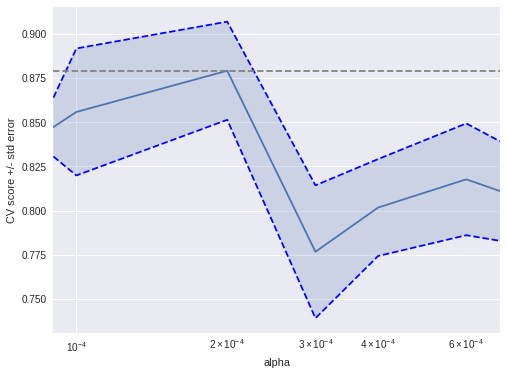

In [33]:
# We use 10-fold cross-validation to evaluate the models
alphas = [0.00009, 1e-4, 0.0002, 0.0003, 0.0004, 0.0006, 0.0007] #we get between 5 and 19 features using these values of alpha
n_folds = 5
scores = list()
scores_std = list()

for alpha in alphas:
    lasso = Lasso(alpha=alpha,fit_intercept=True, max_iter=100000, tol=0.0001)
    lasso_fit = lasso.fit(X,y)
    #print y.sum()
    #print len(y)
    cv = ShuffleSplit(n_splits=n_folds)
    this_scores = cross_val_score(lasso_fit, X, y, scoring='roc_auc', cv=cv, n_jobs=1)
    print this_scores
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)
print scores

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

######  Selection of alpha depending on the validation score
Depending on the way the test group is picked, we have different values of alpha. 
So we test the model with three different values of alpha: [0.0001, 0.0002, 0.0003]

In [45]:
# Extract the set of relevant features and their weight, alpha = 0.0002
features_indice = list()
features_weight = list()
features = list()

for i in range (len(coef_lasso[2])):
    if coef_lasso[2][i] != 0.:
        features_indice.append(i)

print len(features_indice)

for i in range (len(all_pairoutcomes)):
    if i in features_indice:
        features.append(all_pairoutcomes[i])
        features_weight.append((all_pairoutcomes[i], coef_lasso[2][i]))
    
print len(features)
print len(features_weight)
print features[0]

16
16
16
35104074


In [35]:
# Build the new frequency tables
def make_lsd_training_table_reduced(features, pos_drugs = None, neg_drugs = None):

    # we map positive and negative drugs from their concept_code to their concept_id
    pos_drugs_mapped = list()
    for pos_drug in pos_drugs:
        pos_drugs_mapped.append(drug_mapping[pos_drug])
        
    neg_drugs_mapped = list()
    for neg_drug in neg_drugs:
        neg_drugs_mapped.append(drug_mapping[neg_drug])
        
    outcomes = np.concatenate((np.ones(len(pos_drugs),np.bool), np.zeros(len(neg_drugs),np.bool)))
    
    training_drugs = pos_drugs_mapped + neg_drugs_mapped
    
    # build the adverse events frequency table
    ae_frequencies_training = np.zeros((len(pos_drugs)+len(neg_drugs),len(features)))
    
    for r in aeolus_drugReactionCounts['results']:
        if not r['drug_concept_id'] in training_drugs:
            continue
        if not r['outcome_concept_id'] in features:
            continue
        
        
        i = training_drugs.index(r['drug_concept_id'])
        j = features.index(r['outcome_concept_id'])
        
        frequency = float(r['nreports'])/float(r['ndrugreports'])
        
        ae_frequencies_training[i,j] = frequency
                    
    return ae_frequencies_training, outcomes


# Build the frequency table for drugpairs
def make_lsd_testing_table_reduced(features):
    ae_frequencies_ddi_testing = np.zeros((len(all_drugpairs),len(features)))
    
    for r in tqdm(aeolus_drugpairReactionCounts['results']):
        
        drugpair = (r['drug1_concept_id'],r['drug2_concept_id'])
        if r['outcome_concept_id'] in features:
            x_index = all_drugpairs.index(drugpair)
            y_index = features.index(r['outcome_concept_id'])
            
            frequency = float(r['n_d1d2ae'])/float(r['n_d1d2'])
            #print frequency
            
            ae_frequencies_ddi_testing[x_index,y_index] = frequency    
                
    return ae_frequencies_ddi_testing

In [46]:
X_reduced, y_reduced = make_lsd_training_table_reduced(features, pos_controls, neg_controls)

print X_reduced.shape
print y_reduced.shape

(272, 16)
(272,)


In [47]:
X_test_reduced = make_lsd_testing_table_reduced(features)

100%|██████████| 1313184/1313184 [03:15<00:00, 6710.45it/s] 


In [48]:
print features[0]
print X_test_reduced.shape
#print X_test_reduced[2]

35104074
(39800, 16)


## Build the latent signal detection model (i.e hypertension's fingerprint)

In [39]:
# We use a Logistic Regression Binary classifier: each drug or drug pair is represented by a combination of AEs and their weight (beta coefficient)
# If a drug is above a certain threshold, we classify it as causing hypertension

def score(features_weight, X_test):
    score = list()
    
    for drugpair in X_test:
        #print drugpair
        drugpair_score = 0
        for i in range (0, len(features)):
            drugpair_score += drugpair[i] * features_weight[i][1]
        score.append(drugpair_score)
    
    return score

def y_pred_FAERS(drug_mapping):
    
    y_pred = np.zeros((len(scores)))
    pos_drugs_mapped = list()
    
    for pos_drug in pos_controls:
        if pos_drug not in drug_mapping:
            continue
        
    pos_drugs_mapped.append(drug_mapping[pos_drug])
    
    # if a drugpair has a drug known to be a positive control then we predict that the drugpair will lead to the AE
    for drugpair in all_drugpairs:         
        for drug in drugpair:
            if drug in pos_drugs_mapped:
                y_pred[all_drugpairs.index(drugpair)] = 1
                
    return y_pred

def y_pred_va():
    
    y_pred = np.zeros((len(scores)))
    
    # if a drugpair has a drug known to be a positive control then we predict that the drugpair will lead to the AE
    for drugpair in all_drugpairs:         
        if drugpair in va_omop_ddi :
            y_pred[all_drugpairs.index(drugpair)] = 1
    
    return y_pred

def predict_ddi(scores, threshold):
    
    predictions = np.zeros((len(scores)))
    for score in scores:
        if (score > threshold):
            predictions[scores.index(score)] = 1
    print sum(predictions)
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    y_pred_VA = y_pred_va()
    
    print "Number of positive predictions from FAERS:",np.sum(y_pred_Faers)
    print "Number of positive predictions from the VA:",np.sum(y_pred_VA)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=scores)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=scores)
    
    print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=scores)
    fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=scores)
    
    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predictions
            

39800
4.44602939367
4487.0
Number of positive predictions from FAERS: 398.0
Number of positive predictions from the VA: 14.0
FAERS drugpairs ROC: 0.718984496616
VA drugpairs ROC: 0.590518200946


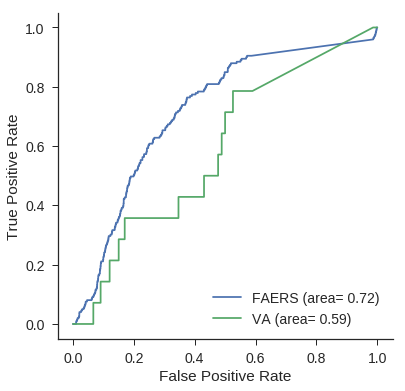

In [40]:
scores = score(features_weight, X_test_reduced)
print len(scores)
print scores[0]

threshold = 5
predictions = predict_ddi(scores, threshold)

  1%|          | 11938/1313184 [00:00<00:10, 119378.98it/s]

0.0001
10


100%|██████████| 1313184/1313184 [01:49<00:00, 12032.30it/s]


(39800, 10)
5591.0


  0%|          | 0/1313184 [00:00<?, ?it/s]

Number of positive predictions from FAERS: 398.0
Number of positive predictions from the VA: 14.0
FAERS drugpairs ROC: 0.733398860706
VA drugpairs ROC: 0.569460901538
0.0002
9


100%|██████████| 1313184/1313184 [01:58<00:00, 11052.17it/s]


(39800, 9)
3967.0


  0%|          | 0/1313184 [00:00<?, ?it/s]

Number of positive predictions from FAERS: 398.0
Number of positive predictions from the VA: 14.0
FAERS drugpairs ROC: 0.728481757042
VA drugpairs ROC: 0.55855972309
0.0003
8


100%|██████████| 1313184/1313184 [01:56<00:00, 11226.62it/s]


(39800, 8)
2525.0
Number of positive predictions from FAERS: 398.0
Number of positive predictions from the VA: 14.0
FAERS drugpairs ROC: 0.718124657091
VA drugpairs ROC: 0.552218655521


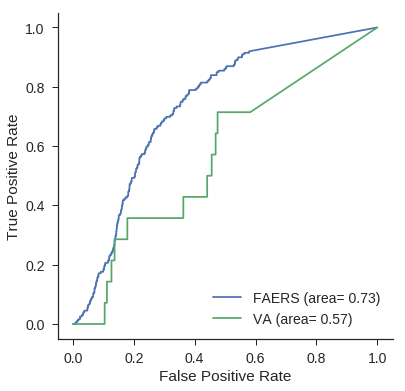

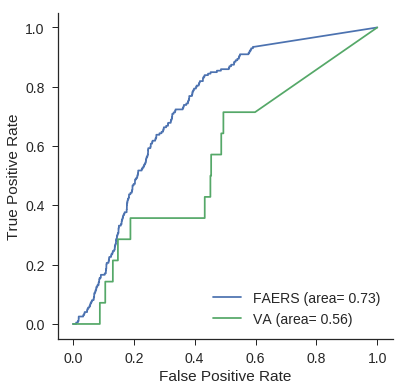

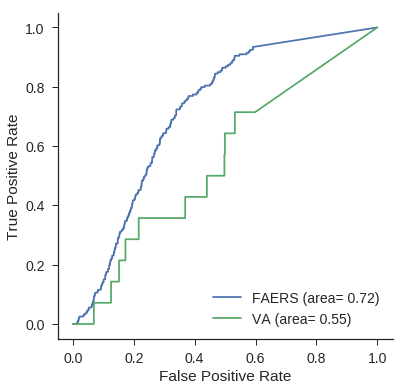

In [47]:
# Loop to test all three models
# We use a Logistic Regression Binary classifier: each drug or drug pair is represented by a combination of AEs and their weight (beta coefficient)
# If a drug is above a certain threshold, we classify it as causing hypertension

alphas_selected = [0.0001, 0.0002, 0.0003]
threshold = 4

for alpha in alphas_selected:
    print alpha
    
    #Extraction of features
    features_indice = list()
    features_weight = list()
    features = list()

    for i in range (len(coef_lasso[2+alphas_selected.index(alpha)])):
        if coef_lasso[2+alphas_selected.index(alpha)][i] != 0.:
            features_indice.append(i)

    for i in range (len(all_pairoutcomes)):
        if i in features_indice:
            features.append(all_pairoutcomes[i])
            features_weight.append((all_pairoutcomes[i], coef_lasso[2+alphas_selected.index(alpha)][i]))
    
    print len(features)
    
    #Construction of the new testing frequency table
    X_test_reduced = make_lsd_testing_table_reduced(features)
    print X_test_reduced.shape
    
    #Fingerprint construction
    scores = score(features_weight, X_test_reduced)
    predictions = predict_ddi(scores, threshold)


In [41]:
# Random Forest Classifier after the L1 reduction of features

def drugpair_predictions_reduced(X, y, X_test):
    
    # can't use oob after L1 regularization
    rf = RandomForestClassifier(n_estimators = 100, oob_score=False, random_state=12)
    rf.fit(X,y) #Build a forest of trees from the training set (X, y).
    
    predictions_proba = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test) #predict class for X_test
    print "Mean accuracy on the given test data and labels: ", rf.score(X,y)  
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    y_pred_VA = y_pred_va()
    
    predicted_ddi = sorted(zip(predictions_proba, all_drugpairs))
    predicted_ddi.reverse()
    i=0
    while predicted_ddi[i][0]>0.5:
        i+=1
    predicted_ddi = predicted_ddi[:i]
            
    #(i.e with at least one drug known to have hypertension as a side effect)
    print "Number of positive predictions:",np.sum(y_pred_Faers)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=predictions_proba)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=predictions_proba)
    
    print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=predictions_proba)
    fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=predictions_proba)

    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predicted_ddi

Mean accuracy on the given test data and labels:  0.996323529412
Number of positive predictions: 398.0
FAERS drugpairs ROC: 0.729876349924
VA drugpairs ROC: 0.571128753115
16772


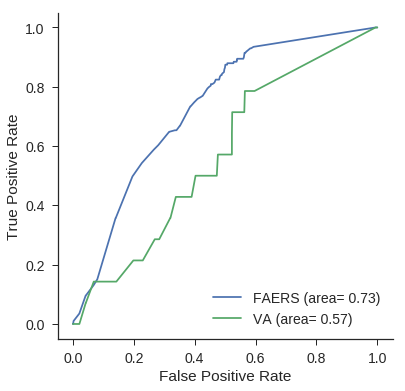

In [49]:
predicted_ddi = drugpair_predictions_reduced(X_reduced,y_reduced,X_test_reduced)
print len(predicted_ddi)

In [43]:
def drugpair_predictions(X,y,X_test):  
    
    rf = RandomForestClassifier(n_estimators = 100, oob_score=True, random_state=12)
    rf.fit(X,y) #Build a forest of trees from the training set (X, y).
    
    print "Number of estimators: ", len(rf.estimators_)
    
    predictions_proba = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test) #predict class for X_test
    print "Mean accuracy on the given test data and labels: ", rf.score(X,y)   

    oob_predictions = rf.oob_decision_function_[:,1]
    oob_predictions[ np.where( np.isnan(oob_predictions) == True)[0]] = 0
    
    #roc_auc_score computes the area under the ROC curve
    print "OOB ROC:",roc_auc_score(y_true=y, y_score=oob_predictions)
    fprOOB, tprOOB, _ = roc_curve(y_true=y,y_score=oob_predictions)
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    y_pred_VA = y_pred_va()
    
    predicted_ddi = sorted(zip(predictions_proba, all_drugpairs))
    predicted_ddi.reverse()
    i=0
    while predicted_ddi[i][0]>0.5:
        i+=1
    predicted_ddi = predicted_ddi[:i]
            
    #(i.e with at least one drug known to have hypertension as a side effect)
    print "Number of positive predictions FAERS:",np.sum(y_pred_Faers)
    print "Number of ddi predictions (with a probability > 0,5): ", len(predicted_ddi)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=predictions_proba)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=predictions_proba)
    
    print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=predictions_proba)
    fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=predictions_proba)
    
    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprOOB,tprOOB,label='OOB (area= %0.2f)' % auc(fprOOB,tprOOB))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predicted_ddi

Number of estimators:  100
Mean accuracy on the given test data and labels:  0.996323529412
OOB ROC: 0.8840625
Number of positive predictions FAERS: 398.0
Number of ddi predictions (with a probability > 0,5):  10000
FAERS drugpairs ROC: 0.68223955675
VA drugpairs ROC: 0.605223660871


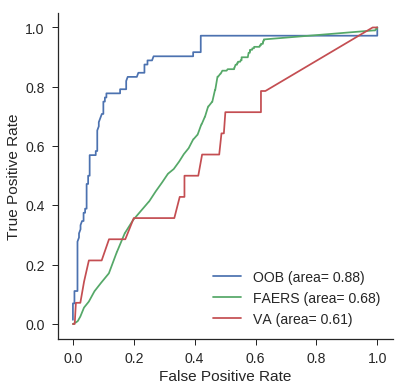

In [44]:
pred_ddi = drugpair_predictions(X,y,X_test)

## DDI predictions

In [85]:
#Treatment of the predictions
final_predictions = list()

pos_drugs_mapped = list()
for pos_drug in pos_controls:
    if pos_drug not in drug_mapping:
        continue
        
    pos_drugs_mapped.append(drug_mapping[pos_drug])

# Removing the pairs where at least one of the drugs is known to be responsible for hypertension alone
for prob, drugpair in predicted_ddi:
    if (drugpair[0] not in pos_drugs_mapped):
        if (drugpair[1] not in pos_drugs_mapped):
            # All drugpairs are twice in the list ((a,b) and (b,a)), we only keep one
            if drugpair[0] > drugpair[1]:
                final_predictions.append(drugpair)

print len(predicted_ddi)
print len(final_predictions)                
top_ddi = final_predictions[:500]
#print top_ddi

16772
5855


In [51]:
# Pull the top prediction
pair = top_ddi[0]
pair2 = top_ddi[1]
print pair
print pair2
print concept2name[pair[0]], concept2name[pair[1]]
print concept2name[pair2[0]], concept2name[pair2[1]]

(970250, 735979)
(19092849, 956874)
Spironolactone Risperidone
Magnesium Chloride Furosemide


## Corroborate drugpair predictions using OHDSI data
Analysis of the top predicted DDIs.
Method: Creation of cohorts of patients using the OHDSI API.
Criteria: Patients exposed to either drug of a predicted drugpair alone and patients exposed to both within a 30 days interval.
All patients must have had their blood pressure measured within 30 days of their last drug intake. 

In [69]:
map_id_name, map_name_id = ohdsi.mapping()

http://api.ohdsi.org/WebAPI/cohortdefinition


In [80]:
def delete_cohort(cohort_id):
    """
    Deletes the cohort
    id: integer, the cohort's id
    """

    url = 'http://api.ohdsi.org/WebAPI/cohortdefinition/' + '%s' %cohort_id
    r = requests.delete(url)
    #print r.url
    #print r.text
    
    print "Cohort was deleted with exit status %i " %r.status_code
    return r.status_code

In [86]:
# Retrieve patient information for the top 50 ddi predictions
qualifying_drugpairs = list()

for drugpair in tqdm(top_ddi):
    
    # Creation of the first cohort with exposure to both drugs of the drugpair within 7 days
    concept1 = ohdsi.get_concept_info(drugpair[0])
    concept2 = ohdsi.get_concept_info(drugpair[1])
    
    data = ohdsi.cohort_definition_2D(concept1, concept2)
    status = ohdsi.create_cohort(data)
    
    # Update the mapping dicionaries
    cohorts = ohdsi.get_cohorts()
    for cohort in cohorts:
        if cohort['name'] == "%s_%s"%(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"]):
            map_id_name[cohort['id']] =  cohort['name']
            map_name_id[cohort['name']] = cohort['id']
    
    cohort_id = map_name_id["%s_%s"%(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"])]
    info = ohdsi.generate_cohort(cohort_id)
    
    patients = ohdsi.getAlldistinctPatients(cohort_id)
    print len(patients)
    
    if(len(patients)<30):
        print "Not enough patients for cohort %s_%s" %(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"])
        status_delete = delete_cohort(cohort_id)
    else:
        print "Enough patients for cohort %s_%s" %(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"])
        qualifying_drugpairs.append(drugpair)


  0%|          | 0/500 [00:00<?, ?it/s]

http://api.ohdsi.org/WebAPI/cohortdefinition
A cohort with the same name already exists, please choose another name
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/905158/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905158/members/1-30000



  0%|          | 1/500 [00:05<43:41,  5.25s/it]

109
Enough patients for cohort Spironolactone_Risperidone


http://api.ohdsi.org/WebAPI/cohortdefinition
A cohort with the same name already exists, please choose another name
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905159/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905159/members/1-30000



  0%|          | 2/500 [00:11<46:03,  5.55s/it]

37
Enough patients for cohort Magnesium Chloride_Furosemide


http://api.ohdsi.org/WebAPI/cohortdefinition
A cohort with the same name already exists, please choose another name
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905208/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905208/members/1-30000



  1%|          | 3/500 [00:16<44:59,  5.43s/it]

92
Enough patients for cohort Amoxicillin_Risperidone


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905256/generate/1PCT



  1%|          | 4/500 [00:21<43:16,  5.24s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905256/members/1-30000
0
Not enough patients for cohort zoledronic acid_Allopurinol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905257/generate/1PCT



  1%|          | 5/500 [00:24<37:45,  4.58s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905257/members/1-30000
0
Not enough patients for cohort Vancomycin_Amitriptyline
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905258/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905258/members/1-30000
0
Not enough patients for cohort Glyburide_Diazepam



  1%|          | 6/500 [00:27<34:52,  4.24s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905259/generate/1PCT



  1%|▏         | 7/500 [00:30<31:57,  3.89s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905259/members/1-30000
0
Not enough patients for cohort pioglitazone_heparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905260/generate/1PCT



  2%|▏         | 8/500 [00:34<31:44,  3.87s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905260/members/1-30000
0
Not enough patients for cohort formoterol_Acetaminophen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905261/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905261/members/1-30000
0
Not enough patients for cohort Acetaminophen_lamotrigine



  2%|▏         | 9/500 [00:38<31:32,  3.85s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905262/generate/1PCT



  2%|▏         | 10/500 [00:41<30:07,  3.69s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905262/members/1-30000
0
Not enough patients for cohort olanzapine_topiramate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905263/generate/1PCT



  2%|▏         | 11/500 [00:45<30:43,  3.77s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905263/members/1-30000
0
Not enough patients for cohort Thalidomide_Amlodipine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905264/generate/1PCT



  2%|▏         | 12/500 [00:48<28:52,  3.55s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905264/members/1-30000
0
Not enough patients for cohort Vitamin A_valsartan
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905265/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905265/members/1-30000
0
Not enough patients for cohort Enalapril_Oxycodone



  3%|▎         | 13/500 [00:51<27:27,  3.38s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905266/generate/1PCT



  3%|▎         | 14/500 [00:55<28:18,  3.49s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905266/members/1-30000
0
Not enough patients for cohort Albuterol_lamotrigine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905267/generate/1PCT



  3%|▎         | 15/500 [00:58<27:37,  3.42s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905267/members/1-30000
0
Not enough patients for cohort Methadone_cyclobenzaprine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905268/generate/1PCT



  3%|▎         | 16/500 [01:02<27:42,  3.43s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905268/members/1-30000
0
Not enough patients for cohort topiramate_Carbamazepine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905269/generate/1PCT



  3%|▎         | 17/500 [01:06<28:39,  3.56s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905269/members/1-30000
0
Not enough patients for cohort topiramate_Levetiracetam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905270/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905270/members/1-30000
0
Not enough patients for cohort Diazepam_lamotrigine



  4%|▎         | 18/500 [01:09<28:14,  3.51s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905271/generate/1PCT



  4%|▍         | 19/500 [01:13<29:54,  3.73s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905271/members/1-30000
0
Not enough patients for cohort Calcium Chloride / Glucose / Lactate / Magnesium Chloride / Sodium Chloride Intraperitoneal Solution_heparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905272/generate/1PCT



  4%|▍         | 20/500 [01:16<28:06,  3.51s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905272/members/1-30000
0
Not enough patients for cohort Calcium_Trazodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905273/generate/1PCT



  4%|▍         | 21/500 [01:19<26:50,  3.36s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905273/members/1-30000
0
Not enough patients for cohort Fluconazole_Acyclovir
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905274/generate/1PCT



  4%|▍         | 22/500 [01:22<25:48,  3.24s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905274/members/1-30000
0
Not enough patients for cohort rosiglitazone_Ramipril
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905275/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905275/members/1-30000
0
Not enough patients for cohort Simvastatin_Clozapine



  5%|▍         | 23/500 [01:25<25:04,  3.15s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905276/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905276/members/1-30000
0
Not enough patients for cohort Amlodipine_Levetiracetam



  5%|▍         | 24/500 [01:29<26:54,  3.39s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905277/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905277/members/1-30000
0
Not enough patients for cohort Diphenhydramine_Valproate



  5%|▌         | 25/500 [01:33<27:07,  3.43s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905278/generate/1PCT



  5%|▌         | 26/500 [01:36<27:32,  3.49s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905278/members/1-30000
0
Not enough patients for cohort Acetaminophen_Levetiracetam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905279/generate/1PCT



  5%|▌         | 27/500 [01:40<27:27,  3.48s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905279/members/1-30000
0
Not enough patients for cohort Furosemide_Levetiracetam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905280/generate/1PCT



  6%|▌         | 28/500 [01:43<26:51,  3.41s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905280/members/1-30000
0
Not enough patients for cohort Furosemide_lamotrigine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905281/generate/1PCT



  6%|▌         | 29/500 [01:47<27:14,  3.47s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905281/members/1-30000
0
Not enough patients for cohort pantoprazole_Levetiracetam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905282/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905282/members/1-30000
0
Not enough patients for cohort Omeprazole_Levetiracetam



  6%|▌         | 30/500 [01:50<27:33,  3.52s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905283/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905283/members/1-30000



  6%|▌         | 31/500 [01:54<26:44,  3.42s/it]

0
Not enough patients for cohort olmesartan_tiotropium
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905284/generate/1PCT



  6%|▋         | 32/500 [01:57<25:44,  3.30s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905284/members/1-30000
0
Not enough patients for cohort Multivitamin preparation_Levetiracetam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905285/generate/1PCT



  7%|▋         | 33/500 [02:00<26:09,  3.36s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905285/members/1-30000
0
Not enough patients for cohort Folic Acid_rofecoxib
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905286/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905286/members/1-30000
0
Not enough patients for cohort Folic Acid_Valproate



  7%|▋         | 34/500 [02:04<26:33,  3.42s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905287/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905287/members/1-30000



  7%|▋         | 35/500 [02:07<26:52,  3.47s/it]

0
Not enough patients for cohort Cyclosporine_mycophenolate mofetil
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905288/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905288/members/1-30000



  7%|▋         | 36/500 [02:11<26:45,  3.46s/it]

0
Not enough patients for cohort Vitamin A_Bupropion
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905289/generate/1PCT



  7%|▋         | 37/500 [02:15<29:28,  3.82s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905289/members/1-30000
0
Not enough patients for cohort Levofloxacin_Enalapril
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905290/generate/1PCT



  8%|▊         | 38/500 [02:19<28:58,  3.76s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905290/members/1-30000
0
Not enough patients for cohort Vancomycin_atorvastatin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905291/generate/1PCT



  8%|▊         | 39/500 [02:23<29:06,  3.79s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905291/members/1-30000
0
Not enough patients for cohort Vancomycin_Simvastatin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905292/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905292/members/1-30000



  8%|▊         | 40/500 [02:26<27:39,  3.61s/it]

0
Not enough patients for cohort Vancomycin_Nitroglycerin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905293/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905293/members/1-30000


  8%|▊         | 41/500 [02:29<26:57,  3.52s/it]


0
Not enough patients for cohort Vancomycin_Enalapril
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905294/generate/1PCT



  8%|▊         | 42/500 [02:33<27:48,  3.64s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905294/members/1-30000
0
Not enough patients for cohort Vancomycin_Amlodipine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905295/generate/1PCT



  9%|▊         | 43/500 [02:37<27:04,  3.55s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905295/members/1-30000
0
Not enough patients for cohort Vancomycin_clopidogrel
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905296/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905296/members/1-30000
0
Not enough patients for cohort Vancomycin_Nifedipine



  9%|▉         | 44/500 [02:39<25:21,  3.34s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905297/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905297/members/1-30000
0
Not enough patients for cohort Vancomycin_Amiodarone



  9%|▉         | 45/500 [02:42<24:35,  3.24s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905298/generate/1PCT



  9%|▉         | 46/500 [02:45<24:01,  3.17s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905298/members/1-30000
0
Not enough patients for cohort Vancomycin_Lisinopril
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905299/generate/1PCT



  9%|▉         | 47/500 [02:49<24:08,  3.20s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905299/members/1-30000
0
Not enough patients for cohort Vancomycin_Albuterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905300/generate/1PCT



 10%|▉         | 48/500 [02:52<25:13,  3.35s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905300/members/1-30000
0
Not enough patients for cohort Vancomycin_Spironolactone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905301/generate/1PCT



 10%|▉         | 49/500 [02:56<26:00,  3.46s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905301/members/1-30000
0
Not enough patients for cohort Vancomycin_Famotidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905302/generate/1PCT



 10%|█         | 50/500 [02:59<25:37,  3.42s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905302/members/1-30000
0
Not enough patients for cohort Acyclovir_heparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905303/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905303/members/1-30000
0
Not enough patients for cohort glimepiride_Aspirin



 10%|█         | 51/500 [03:03<26:00,  3.47s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905304/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905304/members/1-30000
0
Not enough patients for cohort glimepiride_Clonazepam



 10%|█         | 52/500 [03:08<29:26,  3.94s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905305/generate/1PCT



 11%|█         | 53/500 [03:11<28:12,  3.79s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905305/members/1-30000
0
Not enough patients for cohort rosiglitazone_levothyroxine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905306/generate/1PCT



 11%|█         | 54/500 [03:15<27:28,  3.70s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905306/members/1-30000
0
Not enough patients for cohort atorvastatin_salmeterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905307/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905307/members/1-30000



 11%|█         | 55/500 [03:18<25:18,  3.41s/it]

0
Not enough patients for cohort pioglitazone_Amitriptyline
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905308/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905308/members/1-30000



 11%|█         | 56/500 [03:20<23:21,  3.16s/it]

0
Not enough patients for cohort Metformin_heparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905309/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905309/members/1-30000



 11%|█▏        | 57/500 [03:24<23:48,  3.22s/it]

0
Not enough patients for cohort Insulin Glargine_heparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905310/generate/1PCT



 12%|█▏        | 58/500 [03:27<24:32,  3.33s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905310/members/1-30000
0
Not enough patients for cohort Insulin Glargine_Amiodarone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905311/generate/1PCT



 12%|█▏        | 59/500 [03:31<24:24,  3.32s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905311/members/1-30000
0
Not enough patients for cohort levothyroxine_Levetiracetam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905312/generate/1PCT



 12%|█▏        | 60/500 [03:34<24:42,  3.37s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905312/members/1-30000
0
Not enough patients for cohort Clonidine_Baclofen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905313/generate/1PCT



 12%|█▏        | 61/500 [03:38<26:20,  3.60s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905313/members/1-30000
0
Not enough patients for cohort heparin_Enalapril
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905314/generate/1PCT



 12%|█▏        | 62/500 [03:42<26:53,  3.68s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905314/members/1-30000
0
Not enough patients for cohort heparin_Ramipril
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905315/generate/1PCT



 13%|█▎        | 63/500 [03:46<27:19,  3.75s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905315/members/1-30000
0
Not enough patients for cohort heparin_Diltiazem
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905316/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905316/members/1-30000



 13%|█▎        | 64/500 [03:49<26:33,  3.66s/it]

0
Not enough patients for cohort heparin_Enoxaparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905317/generate/1PCT



 13%|█▎        | 65/500 [03:52<24:51,  3.43s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905317/members/1-30000
0
Not enough patients for cohort heparin_Allopurinol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905318/generate/1PCT



 13%|█▎        | 66/500 [03:56<26:15,  3.63s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905318/members/1-30000
0
Not enough patients for cohort heparin_Spironolactone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905319/generate/1PCT



 13%|█▎        | 67/500 [03:59<24:47,  3.44s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905319/members/1-30000
0
Not enough patients for cohort heparin_Trazodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905320/generate/1PCT



 14%|█▎        | 68/500 [04:03<24:30,  3.40s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905320/members/1-30000
0
Not enough patients for cohort Nitroglycerin_Nifedipine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905321/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905321/members/1-30000
0
Not enough patients for cohort Diltiazem_Diphenhydramine



 14%|█▍        | 69/500 [04:06<25:05,  3.49s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905322/generate/1PCT



 14%|█▍        | 70/500 [04:11<26:22,  3.68s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905322/members/1-30000
0
Not enough patients for cohort clopidogrel_Nifedipine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905323/generate/1PCT



 14%|█▍        | 71/500 [04:14<26:22,  3.69s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905323/members/1-30000
0
Not enough patients for cohort Lisinopril_quetiapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905324/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905324/members/1-30000
0
Not enough patients for cohort Allopurinol_salmeterol



 14%|█▍        | 72/500 [04:19<28:04,  3.93s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905325/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905325/members/1-30000
0
Not enough patients for cohort fexofenadine_quetiapine



 15%|█▍        | 73/500 [04:23<29:18,  4.12s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905326/generate/1PCT



 15%|█▍        | 74/500 [04:27<29:08,  4.11s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905326/members/1-30000
0
Not enough patients for cohort salmeterol_quetiapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905327/generate/1PCT



 15%|█▌        | 75/500 [04:30<27:01,  3.81s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905327/members/1-30000
0
Not enough patients for cohort Diphenhydramine_venlafaxine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905328/generate/1PCT



 15%|█▌        | 76/500 [04:35<27:26,  3.88s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905328/members/1-30000
0
Not enough patients for cohort Acetaminophen_Clozapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905329/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905329/members/1-30000



 15%|█▌        | 77/500 [04:38<25:33,  3.62s/it]

0
Not enough patients for cohort Oxycodone_Methylphenidate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905330/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905330/members/1-30000



 16%|█▌        | 78/500 [04:41<25:37,  3.64s/it]

0
Not enough patients for cohort tiotropium_Clonazepam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905331/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905331/members/1-30000



 16%|█▌        | 79/500 [04:45<25:12,  3.59s/it]

0
Not enough patients for cohort Ondansetron_Mirtazapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905332/generate/1PCT



 16%|█▌        | 80/500 [04:48<25:29,  3.64s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905332/members/1-30000
0
Not enough patients for cohort Spironolactone_tamsulosin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905333/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905333/members/1-30000



 16%|█▌        | 81/500 [04:53<28:02,  4.01s/it]

0
Not enough patients for cohort quetiapine_Carbamazepine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905334/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905334/members/1-30000



 16%|█▋        | 82/500 [04:57<27:48,  3.99s/it]

0
Not enough patients for cohort topiramate_Risperidone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905335/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905335/members/1-30000
0
Not enough patients for cohort olmesartan_Fenofibrate



 17%|█▋        | 83/500 [05:04<32:22,  4.66s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905336/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905336/members/1-30000
0
Not enough patients for cohort Calcium Chloride / Glucose / Lactate / Magnesium Chloride / Sodium Chloride Intraperitoneal Solution_Aspirin



 17%|█▋        | 84/500 [05:11<38:40,  5.58s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905337/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905337/members/1-30000



 17%|█▋        | 85/500 [05:18<41:25,  5.99s/it]

0
Not enough patients for cohort Multivitamin preparation_Sulfamethoxazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905338/generate/1PCT



 17%|█▋        | 86/500 [05:22<36:52,  5.34s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905338/members/1-30000
0
Not enough patients for cohort Multivitamin preparation_rosiglitazone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905339/generate/1PCT



 17%|█▋        | 87/500 [05:26<33:40,  4.89s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905339/members/1-30000
0
Not enough patients for cohort Multivitamin preparation_Cyclophosphamide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905340/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905340/members/1-30000
0
Not enough patients for cohort Multivitamin preparation_rofecoxib



 18%|█▊        | 88/500 [05:29<30:48,  4.49s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905341/generate/1PCT



 18%|█▊        | 89/500 [05:32<27:52,  4.07s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905341/members/1-30000
0
Not enough patients for cohort Insulin_Cyclosporine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905342/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905342/members/1-30000



 18%|█▊        | 90/500 [05:36<26:59,  3.95s/it]

0
Not enough patients for cohort Insulin_Azithromycin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905343/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905343/members/1-30000
0
Not enough patients for cohort Insulin_Ibuprofen



 18%|█▊        | 91/500 [05:41<28:50,  4.23s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905344/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905344/members/1-30000
0
Not enough patients for cohort Insulin_Diphenhydramine



 18%|█▊        | 92/500 [05:46<29:39,  4.36s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905345/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905345/members/1-30000
0
Not enough patients for cohort Insulin_Famotidine



 19%|█▊        | 93/500 [05:50<29:49,  4.40s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905346/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905346/members/1-30000
0
Not enough patients for cohort Folic Acid_Glipizide



 19%|█▉        | 94/500 [05:54<29:12,  4.32s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905347/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905347/members/1-30000
0
Not enough patients for cohort Folic Acid_Glyburide



 19%|█▉        | 95/500 [05:59<29:16,  4.34s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905348/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905348/members/1-30000
0
Not enough patients for cohort Folic Acid_sildenafil



 19%|█▉        | 96/500 [06:04<30:39,  4.55s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905349/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905349/members/1-30000
0
Not enough patients for cohort Folic Acid_montelukast



 19%|█▉        | 97/500 [06:08<29:17,  4.36s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905350/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905350/members/1-30000
0
Not enough patients for cohort Folic Acid_cyclobenzaprine



 20%|█▉        | 98/500 [06:12<29:56,  4.47s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905351/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905351/members/1-30000
0
Not enough patients for cohort Potassium Chloride_Amoxicillin



 20%|█▉        | 99/500 [06:18<31:09,  4.66s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905352/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905352/members/1-30000
0
Not enough patients for cohort Potassium Chloride_sildenafil



 20%|██        | 100/500 [06:22<30:34,  4.59s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905353/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905353/members/1-30000
0
Not enough patients for cohort Potassium Chloride_tamsulosin



 20%|██        | 101/500 [06:26<28:28,  4.28s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905354/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905354/members/1-30000
0
Not enough patients for cohort Calcium Carbonate_Lisinopril



 20%|██        | 102/500 [06:29<27:42,  4.18s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905355/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905355/members/1-30000
0
Not enough patients for cohort Ascorbic Acid_Amlodipine



 21%|██        | 103/500 [06:33<26:52,  4.06s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905356/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905356/members/1-30000
0
Not enough patients for cohort Cyclosporine_Warfarin



 21%|██        | 104/500 [06:38<27:28,  4.16s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905357/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905357/members/1-30000
0
Not enough patients for cohort Vitamin D_clopidogrel



 21%|██        | 105/500 [06:44<31:48,  4.83s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905358/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905358/members/1-30000
0
Not enough patients for cohort Vitamin A_rosuvastatin



 21%|██        | 106/500 [06:49<32:50,  5.00s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905359/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905359/members/1-30000
0
Not enough patients for cohort Vitamin A_Furosemide



 21%|██▏       | 107/500 [06:56<35:48,  5.47s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905360/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905360/members/1-30000
0
Not enough patients for cohort Sulfamethoxazole_Digoxin



 22%|██▏       | 108/500 [07:03<39:22,  6.03s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905361/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905361/members/1-30000



 22%|██▏       | 109/500 [07:10<40:39,  6.24s/it]

0
Not enough patients for cohort Sulfamethoxazole_Loratadine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905362/generate/1PCT



 22%|██▏       | 110/500 [07:16<39:13,  6.03s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905362/members/1-30000
0
Not enough patients for cohort Fluconazole_Metoclopramide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905363/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905363/members/1-30000



 22%|██▏       | 111/500 [07:21<38:20,  5.91s/it]

0
Not enough patients for cohort Levofloxacin_Vancomycin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905364/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905364/members/1-30000
0
Not enough patients for cohort Levofloxacin_Glipizide



 22%|██▏       | 112/500 [07:26<36:40,  5.67s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905365/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905365/members/1-30000
0
Not enough patients for cohort Levofloxacin_Clonidine



 23%|██▎       | 113/500 [07:33<38:38,  5.99s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905366/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905366/members/1-30000
0
Not enough patients for cohort Levofloxacin_Nitroglycerin



 23%|██▎       | 114/500 [07:37<35:12,  5.47s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905367/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905367/members/1-30000



 23%|██▎       | 115/500 [07:43<34:37,  5.40s/it]

0
Not enough patients for cohort Levofloxacin_carvedilol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905368/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905368/members/1-30000
0
Not enough patients for cohort Levofloxacin_Digoxin



 23%|██▎       | 116/500 [07:48<34:33,  5.40s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905369/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905369/members/1-30000
0
Not enough patients for cohort Levofloxacin_Amiodarone



 23%|██▎       | 117/500 [07:52<32:24,  5.08s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905370/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905370/members/1-30000
0
Not enough patients for cohort Levofloxacin_rofecoxib



 24%|██▎       | 118/500 [07:57<31:11,  4.90s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905371/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905371/members/1-30000
0
Not enough patients for cohort Levofloxacin_Hydrocodone



 24%|██▍       | 119/500 [08:02<31:36,  4.98s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905372/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905372/members/1-30000
0
Not enough patients for cohort Levofloxacin_Spironolactone



 24%|██▍       | 120/500 [08:07<30:48,  4.86s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905373/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905373/members/1-30000
0
Not enough patients for cohort Levofloxacin_Docusate



 24%|██▍       | 121/500 [08:12<31:35,  5.00s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905374/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905374/members/1-30000



 24%|██▍       | 122/500 [08:18<33:26,  5.31s/it]

0
Not enough patients for cohort Levofloxacin_Baclofen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905375/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905375/members/1-30000
0
Not enough patients for cohort Azithromycin_Nitroglycerin



 25%|██▍       | 123/500 [08:24<35:21,  5.63s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905376/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905376/members/1-30000
0
Not enough patients for cohort Azithromycin_carvedilol



 25%|██▍       | 124/500 [08:30<36:04,  5.76s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905377/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905377/members/1-30000
0
Not enough patients for cohort Azithromycin_Amlodipine



 25%|██▌       | 125/500 [08:37<37:01,  5.92s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905378/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905378/members/1-30000
0
Not enough patients for cohort Azithromycin_Digoxin



 25%|██▌       | 126/500 [08:45<40:51,  6.56s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905379/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905379/members/1-30000
0
Not enough patients for cohort Azithromycin_clopidogrel



 25%|██▌       | 127/500 [08:51<40:38,  6.54s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905380/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905380/members/1-30000
0
Not enough patients for cohort Azithromycin_Diphenhydramine



 26%|██▌       | 128/500 [08:58<40:57,  6.61s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905381/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905381/members/1-30000
0
Not enough patients for cohort Azithromycin_tiotropium



 26%|██▌       | 129/500 [09:05<42:10,  6.82s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905382/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905382/members/1-30000
0
Not enough patients for cohort Azithromycin_Spironolactone



 26%|██▌       | 130/500 [09:16<48:51,  7.92s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905383/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905383/members/1-30000
0
Not enough patients for cohort Amoxicillin_Nitroglycerin



 26%|██▌       | 131/500 [09:21<43:54,  7.14s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905384/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905384/members/1-30000
0
Not enough patients for cohort Amoxicillin_Digoxin



 26%|██▋       | 132/500 [09:28<44:05,  7.19s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905385/generate/1PCT



 27%|██▋       | 133/500 [09:35<43:37,  7.13s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905385/members/1-30000
0
Not enough patients for cohort Vancomycin_carvedilol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905386/generate/1PCT



 27%|██▋       | 134/500 [09:40<38:11,  6.26s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905386/members/1-30000
0
Not enough patients for cohort Vancomycin_Digoxin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905387/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905387/members/1-30000
0
Not enough patients for cohort Vancomycin_Warfarin



 27%|██▋       | 135/500 [09:44<34:21,  5.65s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905388/generate/1PCT



 27%|██▋       | 136/500 [09:48<31:49,  5.24s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905388/members/1-30000
0
Not enough patients for cohort Vancomycin_Hydrocodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905389/generate/1PCT



 27%|██▋       | 137/500 [09:52<29:09,  4.82s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905389/members/1-30000
0
Not enough patients for cohort Acyclovir_Acetaminophen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905390/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905390/members/1-30000
0
Not enough patients for cohort Acyclovir_Aspirin



 28%|██▊       | 138/500 [09:55<26:27,  4.38s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905391/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905391/members/1-30000
0
Not enough patients for cohort Acyclovir_Furosemide



 28%|██▊       | 139/500 [09:59<24:21,  4.05s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905392/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905392/members/1-30000
0
Not enough patients for cohort glimepiride_Lisinopril



 28%|██▊       | 140/500 [10:02<23:15,  3.88s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905393/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905393/members/1-30000
0
Not enough patients for cohort Glipizide_Nitroglycerin
Cohort was deleted with exit status 204 


 28%|██▊       | 141/500 [10:06<23:21,  3.90s/it]


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905394/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905394/members/1-30000
0
Not enough patients for cohort Glyburide_Nitroglycerin



 28%|██▊       | 142/500 [10:11<24:27,  4.10s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905395/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905395/members/1-30000
0
Not enough patients for cohort Glyburide_Digoxin



 29%|██▊       | 143/500 [10:15<24:46,  4.16s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905396/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905396/members/1-30000
0
Not enough patients for cohort Glyburide_Omeprazole



 29%|██▉       | 144/500 [10:19<23:56,  4.04s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905397/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905397/members/1-30000
0
Not enough patients for cohort Alendronate_Metoprolol



 29%|██▉       | 145/500 [10:23<24:44,  4.18s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905398/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905398/members/1-30000
0
Not enough patients for cohort Alendronate_montelukast



 29%|██▉       | 146/500 [10:26<22:56,  3.89s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905399/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905399/members/1-30000
0
Not enough patients for cohort Pravastatin_Albuterol



 29%|██▉       | 147/500 [10:30<22:53,  3.89s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905400/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905400/members/1-30000
0
Not enough patients for cohort Fenofibrate_Lisinopril



 30%|██▉       | 148/500 [10:35<23:46,  4.05s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905401/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905401/members/1-30000
0
Not enough patients for cohort Fenofibrate_Metoprolol



 30%|██▉       | 149/500 [10:38<22:34,  3.86s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905402/generate/1PCT



 30%|███       | 150/500 [10:42<22:35,  3.87s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905402/members/1-30000
0
Not enough patients for cohort Fenofibrate_gabapentin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905403/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905403/members/1-30000
0
Not enough patients for cohort Fenofibrate_Alprazolam



 30%|███       | 151/500 [10:45<21:36,  3.71s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905404/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905404/members/1-30000
0
Not enough patients for cohort Insulin Lispro_atorvastatin



 30%|███       | 152/500 [10:49<21:11,  3.65s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905405/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905405/members/1-30000
0
Not enough patients for cohort Insulin Lispro_Metformin



 31%|███       | 153/500 [10:53<21:27,  3.71s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905406/generate/1PCT



 31%|███       | 154/500 [10:57<21:41,  3.76s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905406/members/1-30000
0
Not enough patients for cohort atorvastatin_Methotrexate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905407/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905407/members/1-30000
0
Not enough patients for cohort atorvastatin_Ibuprofen



 31%|███       | 155/500 [11:01<22:18,  3.88s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905408/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905408/members/1-30000
0
Not enough patients for cohort atorvastatin_Levetiracetam



 31%|███       | 156/500 [11:05<22:06,  3.85s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905409/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905409/members/1-30000
0
Not enough patients for cohort Simvastatin_heparin



 31%|███▏      | 157/500 [11:09<22:33,  3.95s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905410/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905410/members/1-30000
0
Not enough patients for cohort Simvastatin_formoterol



 32%|███▏      | 158/500 [11:12<21:47,  3.82s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905411/generate/1PCT



 32%|███▏      | 159/500 [11:17<22:40,  3.99s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905411/members/1-30000
0
Not enough patients for cohort Simvastatin_rofecoxib
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905412/generate/1PCT



 32%|███▏      | 160/500 [11:20<22:00,  3.88s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905412/members/1-30000
0
Not enough patients for cohort Simvastatin_fexofenadine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905413/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905413/members/1-30000
0
Not enough patients for cohort Simvastatin_Nicotine



 32%|███▏      | 161/500 [11:24<22:00,  3.89s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905414/generate/1PCT



 32%|███▏      | 162/500 [11:27<20:03,  3.56s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905414/members/1-30000
0
Not enough patients for cohort pioglitazone_Nitroglycerin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905415/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905415/members/1-30000



 33%|███▎      | 163/500 [11:31<20:52,  3.72s/it]

0
Not enough patients for cohort pioglitazone_Spironolactone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905416/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905416/members/1-30000
0
Not enough patients for cohort zoledronic acid_pantoprazole



 33%|███▎      | 164/500 [11:34<19:57,  3.56s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905417/generate/1PCT



 33%|███▎      | 165/500 [11:37<18:46,  3.36s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905417/members/1-30000
0
Not enough patients for cohort Teriparatide_Clonazepam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905418/generate/1PCT



 33%|███▎      | 166/500 [11:41<19:45,  3.55s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905418/members/1-30000
0
Not enough patients for cohort rosuvastatin_Acetaminophen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905419/generate/1PCT



 33%|███▎      | 167/500 [11:45<20:23,  3.68s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905419/members/1-30000
0
Not enough patients for cohort Metformin_fluticasone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905420/generate/1PCT



 34%|███▎      | 168/500 [11:48<19:41,  3.56s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905420/members/1-30000
0
Not enough patients for cohort Metformin_salmeterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905421/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905421/members/1-30000
0
Not enough patients for cohort Metformin_Famotidine



 34%|███▍      | 169/500 [11:52<18:58,  3.44s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905422/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905422/members/1-30000
0
Not enough patients for cohort Insulin Glargine_valsartan



 34%|███▍      | 170/500 [11:57<21:55,  3.99s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905423/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905423/members/1-30000
0
Not enough patients for cohort Insulin Glargine_tamsulosin



 34%|███▍      | 171/500 [12:06<31:16,  5.70s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905424/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905424/members/1-30000
0
Not enough patients for cohort levothyroxine_Clozapine



 34%|███▍      | 172/500 [12:17<39:51,  7.29s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905425/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905425/members/1-30000
0
Not enough patients for cohort levothyroxine_Nicotine



 35%|███▍      | 173/500 [12:24<37:41,  6.91s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905426/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905426/members/1-30000
0
Not enough patients for cohort Clonidine_Nitroglycerin



 35%|███▍      | 174/500 [12:29<35:37,  6.56s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905427/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905427/members/1-30000
0
Not enough patients for cohort Clonidine_Digoxin



 35%|███▌      | 175/500 [12:35<34:28,  6.37s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905428/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905428/members/1-30000
0
Not enough patients for cohort Clonidine_Alprazolam



 35%|███▌      | 176/500 [12:41<33:15,  6.16s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905429/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905429/members/1-30000
0
Not enough patients for cohort Clonidine_Risperidone



 35%|███▌      | 177/500 [12:46<31:45,  5.90s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905430/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905430/members/1-30000
0
Not enough patients for cohort heparin_Nitroglycerin



 36%|███▌      | 178/500 [12:51<29:44,  5.54s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905431/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905431/members/1-30000
0
Not enough patients for cohort heparin_carvedilol



 36%|███▌      | 179/500 [12:55<27:22,  5.12s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905432/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905432/members/1-30000



 36%|███▌      | 180/500 [13:01<28:33,  5.35s/it]

0
Not enough patients for cohort heparin_Amlodipine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905433/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905433/members/1-30000
0
Not enough patients for cohort heparin_Digoxin



 36%|███▌      | 181/500 [13:06<28:39,  5.39s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905434/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905434/members/1-30000
0
Not enough patients for cohort heparin_clopidogrel



 36%|███▋      | 182/500 [13:12<29:40,  5.60s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905435/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905435/members/1-30000
0
Not enough patients for cohort heparin_valsartan



 37%|███▋      | 183/500 [13:20<32:39,  6.18s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905436/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905436/members/1-30000
0
Not enough patients for cohort heparin_Lisinopril



 37%|███▋      | 184/500 [13:27<34:01,  6.46s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905437/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905437/members/1-30000



 37%|███▋      | 185/500 [13:32<31:52,  6.07s/it]

0
Not enough patients for cohort heparin_Ibuprofen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905438/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905438/members/1-30000



 37%|███▋      | 186/500 [13:36<27:55,  5.34s/it]

0
Not enough patients for cohort heparin_Hydrocodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905439/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905439/members/1-30000
0
Not enough patients for cohort heparin_Ranitidine



 37%|███▋      | 187/500 [13:40<25:48,  4.95s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905440/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905440/members/1-30000
0
Not enough patients for cohort heparin_Famotidine



 38%|███▊      | 188/500 [13:44<24:22,  4.69s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905441/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905441/members/1-30000
0
Not enough patients for cohort heparin_lansoprazole



 38%|███▊      | 189/500 [13:49<25:05,  4.84s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905442/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905442/members/1-30000
0
Not enough patients for cohort heparin_Metoclopramide



 38%|███▊      | 190/500 [13:54<24:21,  4.71s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905443/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905443/members/1-30000
0
Not enough patients for cohort heparin_Esomeprazole



 38%|███▊      | 191/500 [13:59<26:03,  5.06s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905444/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905444/members/1-30000
0
Not enough patients for cohort heparin_gabapentin



 38%|███▊      | 192/500 [14:05<26:16,  5.12s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905445/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905445/members/1-30000



 39%|███▊      | 193/500 [14:11<27:20,  5.34s/it]

0
Not enough patients for cohort heparin_Alprazolam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905446/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905446/members/1-30000
0
Not enough patients for cohort heparin_Amitriptyline



 39%|███▉      | 194/500 [14:17<28:29,  5.59s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905447/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905447/members/1-30000
0
Not enough patients for cohort Losartan_Albuterol



 39%|███▉      | 195/500 [14:25<32:50,  6.46s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905448/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905448/members/1-30000
0
Not enough patients for cohort Nitroglycerin_Enoxaparin



 39%|███▉      | 196/500 [14:33<34:17,  6.77s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905449/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905449/members/1-30000
0
Not enough patients for cohort Nitroglycerin_Ibuprofen



 39%|███▉      | 197/500 [14:40<34:30,  6.83s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905450/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905450/members/1-30000
0
Not enough patients for cohort Nitroglycerin_Diphenhydramine



 40%|███▉      | 198/500 [14:47<34:46,  6.91s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905451/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905451/members/1-30000



 40%|███▉      | 199/500 [14:55<36:10,  7.21s/it]

0
Not enough patients for cohort Nitroglycerin_Famotidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905452/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905452/members/1-30000
0
Not enough patients for cohort Nitroglycerin_Metoclopramide



 40%|████      | 200/500 [14:58<30:44,  6.15s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905453/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905453/members/1-30000
0
Not enough patients for cohort carvedilol_Verapamil



 40%|████      | 201/500 [15:02<26:39,  5.35s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905454/generate/1PCT



 40%|████      | 202/500 [15:05<23:58,  4.83s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905454/members/1-30000
0
Not enough patients for cohort carvedilol_Enoxaparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905455/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905455/members/1-30000
0
Not enough patients for cohort carvedilol_rofecoxib



 41%|████      | 203/500 [15:09<21:27,  4.34s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905456/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905456/members/1-30000
0
Not enough patients for cohort carvedilol_Ondansetron



 41%|████      | 204/500 [15:12<19:49,  4.02s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905457/generate/1PCT



 41%|████      | 205/500 [15:16<19:09,  3.90s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905457/members/1-30000
0
Not enough patients for cohort Enalapril_Lisinopril
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905458/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905458/members/1-30000
0
Not enough patients for cohort Enalapril_Spironolactone



 41%|████      | 206/500 [15:19<18:53,  3.85s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905459/generate/1PCT



 41%|████▏     | 207/500 [15:23<18:40,  3.83s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905459/members/1-30000
0
Not enough patients for cohort Ramipril_Lisinopril
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905460/generate/1PCT



 42%|████▏     | 208/500 [15:27<18:13,  3.74s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905460/members/1-30000
0
Not enough patients for cohort Amlodipine_Verapamil
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905461/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905461/members/1-30000
0
Not enough patients for cohort Diltiazem_Hydrocodone



 42%|████▏     | 209/500 [15:30<17:29,  3.61s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905462/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905462/members/1-30000
0
Not enough patients for cohort Diltiazem_Mirtazapine



 42%|████▏     | 210/500 [15:33<17:09,  3.55s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905463/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905463/members/1-30000
0
Not enough patients for cohort Diltiazem_Escitalopram



 42%|████▏     | 211/500 [15:37<16:34,  3.44s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905464/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905464/members/1-30000



 42%|████▏     | 212/500 [15:39<15:21,  3.20s/it]

0
Not enough patients for cohort Digoxin_sildenafil
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905465/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905465/members/1-30000



 43%|████▎     | 213/500 [15:42<14:31,  3.03s/it]

0
Not enough patients for cohort Digoxin_Enoxaparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905466/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905466/members/1-30000



 43%|████▎     | 214/500 [15:46<15:32,  3.26s/it]

0
Not enough patients for cohort Digoxin_rofecoxib
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905467/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905467/members/1-30000



 43%|████▎     | 215/500 [15:49<15:48,  3.33s/it]

0
Not enough patients for cohort Digoxin_Buprenorphine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905468/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905468/members/1-30000



 43%|████▎     | 216/500 [15:52<15:38,  3.31s/it]

0
Not enough patients for cohort Digoxin_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905469/generate/1PCT



 43%|████▎     | 217/500 [15:56<15:50,  3.36s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905469/members/1-30000
0
Not enough patients for cohort Digoxin_Famotidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905470/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905470/members/1-30000



 44%|████▎     | 218/500 [15:59<15:50,  3.37s/it]

0
Not enough patients for cohort Digoxin_tamsulosin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905471/generate/1PCT



 44%|████▍     | 219/500 [16:03<16:16,  3.47s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905471/members/1-30000
0
Not enough patients for cohort Digoxin_Clonazepam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905472/generate/1PCT



 44%|████▍     | 220/500 [16:06<16:02,  3.44s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905472/members/1-30000
0
Not enough patients for cohort Digoxin_Risperidone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905473/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905473/members/1-30000



 44%|████▍     | 221/500 [16:10<16:40,  3.59s/it]

0
Not enough patients for cohort Digoxin_Amitriptyline
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905474/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905474/members/1-30000



 44%|████▍     | 222/500 [16:13<15:45,  3.40s/it]

0
Not enough patients for cohort clopidogrel_Oxycodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905475/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905475/members/1-30000
0
Not enough patients for cohort sildenafil_Warfarin



 45%|████▍     | 223/500 [16:17<16:08,  3.50s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905476/generate/1PCT



 45%|████▍     | 224/500 [16:21<16:42,  3.63s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905476/members/1-30000
0
Not enough patients for cohort sildenafil_Hydrocodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905477/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905477/members/1-30000
0
Not enough patients for cohort sildenafil_Albuterol



 45%|████▌     | 225/500 [16:26<19:21,  4.22s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905478/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905478/members/1-30000
0
Not enough patients for cohort sildenafil_Acetaminophen



 45%|████▌     | 226/500 [16:30<18:47,  4.12s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905479/generate/1PCT



 45%|████▌     | 227/500 [16:35<19:27,  4.28s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905479/members/1-30000
0
Not enough patients for cohort sildenafil_Furosemide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905480/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905480/members/1-30000



 46%|████▌     | 228/500 [16:38<17:45,  3.92s/it]

0
Not enough patients for cohort Warfarin_Buprenorphine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905481/generate/1PCT



 46%|████▌     | 229/500 [16:41<16:40,  3.69s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905481/members/1-30000
0
Not enough patients for cohort Warfarin_Risperidone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905482/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905482/members/1-30000



 46%|████▌     | 230/500 [16:44<15:23,  3.42s/it]

0
Not enough patients for cohort Amiodarone_Docusate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905483/generate/1PCT



 46%|████▌     | 231/500 [16:48<15:37,  3.49s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905483/members/1-30000
0
Not enough patients for cohort Amiodarone_Metoclopramide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905484/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905484/members/1-30000
0
Not enough patients for cohort valsartan_Allopurinol



 46%|████▋     | 232/500 [16:51<15:56,  3.57s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905485/generate/1PCT



 47%|████▋     | 233/500 [16:55<15:33,  3.50s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905485/members/1-30000
0
Not enough patients for cohort valsartan_Albuterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905486/generate/1PCT



 47%|████▋     | 234/500 [16:58<15:26,  3.48s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905486/members/1-30000
0
Not enough patients for cohort valsartan_Docusate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905487/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905487/members/1-30000
0
Not enough patients for cohort valsartan_gabapentin



 47%|████▋     | 235/500 [17:01<14:39,  3.32s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905488/generate/1PCT



 47%|████▋     | 236/500 [17:04<14:25,  3.28s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905488/members/1-30000
0
Not enough patients for cohort Lisinopril_Ibuprofen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905489/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905489/members/1-30000
0
Not enough patients for cohort Lisinopril_montelukast



 47%|████▋     | 237/500 [17:08<14:59,  3.42s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905490/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905490/members/1-30000



 48%|████▊     | 238/500 [17:12<15:20,  3.51s/it]

0
Not enough patients for cohort Lisinopril_tiotropium
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905491/generate/1PCT



 48%|████▊     | 239/500 [17:15<14:32,  3.34s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905491/members/1-30000
0
Not enough patients for cohort Lisinopril_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905492/generate/1PCT



 48%|████▊     | 240/500 [17:18<14:35,  3.37s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905492/members/1-30000
0
Not enough patients for cohort Verapamil_Albuterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905493/generate/1PCT



 48%|████▊     | 241/500 [17:22<14:38,  3.39s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905493/members/1-30000
0
Not enough patients for cohort Metoprolol_Loratadine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905494/generate/1PCT



 48%|████▊     | 242/500 [17:26<15:31,  3.61s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905494/members/1-30000
0
Not enough patients for cohort Methotrexate_Alprazolam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905495/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905495/members/1-30000
0
Not enough patients for cohort Enoxaparin_Ondansetron



 49%|████▊     | 243/500 [17:29<15:29,  3.62s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905496/generate/1PCT



 49%|████▉     | 244/500 [17:33<15:26,  3.62s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905496/members/1-30000
0
Not enough patients for cohort Enoxaparin_Famotidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905497/generate/1PCT



 49%|████▉     | 245/500 [17:36<14:41,  3.46s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905497/members/1-30000
0
Not enough patients for cohort Ibuprofen_lansoprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905498/generate/1PCT



 49%|████▉     | 246/500 [17:40<14:55,  3.52s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905498/members/1-30000
0
Not enough patients for cohort Ibuprofen_cyclobenzaprine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905499/generate/1PCT



 49%|████▉     | 247/500 [17:42<13:51,  3.29s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905499/members/1-30000
0
Not enough patients for cohort Ibuprofen_Bupropion
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905500/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905500/members/1-30000



 50%|████▉     | 248/500 [17:46<14:16,  3.40s/it]

0
Not enough patients for cohort Ibuprofen_Risperidone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905501/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905501/members/1-30000



 50%|████▉     | 249/500 [17:50<14:19,  3.43s/it]

0
Not enough patients for cohort Hydrocodone_montelukast
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905502/generate/1PCT



 50%|█████     | 250/500 [17:53<14:31,  3.49s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905502/members/1-30000
0
Not enough patients for cohort Hydrocodone_fluticasone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905503/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905503/members/1-30000



 50%|█████     | 251/500 [17:57<14:54,  3.59s/it]

0
Not enough patients for cohort Hydrocodone_Ranitidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905504/generate/1PCT



 50%|█████     | 252/500 [18:00<14:18,  3.46s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905504/members/1-30000
0
Not enough patients for cohort montelukast_Mirtazapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905505/generate/1PCT



 51%|█████     | 253/500 [18:04<15:00,  3.64s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905505/members/1-30000
0
Not enough patients for cohort fexofenadine_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905506/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905506/members/1-30000
0
Not enough patients for cohort fexofenadine_Esomeprazole



 51%|█████     | 254/500 [18:08<14:59,  3.66s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905507/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905507/members/1-30000



 51%|█████     | 255/500 [18:11<14:20,  3.51s/it]

0
Not enough patients for cohort Promethazine_Spironolactone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905508/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905508/members/1-30000



 51%|█████     | 256/500 [18:15<14:03,  3.46s/it]

0
Not enough patients for cohort Promethazine_Esomeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905509/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905509/members/1-30000



 51%|█████▏    | 257/500 [18:18<13:56,  3.44s/it]

0
Not enough patients for cohort Promethazine_cyclobenzaprine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905510/generate/1PCT



 52%|█████▏    | 258/500 [18:21<13:54,  3.45s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905510/members/1-30000
0
Not enough patients for cohort Promethazine_Escitalopram
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905511/generate/1PCT



 52%|█████▏    | 259/500 [18:25<13:48,  3.44s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905511/members/1-30000
0
Not enough patients for cohort meloxicam_Furosemide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905512/generate/1PCT



 52%|█████▏    | 260/500 [18:28<13:57,  3.49s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905512/members/1-30000
0
Not enough patients for cohort fluticasone_pantoprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905513/generate/1PCT



 52%|█████▏    | 261/500 [18:32<13:49,  3.47s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905513/members/1-30000
0
Not enough patients for cohort fluticasone_lansoprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905514/generate/1PCT



 52%|█████▏    | 262/500 [18:35<13:29,  3.40s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905514/members/1-30000
0
Not enough patients for cohort fluticasone_tamsulosin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905515/generate/1PCT



 53%|█████▎    | 263/500 [18:38<13:22,  3.39s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905515/members/1-30000
0
Not enough patients for cohort fluticasone_Escitalopram
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905516/generate/1PCT



 53%|█████▎    | 264/500 [18:42<13:14,  3.37s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905516/members/1-30000
0
Not enough patients for cohort fluticasone_Trazodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905517/generate/1PCT



 53%|█████▎    | 265/500 [18:45<13:20,  3.40s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905517/members/1-30000
0
Not enough patients for cohort Diphenhydramine_Spironolactone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905518/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905518/members/1-30000
0
Not enough patients for cohort Oxycodone_Famotidine



 53%|█████▎    | 266/500 [18:49<13:45,  3.53s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905519/generate/1PCT



 53%|█████▎    | 267/500 [18:53<14:18,  3.68s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905519/members/1-30000
0
Not enough patients for cohort Oxycodone_olanzapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905520/generate/1PCT



 54%|█████▎    | 268/500 [18:57<14:23,  3.72s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905520/members/1-30000
0
Not enough patients for cohort Diclofenac_Docusate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905521/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905521/members/1-30000



 54%|█████▍    | 269/500 [19:00<13:56,  3.62s/it]

0
Not enough patients for cohort Loratadine_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905522/generate/1PCT



 54%|█████▍    | 270/500 [19:04<13:41,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905522/members/1-30000
0
Not enough patients for cohort Ondansetron_Docusate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905523/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905523/members/1-30000
0
Not enough patients for cohort Ondansetron_Metoclopramide



 54%|█████▍    | 271/500 [19:07<13:00,  3.41s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905524/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905524/members/1-30000



 54%|█████▍    | 272/500 [19:10<12:56,  3.41s/it]

0
Not enough patients for cohort Ondansetron_Esomeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905525/generate/1PCT



 55%|█████▍    | 273/500 [19:13<12:19,  3.26s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905525/members/1-30000
0
Not enough patients for cohort Hydrocortisone_Escitalopram
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905526/generate/1PCT



 55%|█████▍    | 274/500 [19:17<12:36,  3.35s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905526/members/1-30000
0
Not enough patients for cohort Spironolactone_duloxetine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905527/generate/1PCT



 55%|█████▌    | 275/500 [19:20<12:55,  3.44s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905527/members/1-30000
0
Not enough patients for cohort Ranitidine_Famotidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905528/generate/1PCT



 55%|█████▌    | 276/500 [19:24<12:51,  3.44s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905528/members/1-30000
0
Not enough patients for cohort Ranitidine_pantoprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905529/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905529/members/1-30000



 55%|█████▌    | 277/500 [19:27<12:41,  3.42s/it]

0
Not enough patients for cohort Ranitidine_tamsulosin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905530/generate/1PCT



 56%|█████▌    | 278/500 [19:31<13:14,  3.58s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905530/members/1-30000
0
Not enough patients for cohort Ranitidine_Esomeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905531/generate/1PCT



 56%|█████▌    | 279/500 [19:35<13:09,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905531/members/1-30000
0
Not enough patients for cohort Furosemide_olanzapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905532/generate/1PCT



 56%|█████▌    | 280/500 [19:37<12:11,  3.33s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905532/members/1-30000
0
Not enough patients for cohort Famotidine_Docusate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905533/generate/1PCT



 56%|█████▌    | 281/500 [19:41<12:22,  3.39s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905533/members/1-30000
0
Not enough patients for cohort Famotidine_Metoclopramide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905534/generate/1PCT



 56%|█████▋    | 282/500 [19:45<13:07,  3.61s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905534/members/1-30000
0
Not enough patients for cohort Famotidine_Risperidone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905535/generate/1PCT



 57%|█████▋    | 283/500 [19:48<12:44,  3.52s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905535/members/1-30000
0
Not enough patients for cohort Docusate_tamsulosin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905536/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905536/members/1-30000
0
Not enough patients for cohort Omeprazole_Esomeprazole



 57%|█████▋    | 284/500 [19:52<12:45,  3.55s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905537/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905537/members/1-30000
0
Not enough patients for cohort Metoclopramide_Clonazepam



 57%|█████▋    | 285/500 [19:55<12:07,  3.38s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905538/generate/1PCT



 57%|█████▋    | 286/500 [19:58<12:08,  3.40s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905538/members/1-30000
0
Not enough patients for cohort Clozapine_Mirtazapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905539/generate/1PCT



 57%|█████▋    | 287/500 [20:02<12:06,  3.41s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905539/members/1-30000
0
Not enough patients for cohort Clozapine_lamotrigine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905540/generate/1PCT



 58%|█████▊    | 288/500 [20:05<12:11,  3.45s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905540/members/1-30000
0
Not enough patients for cohort Clonazepam_Levetiracetam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905541/generate/1PCT



 58%|█████▊    | 289/500 [20:09<12:25,  3.53s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905541/members/1-30000
0
Not enough patients for cohort Clonazepam_lamotrigine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905542/generate/1PCT



 58%|█████▊    | 290/500 [20:12<12:08,  3.47s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905542/members/1-30000
0
Not enough patients for cohort olanzapine_cyclobenzaprine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905543/generate/1PCT



 58%|█████▊    | 291/500 [20:16<12:05,  3.47s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905543/members/1-30000
0
Not enough patients for cohort aripiprazole_Diazepam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905544/generate/1PCT



 58%|█████▊    | 292/500 [20:20<12:28,  3.60s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905544/members/1-30000
0
Not enough patients for cohort Valproate_Carbamazepine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905545/generate/1PCT



 59%|█████▊    | 293/500 [20:23<12:29,  3.62s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905545/members/1-30000
0
Not enough patients for cohort Risperidone_Escitalopram
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905546/generate/1PCT



 59%|█████▉    | 294/500 [20:26<11:34,  3.37s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905546/members/1-30000
0
Not enough patients for cohort Methylphenidate_Trazodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905547/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905547/members/1-30000



 59%|█████▉    | 295/500 [20:30<11:37,  3.40s/it]

0
Not enough patients for cohort Thalidomide_Multivitamin preparation
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905548/generate/1PCT



 59%|█████▉    | 296/500 [20:33<11:47,  3.47s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905548/members/1-30000
0
Not enough patients for cohort Thalidomide_zoledronic acid
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905549/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905549/members/1-30000



 59%|█████▉    | 297/500 [20:37<11:42,  3.46s/it]

0
Not enough patients for cohort Thalidomide_Doxorubicin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905550/generate/1PCT



 60%|█████▉    | 298/500 [20:41<11:59,  3.56s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905550/members/1-30000
0
Not enough patients for cohort Thalidomide_Cyclophosphamide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905551/generate/1PCT



 60%|█████▉    | 299/500 [20:44<11:27,  3.42s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905551/members/1-30000
0
Not enough patients for cohort Thalidomide_Metoprolol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905552/generate/1PCT



 60%|██████    | 300/500 [20:47<11:18,  3.39s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905552/members/1-30000
0
Not enough patients for cohort Thalidomide_Hydrocodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905553/generate/1PCT



 60%|██████    | 301/500 [20:51<11:32,  3.48s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905553/members/1-30000
0
Not enough patients for cohort Thalidomide_Acetaminophen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905554/generate/1PCT



 60%|██████    | 302/500 [20:54<11:29,  3.48s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905554/members/1-30000
0
Not enough patients for cohort Thalidomide_Oxycodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905555/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905555/members/1-30000



 61%|██████    | 303/500 [20:58<11:19,  3.45s/it]

0
Not enough patients for cohort Thalidomide_Aspirin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905556/generate/1PCT



 61%|██████    | 304/500 [21:01<11:18,  3.46s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905556/members/1-30000
0
Not enough patients for cohort Thalidomide_pantoprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905557/generate/1PCT



 61%|██████    | 305/500 [21:05<11:38,  3.58s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905557/members/1-30000
0
Not enough patients for cohort Thalidomide_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905558/generate/1PCT



 61%|██████    | 306/500 [21:08<11:16,  3.49s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905558/members/1-30000
0
Not enough patients for cohort Multivitamin preparation_Vancomycin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905559/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905559/members/1-30000



 61%|██████▏   | 307/500 [21:11<10:57,  3.41s/it]

0
Not enough patients for cohort Multivitamin preparation_Propranolol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905560/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905560/members/1-30000



 62%|██████▏   | 308/500 [21:15<11:02,  3.45s/it]

0
Not enough patients for cohort Multivitamin preparation_salmeterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905561/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905561/members/1-30000



 62%|██████▏   | 309/500 [21:19<11:46,  3.70s/it]

0
Not enough patients for cohort Multivitamin preparation_Hydrocortisone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905562/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905562/members/1-30000



 62%|██████▏   | 310/500 [21:23<11:23,  3.60s/it]

0
Not enough patients for cohort Multivitamin preparation_Valproate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905563/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905563/members/1-30000



 62%|██████▏   | 311/500 [21:26<10:58,  3.48s/it]

0
Not enough patients for cohort Insulin_Calcium Carbonate
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905564/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905564/members/1-30000



 62%|██████▏   | 312/500 [21:29<11:02,  3.53s/it]

0
Not enough patients for cohort Insulin_pioglitazone
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905565/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905565/members/1-30000



 63%|██████▎   | 313/500 [21:33<10:56,  3.51s/it]

0
Not enough patients for cohort Insulin_fluticasone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905566/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905566/members/1-30000



 63%|██████▎   | 314/500 [21:36<10:20,  3.33s/it]

0
Not enough patients for cohort Insulin_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905567/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905567/members/1-30000



 63%|██████▎   | 315/500 [21:39<10:23,  3.37s/it]

0
Not enough patients for cohort Insulin_Hydrocortisone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905568/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905568/members/1-30000



 63%|██████▎   | 316/500 [21:43<10:27,  3.41s/it]

0
Not enough patients for cohort Folic Acid_Levofloxacin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905569/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905569/members/1-30000
0
Not enough patients for cohort Folic Acid_zoledronic acid



 63%|██████▎   | 317/500 [21:47<11:09,  3.66s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905570/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905570/members/1-30000
0
Not enough patients for cohort Folic Acid_heparin



 64%|██████▎   | 318/500 [21:51<11:03,  3.64s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905571/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905571/members/1-30000
0
Not enough patients for cohort Folic Acid_duloxetine



 64%|██████▍   | 319/500 [21:54<10:47,  3.58s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905572/generate/1PCT



 64%|██████▍   | 320/500 [21:57<10:34,  3.53s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905572/members/1-30000
0
Not enough patients for cohort Potassium Chloride_Ascorbic Acid
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905573/generate/1PCT



 64%|██████▍   | 321/500 [22:00<09:55,  3.33s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905573/members/1-30000
0
Not enough patients for cohort Potassium Chloride_Levofloxacin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905574/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905574/members/1-30000



 64%|██████▍   | 322/500 [22:04<09:58,  3.36s/it]

0
Not enough patients for cohort Potassium Chloride_Vancomycin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905575/generate/1PCT



 65%|██████▍   | 323/500 [22:07<10:04,  3.42s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905575/members/1-30000
0
Not enough patients for cohort Potassium Chloride_Acyclovir
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905576/generate/1PCT



 65%|██████▍   | 324/500 [22:11<10:17,  3.51s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905576/members/1-30000
0
Not enough patients for cohort Potassium Chloride_zoledronic acid
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905577/generate/1PCT



 65%|██████▌   | 325/500 [22:14<10:02,  3.44s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905577/members/1-30000
0
Not enough patients for cohort Potassium Chloride_Enoxaparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905578/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905578/members/1-30000
0
Not enough patients for cohort Potassium Chloride_fexofenadine



 65%|██████▌   | 326/500 [22:18<10:04,  3.48s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905579/generate/1PCT



 65%|██████▌   | 327/500 [22:21<10:08,  3.51s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905579/members/1-30000
0
Not enough patients for cohort Potassium Chloride_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905580/generate/1PCT



 66%|██████▌   | 328/500 [22:25<10:03,  3.51s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905580/members/1-30000
0
Not enough patients for cohort Potassium Chloride_Hydrocortisone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905581/generate/1PCT



 66%|██████▌   | 329/500 [22:29<10:03,  3.53s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905581/members/1-30000
0
Not enough patients for cohort Potassium Chloride_Clonazepam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905582/generate/1PCT



 66%|██████▌   | 330/500 [22:32<09:38,  3.40s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905582/members/1-30000
0
Not enough patients for cohort Potassium Chloride_Bupropion
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905583/generate/1PCT



 66%|██████▌   | 331/500 [22:35<09:56,  3.53s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905583/members/1-30000
0
Not enough patients for cohort Potassium Chloride_Levetiracetam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905584/generate/1PCT



 66%|██████▋   | 332/500 [22:39<09:40,  3.45s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905584/members/1-30000
0
Not enough patients for cohort Calcium Carbonate_Estradiol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905585/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905585/members/1-30000
0
Not enough patients for cohort Calcium Carbonate_Ondansetron



 67%|██████▋   | 333/500 [22:42<09:34,  3.44s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905586/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905586/members/1-30000



 67%|██████▋   | 334/500 [22:45<09:24,  3.40s/it]

0
Not enough patients for cohort Calcium_Hydrocodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905587/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905587/members/1-30000
0
Not enough patients for cohort Calcium_salmeterol



 67%|██████▋   | 335/500 [22:49<09:35,  3.49s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905588/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905588/members/1-30000



 67%|██████▋   | 336/500 [22:53<09:36,  3.51s/it]

0
Not enough patients for cohort Calcium_Ranitidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905589/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905589/members/1-30000



 67%|██████▋   | 337/500 [22:56<09:38,  3.55s/it]

0
Not enough patients for cohort Calcium_lansoprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905590/generate/1PCT



 68%|██████▊   | 338/500 [23:00<09:14,  3.42s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905590/members/1-30000
0
Not enough patients for cohort Calcium_duloxetine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905591/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905591/members/1-30000
0
Not enough patients for cohort Ascorbic Acid_Metoprolol



 68%|██████▊   | 339/500 [23:03<09:23,  3.50s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905592/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905592/members/1-30000
0
Not enough patients for cohort Ascorbic Acid_cyclobenzaprine



 68%|██████▊   | 340/500 [23:07<09:31,  3.57s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905593/generate/1PCT



 68%|██████▊   | 341/500 [23:11<09:30,  3.59s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905593/members/1-30000
0
Not enough patients for cohort Vitamin D_Digoxin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905594/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905594/members/1-30000
0
Not enough patients for cohort Vitamin D_Ondansetron



 68%|██████▊   | 342/500 [23:14<09:25,  3.58s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905595/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905595/members/1-30000



 69%|██████▊   | 343/500 [23:18<09:56,  3.80s/it]

0
Not enough patients for cohort Vitamin D_Diazepam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905596/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905596/members/1-30000
0
Not enough patients for cohort Sulfamethoxazole_Aspirin



 69%|██████▉   | 344/500 [23:22<10:00,  3.85s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905597/generate/1PCT



 69%|██████▉   | 345/500 [23:26<09:34,  3.71s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905597/members/1-30000
0
Not enough patients for cohort Hydroxychloroquine_Aspirin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905598/generate/1PCT



 69%|██████▉   | 346/500 [23:29<09:16,  3.61s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905598/members/1-30000
0
Not enough patients for cohort Hydroxychloroquine_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905599/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905599/members/1-30000
0
Not enough patients for cohort Fluconazole_Hydrocodone



 69%|██████▉   | 347/500 [23:32<08:36,  3.37s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905600/generate/1PCT



 70%|██████▉   | 348/500 [23:36<08:40,  3.42s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905600/members/1-30000
0
Not enough patients for cohort Levofloxacin_zoledronic acid
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905601/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905601/members/1-30000
0
Not enough patients for cohort Levofloxacin_Metformin



 70%|██████▉   | 349/500 [23:39<08:42,  3.46s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905602/generate/1PCT



 70%|███████   | 350/500 [23:44<09:36,  3.84s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905602/members/1-30000
0
Not enough patients for cohort Levofloxacin_heparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905603/generate/1PCT



 70%|███████   | 351/500 [23:47<09:20,  3.76s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905603/members/1-30000
0
Not enough patients for cohort Levofloxacin_Diphenhydramine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905604/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905604/members/1-30000
0
Not enough patients for cohort Levofloxacin_Ondansetron



 70%|███████   | 352/500 [23:51<09:06,  3.69s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905605/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905605/members/1-30000
0
Not enough patients for cohort Levofloxacin_Famotidine



 71%|███████   | 353/500 [23:54<08:37,  3.52s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905606/generate/1PCT



 71%|███████   | 354/500 [23:57<08:09,  3.35s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905606/members/1-30000
0
Not enough patients for cohort Azithromycin_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905607/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905607/members/1-30000
0
Not enough patients for cohort Vancomycin_levothyroxine



 71%|███████   | 355/500 [24:01<08:21,  3.46s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905608/generate/1PCT



 71%|███████   | 356/500 [24:04<08:14,  3.44s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905608/members/1-30000
0
Not enough patients for cohort Vancomycin_Enoxaparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905609/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905609/members/1-30000
0
Not enough patients for cohort Vancomycin_Oxycodone



 71%|███████▏  | 357/500 [24:08<08:20,  3.50s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905610/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905610/members/1-30000



 72%|███████▏  | 358/500 [24:11<08:24,  3.55s/it]

0
Not enough patients for cohort Vancomycin_pantoprazole
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905611/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905611/members/1-30000



 72%|███████▏  | 359/500 [24:15<08:03,  3.43s/it]

0
Not enough patients for cohort Vancomycin_Docusate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905612/generate/1PCT



 72%|███████▏  | 360/500 [24:18<08:07,  3.48s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905612/members/1-30000
0
Not enough patients for cohort Vancomycin_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905613/generate/1PCT



 72%|███████▏  | 361/500 [24:21<07:42,  3.33s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905613/members/1-30000
0
Not enough patients for cohort Vancomycin_Esomeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905614/generate/1PCT



 72%|███████▏  | 362/500 [24:24<07:32,  3.28s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905614/members/1-30000
0
Not enough patients for cohort Vancomycin_gabapentin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905615/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905615/members/1-30000
0
Not enough patients for cohort Acyclovir_Warfarin



 73%|███████▎  | 363/500 [24:29<08:16,  3.63s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905616/generate/1PCT



 73%|███████▎  | 364/500 [24:32<08:12,  3.62s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905616/members/1-30000
0
Not enough patients for cohort Acyclovir_Albuterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905617/generate/1PCT



 73%|███████▎  | 365/500 [24:36<08:17,  3.68s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905617/members/1-30000
0
Not enough patients for cohort Acyclovir_fluticasone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905618/generate/1PCT



 73%|███████▎  | 366/500 [24:40<08:01,  3.59s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905618/members/1-30000
0
Not enough patients for cohort Acyclovir_Oxycodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905619/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905619/members/1-30000



 73%|███████▎  | 367/500 [24:43<07:40,  3.46s/it]

0
Not enough patients for cohort Acyclovir_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905620/generate/1PCT



 74%|███████▎  | 368/500 [24:46<07:25,  3.38s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905620/members/1-30000
0
Not enough patients for cohort Acyclovir_pantoprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905621/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905621/members/1-30000



 74%|███████▍  | 369/500 [24:49<06:59,  3.20s/it]

0
Not enough patients for cohort glimepiride_Insulin Glargine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905622/generate/1PCT



 74%|███████▍  | 370/500 [24:52<06:52,  3.18s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905622/members/1-30000
0
Not enough patients for cohort sitagliptin_Furosemide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905623/generate/1PCT



 74%|███████▍  | 371/500 [24:55<07:03,  3.28s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905623/members/1-30000
0
Not enough patients for cohort Glipizide_rosiglitazone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905624/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905624/members/1-30000



 74%|███████▍  | 372/500 [24:59<07:01,  3.29s/it]

0
Not enough patients for cohort Glipizide_Hydrocodone
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905625/generate/1PCT



 75%|███████▍  | 373/500 [25:02<07:20,  3.47s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905625/members/1-30000
0
Not enough patients for cohort Glipizide_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905626/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905626/members/1-30000



 75%|███████▍  | 374/500 [25:06<07:21,  3.51s/it]

0
Not enough patients for cohort Glipizide_gabapentin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905627/generate/1PCT



 75%|███████▌  | 375/500 [25:10<07:16,  3.49s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905627/members/1-30000
0
Not enough patients for cohort Glyburide_rosiglitazone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905628/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905628/members/1-30000



 75%|███████▌  | 376/500 [25:13<07:04,  3.42s/it]

0
Not enough patients for cohort Glyburide_carvedilol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905629/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905629/members/1-30000



 75%|███████▌  | 377/500 [25:17<07:25,  3.62s/it]

0
Not enough patients for cohort Glyburide_clopidogrel
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905630/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905630/members/1-30000



 76%|███████▌  | 378/500 [25:20<06:45,  3.32s/it]

0
Not enough patients for cohort Glyburide_Albuterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905631/generate/1PCT



 76%|███████▌  | 379/500 [25:24<07:07,  3.53s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905631/members/1-30000
0
Not enough patients for cohort Alendronate_Alprazolam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905632/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905632/members/1-30000



 76%|███████▌  | 380/500 [25:27<06:44,  3.37s/it]

0
Not enough patients for cohort Fenofibrate_Albuterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905633/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905633/members/1-30000



 76%|███████▌  | 381/500 [25:30<06:51,  3.46s/it]

0
Not enough patients for cohort Insulin Lispro_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905634/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905634/members/1-30000



 76%|███████▋  | 382/500 [25:34<06:54,  3.51s/it]

0
Not enough patients for cohort rosiglitazone_Nitroglycerin
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905635/generate/1PCT



 77%|███████▋  | 383/500 [25:37<06:47,  3.48s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905635/members/1-30000
0
Not enough patients for cohort rosiglitazone_Lisinopril
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905636/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905636/members/1-30000



 77%|███████▋  | 384/500 [25:41<06:43,  3.48s/it]

0
Not enough patients for cohort rosiglitazone_Metoprolol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905637/generate/1PCT



 77%|███████▋  | 385/500 [25:45<07:17,  3.81s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905637/members/1-30000
0
Not enough patients for cohort rosiglitazone_Albuterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905638/generate/1PCT



 77%|███████▋  | 386/500 [25:49<06:55,  3.64s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905638/members/1-30000
0
Not enough patients for cohort atorvastatin_rofecoxib
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905639/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905639/members/1-30000



 77%|███████▋  | 387/500 [25:52<06:30,  3.45s/it]

0
Not enough patients for cohort atorvastatin_fexofenadine
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905640/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905640/members/1-30000



 78%|███████▊  | 388/500 [25:54<06:04,  3.25s/it]

0
Not enough patients for cohort Simvastatin_Promethazine
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905641/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905641/members/1-30000



 78%|███████▊  | 389/500 [25:58<06:12,  3.35s/it]

0
Not enough patients for cohort Simvastatin_Ondansetron
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905642/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905642/members/1-30000



 78%|███████▊  | 390/500 [26:01<06:10,  3.37s/it]

0
Not enough patients for cohort ezetimibe_Escitalopram
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905643/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905643/members/1-30000
0
Not enough patients for cohort pioglitazone_Amlodipine



 78%|███████▊  | 391/500 [26:05<06:16,  3.45s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905644/generate/1PCT



 78%|███████▊  | 392/500 [26:09<06:15,  3.48s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905644/members/1-30000
0
Not enough patients for cohort pioglitazone_clopidogrel
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905645/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905645/members/1-30000



 79%|███████▊  | 393/500 [26:12<06:18,  3.54s/it]

0
Not enough patients for cohort pioglitazone_Metoprolol
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905646/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905646/members/1-30000



 79%|███████▉  | 394/500 [26:15<06:03,  3.43s/it]

0
Not enough patients for cohort zoledronic acid_capecitabine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905647/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905647/members/1-30000



 79%|███████▉  | 395/500 [26:19<06:12,  3.55s/it]

0
Not enough patients for cohort zoledronic acid_docetaxel
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905648/generate/1PCT



 79%|███████▉  | 396/500 [26:22<05:55,  3.42s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905648/members/1-30000
0
Not enough patients for cohort zoledronic acid_Cyclophosphamide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905649/generate/1PCT



 79%|███████▉  | 397/500 [26:26<06:10,  3.59s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905649/members/1-30000
0
Not enough patients for cohort zoledronic acid_Warfarin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905650/generate/1PCT



 80%|███████▉  | 398/500 [26:29<05:45,  3.39s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905650/members/1-30000
0
Not enough patients for cohort zoledronic acid_Metoprolol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905651/generate/1PCT



 80%|███████▉  | 399/500 [26:33<05:45,  3.42s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905651/members/1-30000
0
Not enough patients for cohort zoledronic acid_Ibuprofen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905652/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905652/members/1-30000



 80%|████████  | 400/500 [26:36<05:45,  3.45s/it]

0
Not enough patients for cohort zoledronic acid_Hydrocodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905653/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905653/members/1-30000



 80%|████████  | 401/500 [26:40<05:43,  3.47s/it]

0
Not enough patients for cohort zoledronic acid_Diphenhydramine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905654/generate/1PCT



 80%|████████  | 402/500 [26:44<05:48,  3.56s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905654/members/1-30000
0
Not enough patients for cohort zoledronic acid_Acetaminophen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905655/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905655/members/1-30000



 81%|████████  | 403/500 [26:47<05:32,  3.43s/it]

0
Not enough patients for cohort zoledronic acid_Oxycodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905656/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905656/members/1-30000



 81%|████████  | 404/500 [26:50<05:30,  3.45s/it]

0
Not enough patients for cohort zoledronic acid_Ondansetron
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905657/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905657/members/1-30000



 81%|████████  | 405/500 [26:54<05:33,  3.51s/it]

0
Not enough patients for cohort zoledronic acid_Furosemide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905658/generate/1PCT



 81%|████████  | 406/500 [26:57<05:24,  3.45s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905658/members/1-30000
0
Not enough patients for cohort zoledronic acid_Famotidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905659/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905659/members/1-30000



 81%|████████▏ | 407/500 [27:01<05:21,  3.46s/it]

0
Not enough patients for cohort zoledronic acid_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905660/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905660/members/1-30000



 82%|████████▏ | 408/500 [27:04<05:23,  3.52s/it]

0
Not enough patients for cohort zoledronic acid_gabapentin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905661/generate/1PCT



 82%|████████▏ | 409/500 [27:08<05:24,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905661/members/1-30000
0
Not enough patients for cohort zoledronic acid_Amitriptyline
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905662/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905662/members/1-30000



 82%|████████▏ | 410/500 [27:11<05:11,  3.46s/it]

0
Not enough patients for cohort Teriparatide_Aspirin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905663/generate/1PCT



 82%|████████▏ | 411/500 [27:15<05:24,  3.65s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905663/members/1-30000
0
Not enough patients for cohort Metformin_Methotrexate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905664/generate/1PCT



 82%|████████▏ | 412/500 [27:18<05:01,  3.42s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905664/members/1-30000
0
Not enough patients for cohort Metformin_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905665/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905665/members/1-30000
0
Not enough patients for cohort Metformin_Metoclopramide



 83%|████████▎ | 413/500 [27:22<05:19,  3.67s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905666/generate/1PCT



 83%|████████▎ | 414/500 [27:26<05:05,  3.56s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905666/members/1-30000
0
Not enough patients for cohort Insulin Glargine_Losartan
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905667/generate/1PCT



 83%|████████▎ | 415/500 [27:29<05:02,  3.55s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905667/members/1-30000
0
Not enough patients for cohort Insulin Glargine_Docusate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905668/generate/1PCT



 83%|████████▎ | 416/500 [27:33<04:51,  3.47s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905668/members/1-30000
0
Not enough patients for cohort Insulin Glargine_Escitalopram
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905669/generate/1PCT



 83%|████████▎ | 417/500 [27:36<04:52,  3.53s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905669/members/1-30000
0
Not enough patients for cohort levothyroxine_heparin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905670/generate/1PCT



 84%|████████▎ | 418/500 [27:40<04:46,  3.49s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905670/members/1-30000
0
Not enough patients for cohort levothyroxine_Famotidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905671/generate/1PCT



 84%|████████▍ | 419/500 [27:43<04:48,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905671/members/1-30000
0
Not enough patients for cohort Clonidine_Hydrocodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905672/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905672/members/1-30000
0
Not enough patients for cohort heparin_Metoprolol



 84%|████████▍ | 420/500 [27:47<04:38,  3.48s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905673/generate/1PCT



 84%|████████▍ | 421/500 [27:50<04:31,  3.44s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905673/members/1-30000
0
Not enough patients for cohort heparin_Albuterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905674/generate/1PCT



 84%|████████▍ | 422/500 [27:53<04:17,  3.30s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905674/members/1-30000
0
Not enough patients for cohort heparin_Diphenhydramine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905675/generate/1PCT



 85%|████████▍ | 423/500 [27:57<04:34,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905675/members/1-30000
0
Not enough patients for cohort heparin_Oxycodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905676/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905676/members/1-30000



 85%|████████▍ | 424/500 [28:01<04:41,  3.70s/it]

0
Not enough patients for cohort heparin_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905677/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905677/members/1-30000



 85%|████████▌ | 425/500 [28:05<04:33,  3.65s/it]

0
Not enough patients for cohort Enalapril_gabapentin
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905678/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905678/members/1-30000



 85%|████████▌ | 426/500 [28:08<04:24,  3.58s/it]

0
Not enough patients for cohort Doxorubicin_Cyclophosphamide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905679/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905679/members/1-30000



 85%|████████▌ | 427/500 [28:13<04:43,  3.88s/it]

0
Not enough patients for cohort Amlodipine_rofecoxib
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905680/generate/1PCT



 86%|████████▌ | 428/500 [28:16<04:30,  3.75s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905680/members/1-30000
0
Not enough patients for cohort Amlodipine_Hydrocodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905681/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905681/members/1-30000



 86%|████████▌ | 429/500 [28:19<04:15,  3.59s/it]

0
Not enough patients for cohort Amlodipine_Promethazine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905682/generate/1PCT



 86%|████████▌ | 430/500 [28:22<04:00,  3.44s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905682/members/1-30000
0
Not enough patients for cohort Amlodipine_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905683/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905683/members/1-30000



 86%|████████▌ | 431/500 [28:26<03:55,  3.41s/it]

0
Not enough patients for cohort Amlodipine_tamsulosin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905684/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905684/members/1-30000



 86%|████████▋ | 432/500 [28:29<03:51,  3.40s/it]

0
Not enough patients for cohort Amlodipine_cyclobenzaprine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905685/generate/1PCT



 87%|████████▋ | 433/500 [28:33<03:55,  3.52s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905685/members/1-30000
0
Not enough patients for cohort Diltiazem_Amiodarone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905686/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905686/members/1-30000



 87%|████████▋ | 434/500 [28:36<03:49,  3.48s/it]

0
Not enough patients for cohort Diltiazem_Risperidone
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905687/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905687/members/1-30000



 87%|████████▋ | 435/500 [28:39<03:40,  3.39s/it]

0
Not enough patients for cohort Digoxin_Ranitidine
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905688/generate/1PCT



 87%|████████▋ | 436/500 [28:43<03:34,  3.35s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905688/members/1-30000
0
Not enough patients for cohort Digoxin_quetiapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905689/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905689/members/1-30000



 87%|████████▋ | 437/500 [28:46<03:29,  3.33s/it]

0
Not enough patients for cohort clopidogrel_rofecoxib
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905690/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905690/members/1-30000



 88%|████████▊ | 438/500 [28:49<03:20,  3.23s/it]

0
Not enough patients for cohort clopidogrel_olanzapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905691/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905691/members/1-30000



 88%|████████▊ | 439/500 [28:52<03:19,  3.27s/it]

0
Not enough patients for cohort Cyclophosphamide_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905692/generate/1PCT



 88%|████████▊ | 440/500 [28:56<03:21,  3.36s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905692/members/1-30000
0
Not enough patients for cohort Warfarin_Methotrexate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905693/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905693/members/1-30000



 88%|████████▊ | 441/500 [28:59<03:20,  3.40s/it]

0
Not enough patients for cohort Warfarin_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905694/generate/1PCT



 88%|████████▊ | 442/500 [29:03<03:26,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905694/members/1-30000
0
Not enough patients for cohort Warfarin_Bupropion
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905695/generate/1PCT



 89%|████████▊ | 443/500 [29:07<03:23,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905695/members/1-30000
0
Not enough patients for cohort Warfarin_Valproate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905696/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905696/members/1-30000



 89%|████████▉ | 444/500 [29:10<03:14,  3.47s/it]

0
Not enough patients for cohort Amiodarone_Alprazolam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905697/generate/1PCT



 89%|████████▉ | 445/500 [29:14<03:08,  3.43s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905697/members/1-30000
0
Not enough patients for cohort Amiodarone_Amitriptyline
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905698/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905698/members/1-30000



 89%|████████▉ | 446/500 [29:17<03:05,  3.43s/it]

0
Not enough patients for cohort valsartan_Hydrocodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905699/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905699/members/1-30000



 89%|████████▉ | 447/500 [29:21<03:07,  3.53s/it]

0
Not enough patients for cohort valsartan_pantoprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905700/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905700/members/1-30000



 90%|████████▉ | 448/500 [29:24<02:55,  3.38s/it]

0
Not enough patients for cohort Lisinopril_olanzapine
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905701/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905701/members/1-30000



 90%|████████▉ | 449/500 [29:28<03:05,  3.63s/it]

0
Not enough patients for cohort Metoprolol_Ibuprofen
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905702/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905702/members/1-30000



 90%|█████████ | 450/500 [29:31<02:46,  3.32s/it]

0
Not enough patients for cohort Metoprolol_fluticasone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905703/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905703/members/1-30000



 90%|█████████ | 451/500 [29:34<02:46,  3.41s/it]

0
Not enough patients for cohort Metoprolol_salmeterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905704/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905704/members/1-30000



 90%|█████████ | 452/500 [29:38<02:55,  3.65s/it]

0
Not enough patients for cohort Metoprolol_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905705/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905705/members/1-30000



 91%|█████████ | 453/500 [29:42<02:43,  3.49s/it]

0
Not enough patients for cohort Methotrexate_Oxycodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905706/generate/1PCT



 91%|█████████ | 454/500 [29:46<02:51,  3.72s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905706/members/1-30000
0
Not enough patients for cohort Methotrexate_Ranitidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905707/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905707/members/1-30000



 91%|█████████ | 455/500 [29:49<02:39,  3.54s/it]

0
Not enough patients for cohort Methotrexate_pantoprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905708/generate/1PCT



 91%|█████████ | 456/500 [29:52<02:32,  3.47s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905708/members/1-30000
0
Not enough patients for cohort Methotrexate_Amitriptyline
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905709/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905709/members/1-30000
0
Not enough patients for cohort Enoxaparin_Alprazolam



 91%|█████████▏| 457/500 [29:56<02:35,  3.61s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905710/generate/1PCT



 92%|█████████▏| 458/500 [29:59<02:27,  3.52s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905710/members/1-30000
0
Not enough patients for cohort formoterol_Aspirin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905711/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905711/members/1-30000
0
Not enough patients for cohort formoterol_Furosemide



 92%|█████████▏| 459/500 [30:03<02:22,  3.49s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905712/generate/1PCT



 92%|█████████▏| 460/500 [30:06<02:12,  3.32s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905712/members/1-30000
0
Not enough patients for cohort rofecoxib_Hydrocodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905713/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905713/members/1-30000
0
Not enough patients for cohort rofecoxib_Albuterol



 92%|█████████▏| 461/500 [30:09<02:12,  3.40s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905714/generate/1PCT



 92%|█████████▏| 462/500 [30:13<02:06,  3.33s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905714/members/1-30000
0
Not enough patients for cohort rofecoxib_Acetaminophen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905715/generate/1PCT



 93%|█████████▎| 463/500 [30:16<02:08,  3.47s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905715/members/1-30000
0
Not enough patients for cohort rofecoxib_Omeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905716/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905716/members/1-30000



 93%|█████████▎| 464/500 [30:20<02:01,  3.39s/it]

0
Not enough patients for cohort rofecoxib_gabapentin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905717/generate/1PCT



 93%|█████████▎| 465/500 [30:23<02:01,  3.46s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905717/members/1-30000
0
Not enough patients for cohort rofecoxib_Alprazolam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905718/generate/1PCT



 93%|█████████▎| 466/500 [30:27<01:57,  3.46s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905718/members/1-30000
0
Not enough patients for cohort rofecoxib_Diazepam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905719/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905719/members/1-30000
0
Not enough patients for cohort rofecoxib_Trazodone



 93%|█████████▎| 467/500 [30:30<01:56,  3.52s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905720/generate/1PCT



 94%|█████████▎| 468/500 [30:34<01:50,  3.45s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905720/members/1-30000
0
Not enough patients for cohort Ibuprofen_Famotidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905721/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905721/members/1-30000



 94%|█████████▍| 469/500 [30:37<01:46,  3.44s/it]

0
Not enough patients for cohort Ibuprofen_Methylphenidate
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905722/generate/1PCT



 94%|█████████▍| 470/500 [30:41<01:48,  3.63s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905722/members/1-30000
0
Not enough patients for cohort Ibuprofen_lamotrigine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905723/generate/1PCT



 94%|█████████▍| 471/500 [30:44<01:43,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905723/members/1-30000
0
Not enough patients for cohort Hydrocodone_salmeterol
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905724/generate/1PCT



 94%|█████████▍| 472/500 [30:48<01:39,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905724/members/1-30000
0
Not enough patients for cohort Hydrocodone_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905725/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905725/members/1-30000



 95%|█████████▍| 473/500 [30:51<01:31,  3.38s/it]

0
Not enough patients for cohort Hydrocodone_pantoprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905726/generate/1PCT



 95%|█████████▍| 474/500 [30:54<01:28,  3.39s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905726/members/1-30000
0
Not enough patients for cohort Allopurinol_tamsulosin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905727/generate/1PCT



 95%|█████████▌| 475/500 [30:58<01:26,  3.45s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905727/members/1-30000
0
Not enough patients for cohort Albuterol_Loratadine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905728/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905728/members/1-30000



 95%|█████████▌| 476/500 [31:01<01:21,  3.39s/it]

0
Not enough patients for cohort Albuterol_Ondansetron
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905729/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905729/members/1-30000



 95%|█████████▌| 477/500 [31:05<01:20,  3.49s/it]

0
Not enough patients for cohort Albuterol_tamsulosin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905730/generate/1PCT



 96%|█████████▌| 478/500 [31:09<01:19,  3.61s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905730/members/1-30000
0
Not enough patients for cohort Albuterol_olanzapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905731/generate/1PCT



 96%|█████████▌| 479/500 [31:12<01:16,  3.62s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905731/members/1-30000
0
Not enough patients for cohort montelukast_Acetaminophen
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905732/generate/1PCT



 96%|█████████▌| 480/500 [31:16<01:11,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905732/members/1-30000
0
Not enough patients for cohort montelukast_Spironolactone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905733/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905733/members/1-30000



 96%|█████████▌| 481/500 [31:19<01:03,  3.32s/it]

0
Not enough patients for cohort fexofenadine_Spironolactone
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905734/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905734/members/1-30000



 96%|█████████▋| 482/500 [31:22<01:00,  3.38s/it]

0
Not enough patients for cohort fexofenadine_Furosemide
Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905735/generate/1PCT



 97%|█████████▋| 483/500 [31:26<00:58,  3.42s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905735/members/1-30000
0
Not enough patients for cohort Promethazine_Oxycodone
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905736/generate/1PCT



 97%|█████████▋| 484/500 [31:29<00:56,  3.51s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905736/members/1-30000
0
Not enough patients for cohort Promethazine_Amitriptyline
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905737/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905737/members/1-30000
0
Not enough patients for cohort fluticasone_Hydrocortisone



 97%|█████████▋| 485/500 [31:33<00:53,  3.59s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905738/generate/1PCT



 97%|█████████▋| 486/500 [31:38<00:53,  3.82s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905738/members/1-30000
0
Not enough patients for cohort salmeterol_Diazepam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905739/generate/1PCT



 97%|█████████▋| 487/500 [31:41<00:48,  3.74s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905739/members/1-30000
0
Not enough patients for cohort salmeterol_Amitriptyline
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905740/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905740/members/1-30000
0
Not enough patients for cohort Diphenhydramine_Ondansetron



 98%|█████████▊| 488/500 [31:44<00:43,  3.61s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905741/generate/1PCT



 98%|█████████▊| 489/500 [31:48<00:40,  3.65s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905741/members/1-30000
0
Not enough patients for cohort Diphenhydramine_Famotidine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905742/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905742/members/1-30000
0
Not enough patients for cohort Diphenhydramine_pantoprazole



 98%|█████████▊| 490/500 [31:52<00:36,  3.69s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905743/generate/1PCT



 98%|█████████▊| 491/500 [31:56<00:33,  3.67s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905743/members/1-30000
0
Not enough patients for cohort Diphenhydramine_Metoclopramide
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905744/generate/1PCT



 98%|█████████▊| 492/500 [31:59<00:28,  3.57s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905744/members/1-30000
0
Not enough patients for cohort Diphenhydramine_Esomeprazole
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905745/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905745/members/1-30000
0
Not enough patients for cohort Diphenhydramine_duloxetine



 99%|█████████▊| 493/500 [32:02<00:24,  3.56s/it]

Cohort was deleted with exit status 204 
http://api.ohdsi.org/WebAPI/cohortdefinition


http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905746/generate/1PCT



 99%|█████████▉| 494/500 [32:06<00:21,  3.61s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905746/members/1-30000
0
Not enough patients for cohort Acetaminophen_tamsulosin
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905747/generate/1PCT



 99%|█████████▉| 495/500 [32:09<00:17,  3.46s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905747/members/1-30000
0
Not enough patients for cohort Oxycodone_quetiapine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905748/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905748/members/1-30000
0
Not enough patients for cohort Aspirin_Ondansetron



 99%|█████████▉| 496/500 [32:13<00:13,  3.45s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905749/generate/1PCT
http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905749/members/1-30000
0
Not enough patients for cohort Loratadine_Alprazolam



 99%|█████████▉| 497/500 [32:16<00:10,  3.48s/it]

Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905750/generate/1PCT



100%|█████████▉| 498/500 [32:20<00:07,  3.59s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905750/members/1-30000
0
Not enough patients for cohort tiotropium_Alprazolam
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905751/generate/1PCT



100%|█████████▉| 499/500 [32:24<00:03,  3.60s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905751/members/1-30000
0
Not enough patients for cohort tiotropium_duloxetine
Cohort was deleted with exit status 204 


http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/
http://api.ohdsi.org/WebAPI/cohortdefinition
http://api.ohdsi.org/WebAPI/cohortdefinition/905752/generate/1PCT



100%|██████████| 500/500 [32:27<00:00,  3.56s/it]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905752/members/1-30000
0
Not enough patients for cohort Ondansetron_Ranitidine
Cohort was deleted with exit status 204 


In [89]:
print len(qualifying_drugpairs)
print qualifying_drugpairs
print concept2name[qualifying_drugpairs[0][0]], concept2name[qualifying_drugpairs[0][1]]
print concept2name[qualifying_drugpairs[1][0]], concept2name[qualifying_drugpairs[1][1]]
print concept2name[qualifying_drugpairs[2][0]], concept2name[qualifying_drugpairs[2][1]]

3
[(970250, 735979), (19092849, 956874), (1713332, 735979)]
Spironolactone Risperidone
Magnesium Chloride Furosemide
Amoxicillin Risperidone


In [92]:
# Put in the loop in the end
patients_measures = list()

cohort_id = map_name_id["Spironolactone_Risperidone"]
patients = ohdsi.getAlldistinctPatients(cohort_id)

for patient in tqdm(patients):
    patients_measures.append((patient, ohdsi.getPatientMeasurement(patient)))

print patients_measures[0]

http://api.ohdsi.org/WebAPI/cohortresults/1PCT/905158/members/1-30000


  0%|          | 0/109 [00:00<?, ?it/s]

http://api.ohdsi.org/WebAPI/1PCT/person/25


  1%|          | 1/109 [00:11<21:08, 11.74s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/3471


  2%|▏         | 2/109 [00:23<20:51, 11.69s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/3625


  3%|▎         | 3/109 [00:36<21:28, 12.15s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/4031


  4%|▎         | 4/109 [00:49<21:30, 12.29s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/4062


  5%|▍         | 5/109 [01:00<20:52, 12.04s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/4981


  6%|▌         | 6/109 [01:13<20:59, 12.23s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/5010


  6%|▋         | 7/109 [01:25<21:00, 12.36s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/6176


  7%|▋         | 8/109 [01:38<21:04, 12.52s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/6393


  8%|▊         | 9/109 [01:51<20:59, 12.60s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/8026


  9%|▉         | 10/109 [02:04<20:49, 12.62s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/9209


 10%|█         | 11/109 [02:15<20:00, 12.25s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/9530


 11%|█         | 12/109 [02:28<20:00, 12.37s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/9894


 12%|█▏        | 13/109 [02:38<18:45, 11.72s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/10011


 13%|█▎        | 14/109 [02:51<18:59, 11.99s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/10852


 14%|█▍        | 15/109 [03:03<19:08, 12.22s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/11203


 15%|█▍        | 16/109 [03:15<18:37, 12.02s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/12085


 16%|█▌        | 17/109 [03:27<18:12, 11.88s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/13291


 17%|█▋        | 18/109 [03:38<17:57, 11.84s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/13448


 17%|█▋        | 19/109 [03:51<18:15, 12.18s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/14214


 18%|█▊        | 20/109 [04:05<18:36, 12.55s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/14792


 19%|█▉        | 21/109 [04:17<18:10, 12.39s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/15744


 20%|██        | 22/109 [04:31<18:38, 12.86s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/16106


 21%|██        | 23/109 [04:43<18:10, 12.68s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/16170


 22%|██▏       | 24/109 [04:57<18:26, 13.02s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/16204


 23%|██▎       | 25/109 [05:09<17:53, 12.77s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/17530


 24%|██▍       | 26/109 [05:22<17:58, 13.00s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/18068


 25%|██▍       | 27/109 [05:37<18:16, 13.38s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/18620


 26%|██▌       | 28/109 [05:49<17:42, 13.12s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/18958


 27%|██▋       | 29/109 [06:01<16:56, 12.71s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/19084


 28%|██▊       | 30/109 [06:13<16:22, 12.43s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/21441


 28%|██▊       | 31/109 [06:26<16:22, 12.59s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/22636


 29%|██▉       | 32/109 [06:37<15:43, 12.25s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/22799


 30%|███       | 33/109 [06:49<15:14, 12.03s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/24109


 31%|███       | 34/109 [07:02<15:21, 12.29s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/24626


 32%|███▏      | 35/109 [07:13<14:53, 12.07s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/27994


 33%|███▎      | 36/109 [07:25<14:32, 11.95s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/29041


 34%|███▍      | 37/109 [07:37<14:23, 11.99s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/29121


 35%|███▍      | 38/109 [07:50<14:36, 12.35s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/29529


 36%|███▌      | 39/109 [08:02<14:06, 12.09s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/29952


 37%|███▋      | 40/109 [08:12<13:18, 11.57s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/33081


 38%|███▊      | 41/109 [08:24<13:18, 11.75s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/35278


 39%|███▊      | 42/109 [08:36<13:08, 11.76s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/36142


 39%|███▉      | 43/109 [08:49<13:18, 12.10s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/39475


 40%|████      | 44/109 [09:00<12:58, 11.97s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/40651


 41%|████▏     | 45/109 [09:13<13:06, 12.29s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/41545


 42%|████▏     | 46/109 [09:22<11:38, 11.09s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/41688


 43%|████▎     | 47/109 [09:33<11:29, 11.11s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/43205


 44%|████▍     | 48/109 [09:45<11:40, 11.49s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/45130


 45%|████▍     | 49/109 [09:58<11:47, 11.78s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/45865


 46%|████▌     | 50/109 [10:09<11:30, 11.70s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/47065


 47%|████▋     | 51/109 [10:21<11:12, 11.59s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/47684


 48%|████▊     | 52/109 [10:32<10:57, 11.53s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/48274


 49%|████▊     | 53/109 [10:42<10:17, 11.03s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/48928


 50%|████▉     | 54/109 [10:54<10:29, 11.44s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/54732


 50%|█████     | 55/109 [11:05<10:10, 11.31s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/57655


 51%|█████▏    | 56/109 [11:16<09:55, 11.25s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/58564


 52%|█████▏    | 57/109 [11:29<09:59, 11.53s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/58965


 53%|█████▎    | 58/109 [11:41<10:02, 11.81s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/58969


 54%|█████▍    | 59/109 [11:53<09:57, 11.95s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/59888


 55%|█████▌    | 60/109 [12:06<09:49, 12.03s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/61891


 56%|█████▌    | 61/109 [12:18<09:44, 12.17s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/64425


 57%|█████▋    | 62/109 [12:31<09:36, 12.27s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/66832


 58%|█████▊    | 63/109 [12:43<09:31, 12.43s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/66968


 59%|█████▊    | 64/109 [12:56<09:22, 12.49s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/67986


 60%|█████▉    | 65/109 [13:08<08:59, 12.27s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/70991


 61%|██████    | 66/109 [13:20<08:48, 12.30s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/71834


 61%|██████▏   | 67/109 [13:33<08:41, 12.41s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/72121


 62%|██████▏   | 68/109 [13:45<08:29, 12.44s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/72379


 63%|██████▎   | 69/109 [13:58<08:20, 12.51s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/72602


 64%|██████▍   | 70/109 [14:09<07:54, 12.17s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/73212


 65%|██████▌   | 71/109 [14:18<07:02, 11.13s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/73724


 66%|██████▌   | 72/109 [14:22<05:34,  9.05s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/73801


 67%|██████▋   | 73/109 [14:35<06:03, 10.09s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/76029


 68%|██████▊   | 74/109 [14:46<06:04, 10.40s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/77532


 69%|██████▉   | 75/109 [14:57<06:02, 10.65s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/78636


 70%|██████▉   | 76/109 [15:08<05:58, 10.87s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/78991


 71%|███████   | 77/109 [15:20<05:50, 10.96s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/80430


 72%|███████▏  | 78/109 [15:32<05:53, 11.39s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/81144


 72%|███████▏  | 79/109 [15:45<05:52, 11.76s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/81749


 73%|███████▎  | 80/109 [15:57<05:48, 12.03s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/84225


 74%|███████▍  | 81/109 [16:10<05:40, 12.17s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/85338


 75%|███████▌  | 82/109 [16:22<05:32, 12.32s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/87490


 76%|███████▌  | 83/109 [16:36<05:29, 12.68s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/88406


 77%|███████▋  | 84/109 [16:50<05:23, 12.96s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/88663


 78%|███████▊  | 85/109 [17:02<05:08, 12.84s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/88942


 79%|███████▉  | 86/109 [17:15<04:58, 12.98s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/89060


 80%|███████▉  | 87/109 [17:29<04:46, 13.00s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/89807


 81%|████████  | 88/109 [17:40<04:26, 12.67s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/90724


 82%|████████▏ | 89/109 [17:53<04:09, 12.50s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/91378


 83%|████████▎ | 90/109 [18:04<03:54, 12.34s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/93339


 83%|████████▎ | 91/109 [18:18<03:46, 12.57s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/94025


 84%|████████▍ | 92/109 [18:31<03:35, 12.68s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/95599


 85%|████████▌ | 93/109 [18:43<03:23, 12.69s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/95993


 86%|████████▌ | 94/109 [18:56<03:11, 12.75s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/98922


 87%|████████▋ | 95/109 [19:08<02:53, 12.40s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/99321


 88%|████████▊ | 96/109 [19:19<02:38, 12.17s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/99400


 89%|████████▉ | 97/109 [19:32<02:28, 12.34s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/100409


 90%|████████▉ | 98/109 [19:44<02:13, 12.12s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/108654


 91%|█████████ | 99/109 [19:57<02:03, 12.34s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/109150


 92%|█████████▏| 100/109 [20:09<01:52, 12.50s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/110068


 93%|█████████▎| 101/109 [20:21<01:38, 12.27s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/111097


 94%|█████████▎| 102/109 [20:33<01:24, 12.07s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/111976


 94%|█████████▍| 103/109 [20:46<01:13, 12.31s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/112375


 95%|█████████▌| 104/109 [20:57<01:00, 12.13s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/112817


 96%|█████████▋| 105/109 [21:09<00:47, 11.94s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/112835


 97%|█████████▋| 106/109 [21:22<00:37, 12.44s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/114043


 98%|█████████▊| 107/109 [21:33<00:24, 12.02s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/115511


 99%|█████████▉| 108/109 [21:46<00:12, 12.09s/it]

http://api.ohdsi.org/WebAPI/1PCT/person/115597


100%|██████████| 109/109 [21:56<00:00, 11.53s/it]

(25, [(u'measurement', 2212095, u'Lipid panel This panel must include the following: Cholesterol, serum, total (82465) Lipoprotein, direct measurement, high density cholesterol (HDL cholesterol) (83718) Triglycerides (84478)', 1238198400000, 1238198400000), (u'measurement', 2212220, u'Ascorbic acid (Vitamin C) level, blood', 1221004800000, 1221004800000), (u'measurement', 2212095, u'Lipid panel This panel must include the following: Cholesterol, serum, total (82465) Lipoprotein, direct measurement, high density cholesterol (HDL cholesterol) (83718) Triglycerides (84478)', 1222387200000, 1222387200000), (u'measurement', 2212099, u'Measurement of aspartate amino transferase', 1238803200000, 1238803200000), (u'measurement', 2212337, u'Measurement of folic acid in serum', 1205366400000, 1205366400000), (u'measurement', 2212731, u'Blood test, clotting time', 1263081600000, 1263081600000), (u'measurement', 2212392, u'Measurement of glycosylated hemoglobin (HbA1C)', 1222387200000, 12223872000

In [68]:
# Assess significance of the difference in values of BP for drugpair and control groups using Mann-Whitney U test
from scipy.stats import mannwhitneyu

In [69]:
# Correct for multiple hypothesis testing using Bonferroni's method